# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(100)

#cv2.destroyAllWindows()

## Distortion correction

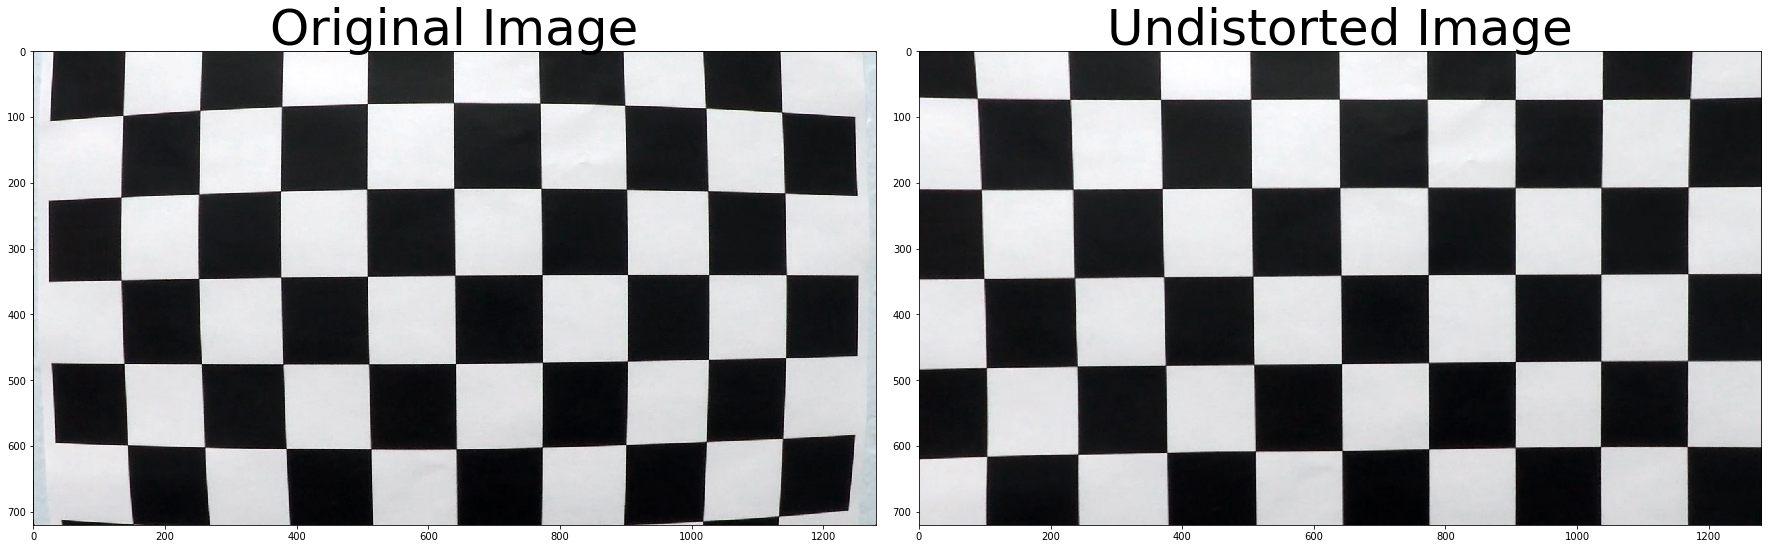

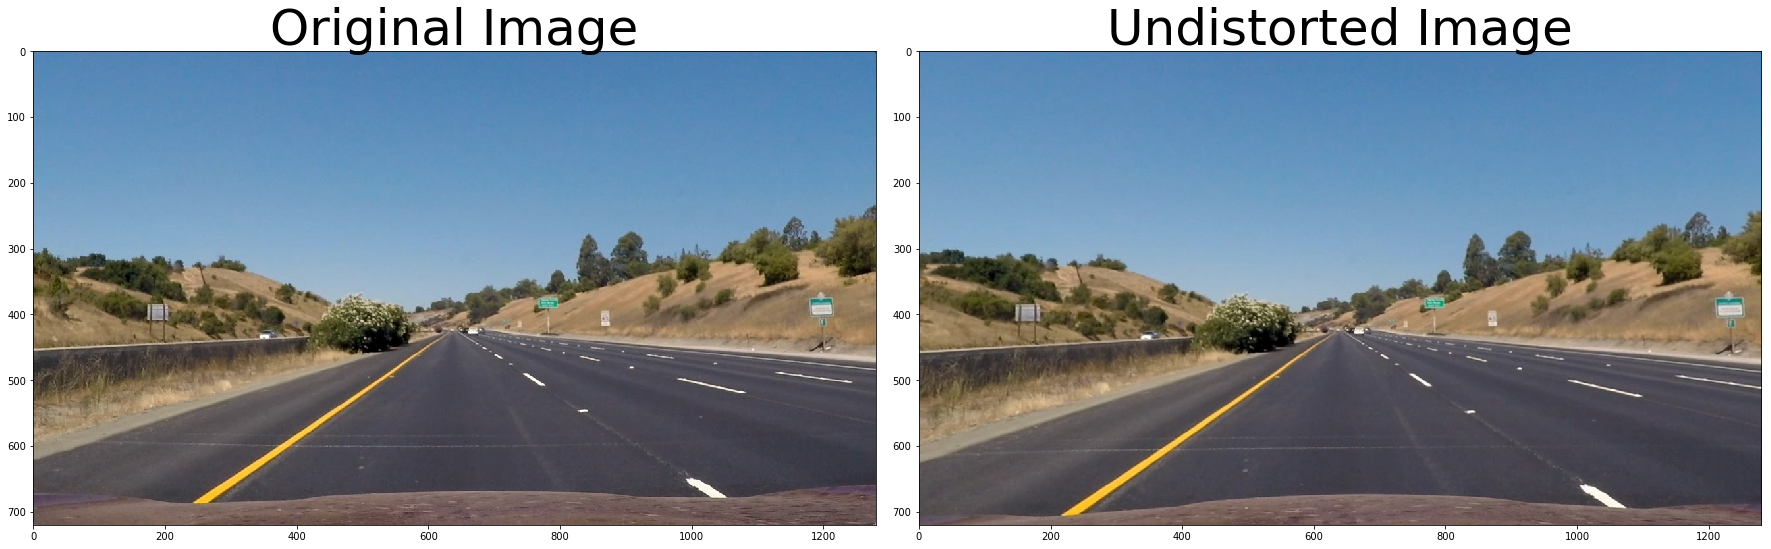

In [2]:
import matplotlib.image as mpimg

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist, mtx, dist
img = cv2.imread('../camera_cal/calibration1.jpg')
undistorted, cameraMat, distCoeffs = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('chass_undistorted.png')
image = mpimg.imread('../test_images/straight_lines1.jpg')
#image = mpimg.imread('../test_images/test2.jpg')
undistorted, cameraMat, distCoeffs = cal_undistort(image, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('undistorted.png')


## Thresholded binary image by color transforms and gradient

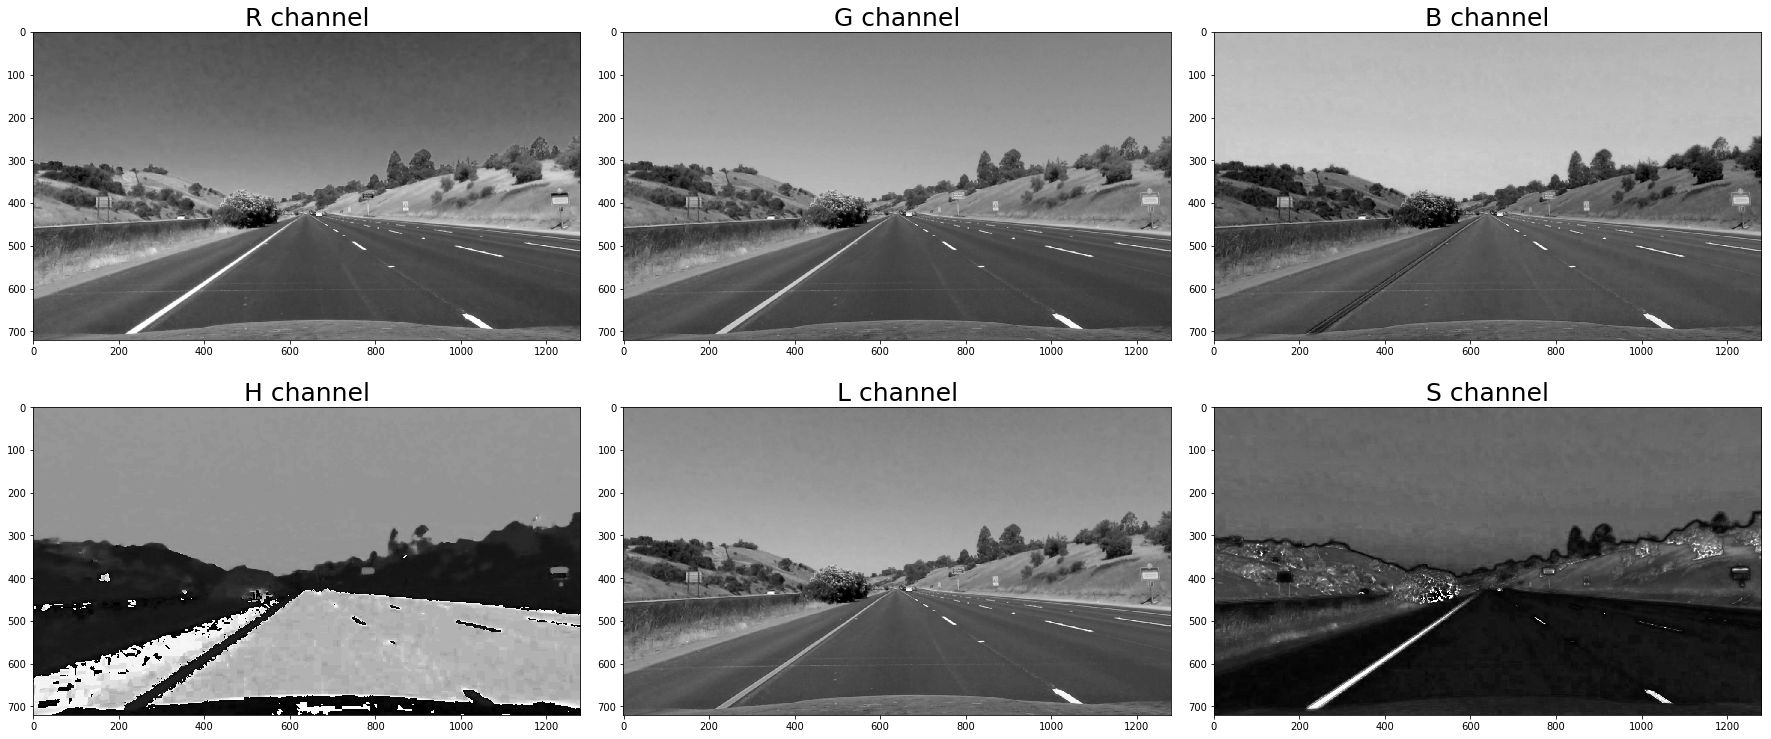

In [3]:
def get_hls_single_ch(img, ch='S'):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if ch == 'H':
        return hls[:,:,0]
    if ch == 'L':
        return hls[:,:,1]
    if ch == 'S':
        return hls[:,:,2]

def get_rgb_single_ch(img, ch='R'):
    rgb = img
    if ch == 'R':
        return rgb[:,:,0]
    if ch == 'G':
        return rgb[:,:,1]
    if ch == 'B':
        return rgb[:,:,2]

h_ch = get_hls_single_ch(undistorted,ch='H')
l_ch = get_hls_single_ch(undistorted,ch='L')
s_ch = get_hls_single_ch(undistorted,ch='S')

r_ch = get_rgb_single_ch(undistorted,ch='R')
g_ch = get_rgb_single_ch(undistorted,ch='G')
b_ch = get_rgb_single_ch(undistorted,ch='B')
# print(len(image.shape))
# print(len(s_ch.shape))
f, ((ax1, ax2, ax3),(ax21, ax22, ax23)) = plt.subplots(2, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(r_ch,cmap='gray')
ax1.set_title('R channel', fontsize=25)
ax2.imshow(g_ch,cmap='gray')
ax2.set_title('G channel', fontsize=25)
ax3.imshow(b_ch,cmap='gray')
ax3.set_title('B channel', fontsize=25)
ax21.imshow(h_ch,cmap='gray')
ax21.set_title('H channel', fontsize=25)
ax22.imshow(l_ch,cmap='gray')
ax22.set_title('L channel', fontsize=25)
ax23.imshow(s_ch,cmap='gray')
ax23.set_title('S channel', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=1.1, bottom=0.)
plt.savefig('color_channel.png')

## Define Threshold Function

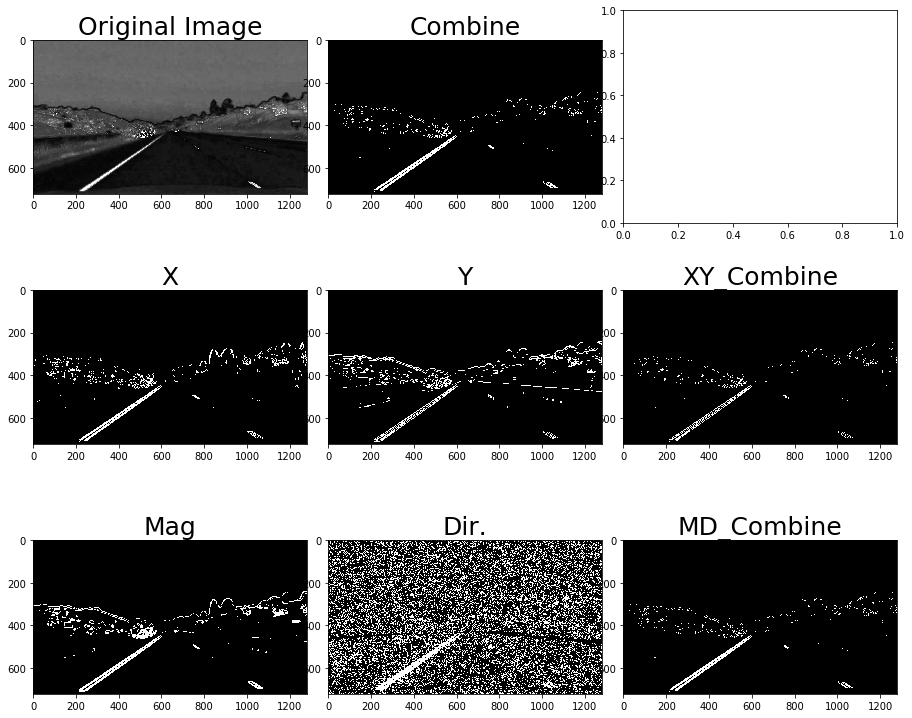

In [4]:
 def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def mag_thresh(img, sobel_kernel=15, mag_thresh=(40, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscal
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    mag = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.2)):
    # Grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def threshold(img, color=False, mag_dir_thresh=False):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_ch = get_hls_single_ch(img,ch='S')
    
    ## White Color
    lower_white = np.array([0,210,0], dtype=np.uint8)
    upper_white = np.array([255,255,255], dtype=np.uint8)
    white_mask = cv2.inRange(hls, lower_white, upper_white)
    
    ## Yellow Color
    lower_yellow = np.array([18,0,100], dtype=np.uint8)
    upper_yellow = np.array([30,220,255], dtype=np.uint8)
    yellow_mask = cv2.inRange(hls, lower_yellow, upper_yellow)  
    
    combined_binary = np.zeros_like(white_mask)
    
    if mag_dir_thresh:
        dir_mask = dir_threshold(s_ch)
        mag_mask = mag_thresh(s_ch)
        combined_binary[((dir_mask == 1) & (mag_mask == 1))] = 255
    
    if color:
        return np.dstack((white_mask, yellow_mask, combined_binary))
    
    else:
        combined_binary[((white_mask == 255) | (yellow_mask == 255))] = 1
        combined_binary[(combined_binary == 255)] = 1
        return combined_binary

# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(s_ch, orient='x', sobel_kernel=ksize, thresh=(30, 120))
grady = abs_sobel_thresh(s_ch, orient='y', sobel_kernel=ksize, thresh=(30, 120))

mag_binary = mag_thresh(s_ch, sobel_kernel=ksize, mag_thresh=(40, 255))
dir_binary = dir_threshold(s_ch, sobel_kernel=ksize, thresh=(0.7, 1.2))

md_combined = np.zeros_like(dir_binary)
md_combined[((mag_binary == 1) & (dir_binary == 1))] = 1
xy_combined = np.zeros_like(dir_binary)
xy_combined[((gradx == 1) & (grady == 1))] = 1
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, ((ax1, ax2, ax3), (ax21, ax22, ax23), (ax31, ax32, ax33))= plt.subplots(3, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(s_ch, cmap='gray')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combine', fontsize=25)
# ax3.imshow(grady, cmap='gray')
# ax3.set_title('Grad. Y', fontsize=25)

ax21.imshow(gradx, cmap='gray')
ax21.set_title('X', fontsize=25)
ax22.imshow(grady, cmap='gray')
ax22.set_title('Y', fontsize=25)
ax23.imshow(xy_combined, cmap='gray')
ax23.set_title('XY_Combine', fontsize=25)

ax31.imshow(mag_binary, cmap='gray')
ax31.set_title('Mag', fontsize=25)
ax32.imshow(dir_binary, cmap='gray')
ax32.set_title('Dir.', fontsize=25)
ax33.imshow(md_combined, cmap='gray')
ax33.set_title('MD_Combine', fontsize=25)
plt.subplots_adjust(left=0., right=0.5, top=1.1, bottom=0.)
plt.savefig('3x3_threshold.png')

## Visualized

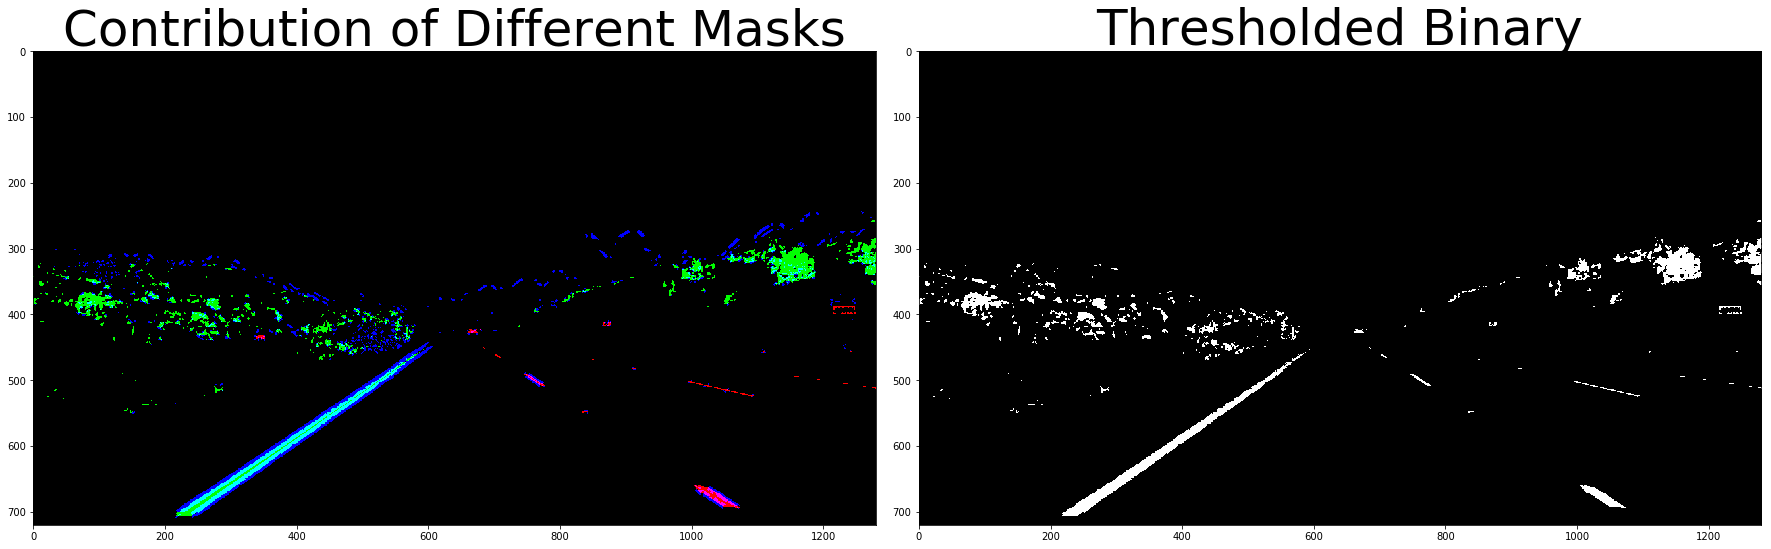

In [5]:
thresholded = threshold(undistorted, color=True, mag_dir_thresh=True)

b_thresholded = threshold(undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(thresholded)
ax1.set_title('Contribution of Different Masks', fontsize=50)
ax2.imshow(b_thresholded, cmap='gray')
ax2.set_title('Thresholded Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transform to create birds-eye view

[[  595.           450.        ]
 [  213.33332825   700.        ]
 [ 1096.66662598   700.        ]
 [  685.           450.        ]]
[450.0, 450.0, 700.0, 700.0, 450.0]


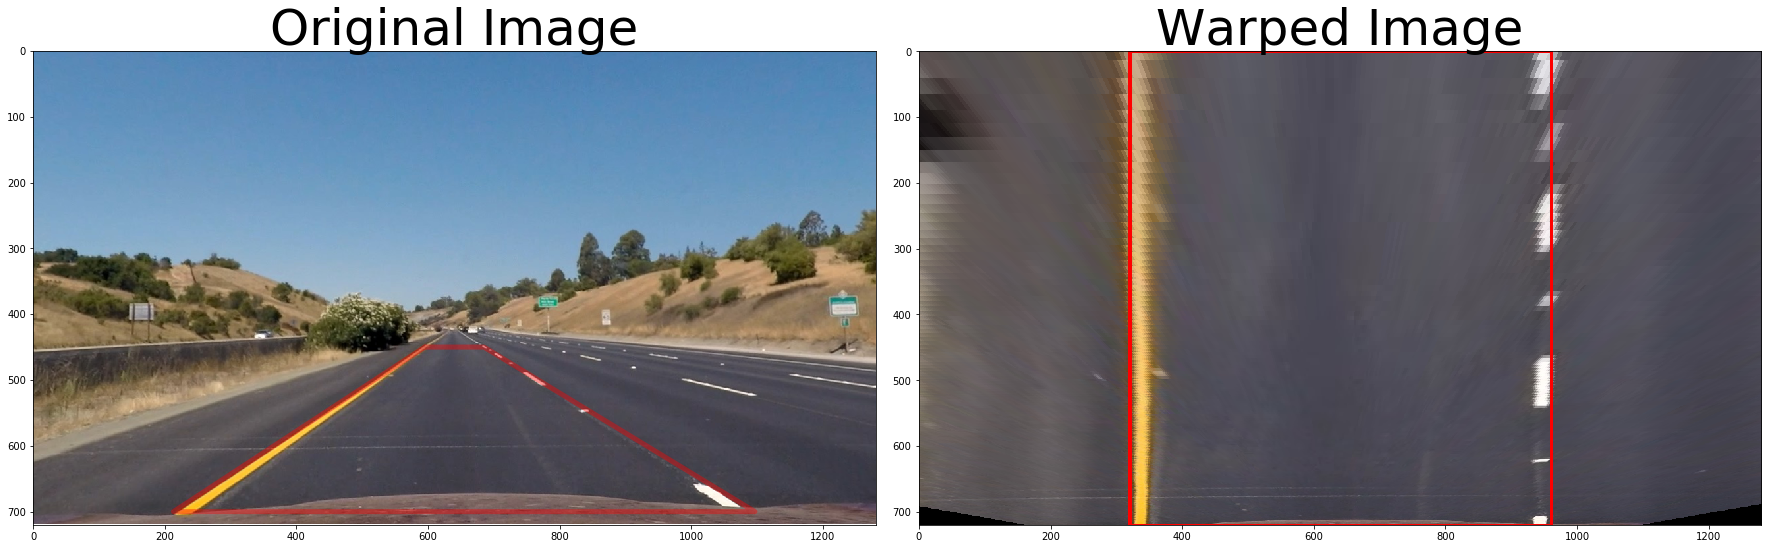

In [6]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped, M_inv

# image = mpimg.imread('../test_images/straight_lines1.jpg')
# image = cal_undistort(image, objpoints, imgpoints)
img_size = image.shape

src = np.float32(
    [[(img_size[1] / 2) - 45, img_size[0] / 2 + 90],
     [((img_size[1] / 6) ), img_size[0]-20],
     [(img_size[1] * 5 / 6) + 30, img_size[0]-20],
     [(img_size[1] / 2 + 45), img_size[0] / 2 + 90]])

dst = np.float32(
    [[(img_size[1] / 4), 0],
     [(img_size[1] / 4), img_size[0]],
     [(img_size[1] * 3 / 4), img_size[0]],
     [(img_size[1] * 3 / 4), 0]])

# cv2.line(image, tuple(src[0]), tuple(src[3]), color=[255,0,0], thickness=2)
# cv2.line(image, tuple(src[0]), tuple(src[1]), color=[255,0,0], thickness=2)
# cv2.line(image, tuple(src[1]), tuple(src[2]), color=[255,0,0], thickness=2)
# cv2.line(image, tuple(src[2]), tuple(src[3]), color=[255,0,0], thickness=2)

warped_image,Minv = warper(undistorted, src, dst)

cv2.rectangle(warped_image,((img_size[1] // 4),0),((img_size[1] * 3 // 4),img_size[0]),(255,0,0), 3) 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
x = [src[0][0],src[3][0],src[2][0],src[1][0],src[0][0]]
y = [src[0][1],src[3][1],src[2][1],src[1][1],src[0][1]]
print(src)
print(y)
ax1.imshow(undistorted)
ax1.plot(x, y, color='#ff0000', alpha=0.4, linewidth=5, solid_capstyle='round', zorder=2)

ax1.set_ylim(image.shape[0],0)
ax1.set_xlim([0,image.shape[1]])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_image)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Visuallized all thresholded warped_image

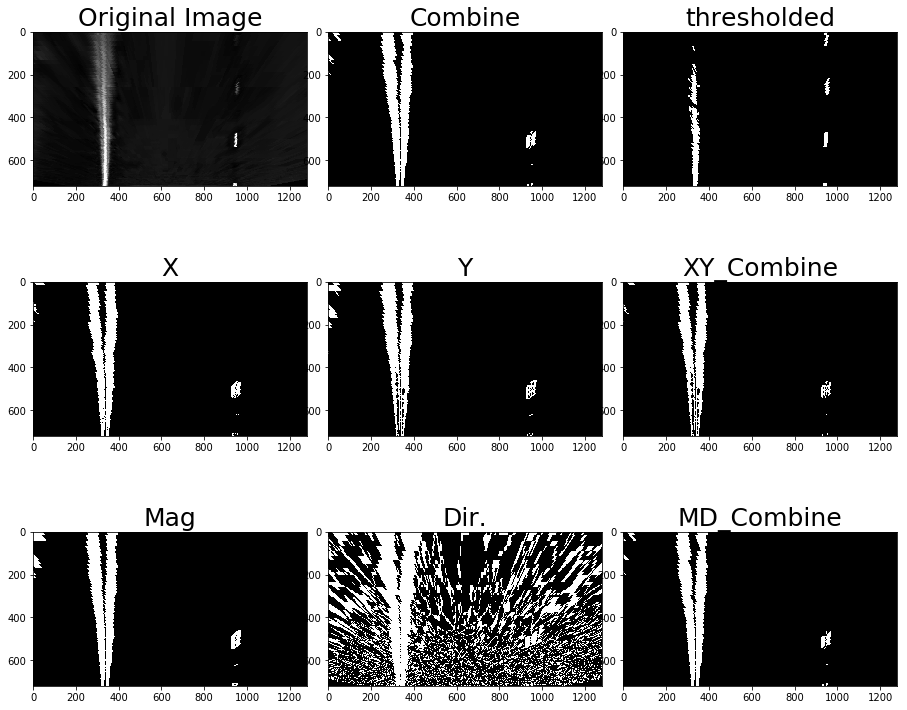

In [7]:
warped_b_thresholded,Minv = warper(b_thresholded, src, dst)

warped_s_ch,Minv = warper(s_ch, src, dst)
warped_combined,Minv = warper(combined, src, dst)
warped_gradx,Minv = warper(gradx, src, dst)
warped_grady,Minv = warper(grady, src, dst)
warped_xy_combined,Minv = warper(xy_combined, src, dst)
warped_mag_binary,Minv = warper(mag_binary, src, dst)
warped_dir_binary,Minv = warper(dir_binary, src, dst)
warped_md_combined,Minv = warper(md_combined, src, dst)

f, ((ax1, ax2, ax3), (ax21, ax22, ax23), (ax31, ax32, ax33))= plt.subplots(3, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped_s_ch, cmap='gray')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(warped_combined, cmap='gray')
ax2.set_title('Combine', fontsize=25)
ax3.imshow(warped_b_thresholded, cmap='gray')
ax3.set_title('thresholded', fontsize=25)

ax21.imshow(warped_gradx, cmap='gray')
ax21.set_title('X', fontsize=25)
ax22.imshow(warped_grady, cmap='gray')
ax22.set_title('Y', fontsize=25)
ax23.imshow(warped_xy_combined, cmap='gray')
ax23.set_title('XY_Combine', fontsize=25)

ax31.imshow(warped_mag_binary, cmap='gray')
ax31.set_title('Mag', fontsize=25)
ax32.imshow(warped_dir_binary, cmap='gray')
ax32.set_title('Dir.', fontsize=25)
ax33.imshow(warped_md_combined, cmap='gray')
ax33.set_title('MD_Combine', fontsize=25)
plt.subplots_adjust(left=0., right=0.5, top=1.1, bottom=0.)

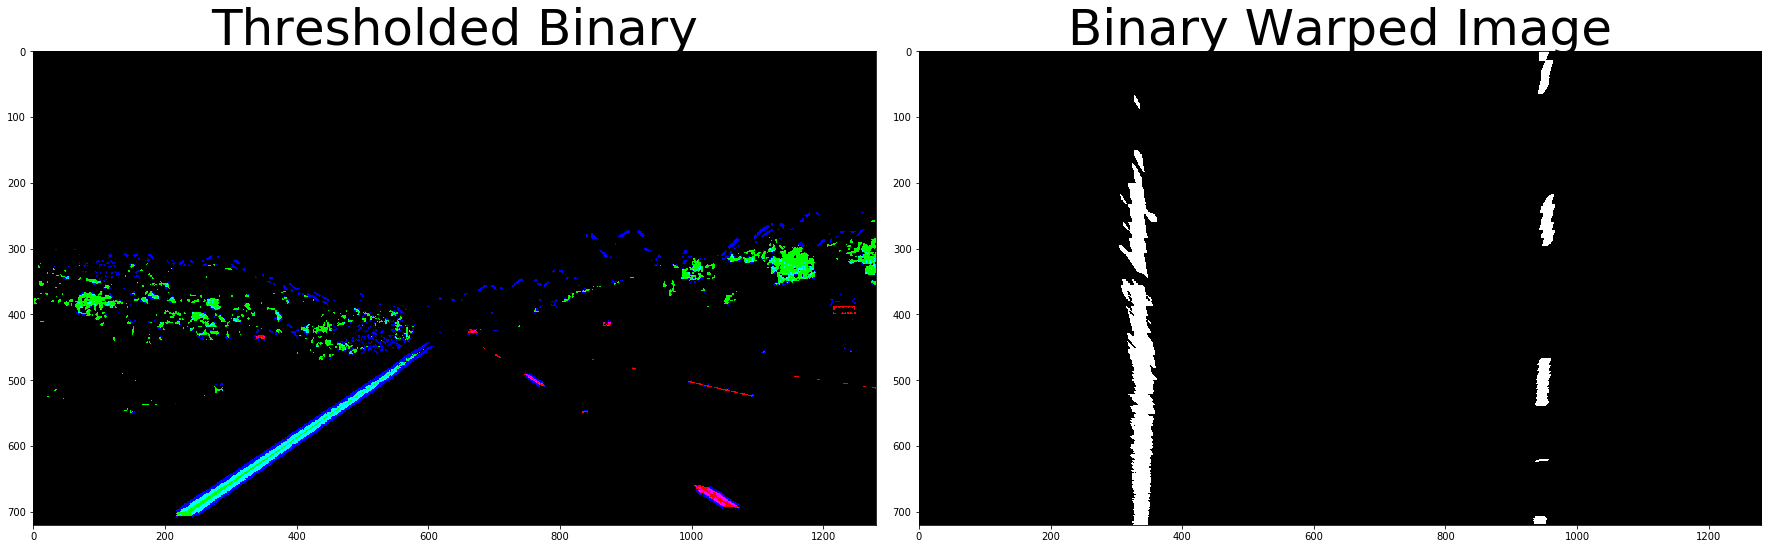

In [8]:
img_size = (b_thresholded.shape[1], b_thresholded.shape[0])
width, height = img_size
offset = 200
# src = np.float32([
#     [  588,   446 ],
#     [  691,   446 ],
#     [ 1126,   673 ],
#     [  153 ,   673 ]])
# dst = np.float32([[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]], [offset, img_size[1]]])
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst, src)

b_thresholded = threshold(undistorted)
binary_warped = cv2.warpPerspective(b_thresholded,M, (width, height))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(thresholded, cmap='gray')
ax1.set_title('Thresholded Binary', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Binary Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Detect lane pixels and fit to find the lane boundary

600.716165569


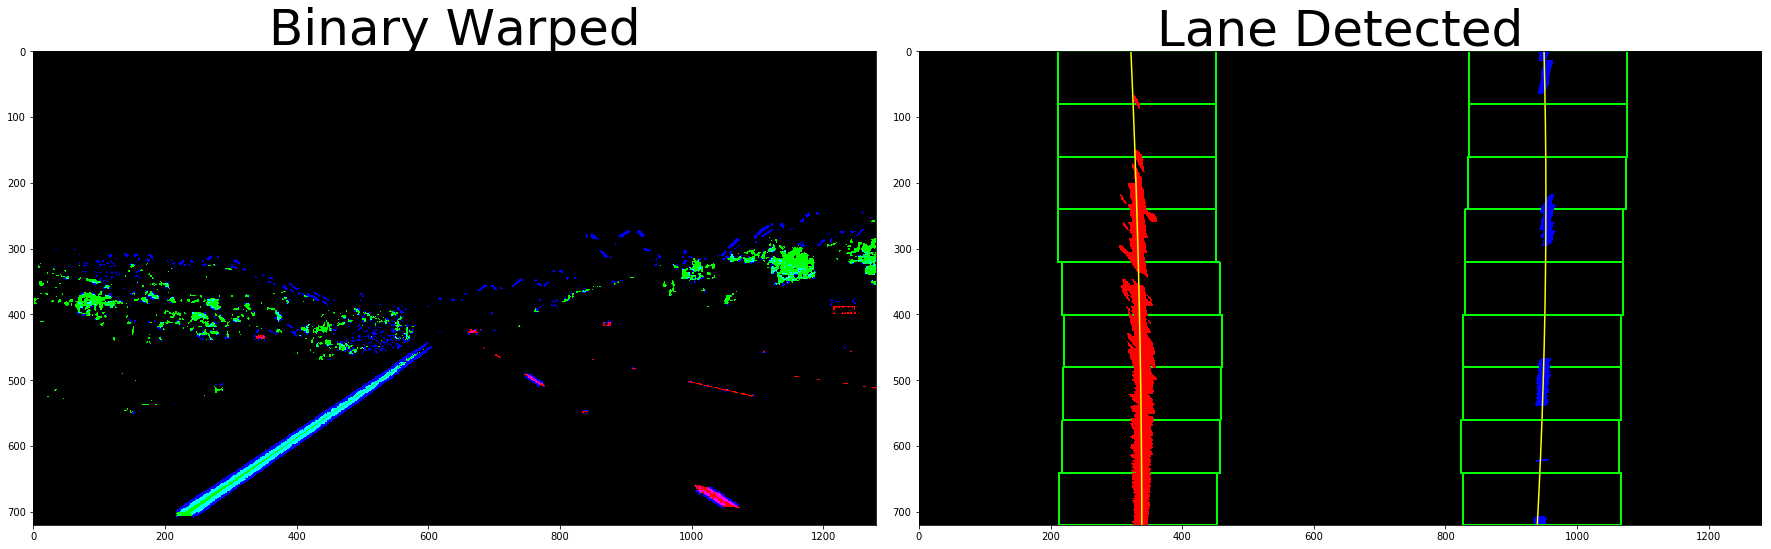

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Finding peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Number of sliding windows
nwindows = 9

# Height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identifing the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])


# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Margin in which to search
margin = 120

# Minimum number of pixels found to recenter window
minpix = 50

# Empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Steping through windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Drawing the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identifing the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Appending these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # Recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenating the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extracting left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

## Visualization
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# plt.figure(figsize=(10,40))
# plt.subplot(1,2,1)
# plt.imshow(binary_warped, cmap='gray')
# plt.title('Binary Warped')

# plt.subplot(1,2,2)
# plt.imshow(out_img)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)
# plt.title('Lane Detected')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(thresholded)
ax1.set_title('Binary Warped', fontsize=50)
ax2.imshow(out_img, cmap='gray')
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.set_title('Lane Detected', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

x_left = (left_fit[0]*image.shape[0]**2 + left_fit[1]*image.shape[0] + left_fit[2])
x_right = (right_fit[0]*image.shape[0]**2 + right_fit[1]*image.shape[0] + right_fit[2])
print(abs(x_left-x_right))

# Curvature of the lane
![](https://i.imgur.com/OF4m0pN.png)
![](https://i.imgur.com/TCC2Snj.png)

In [10]:
ym_per_pix = 3.048/100.0 # meters per pixel in y dimension, lane line(100 pixels) is 10 ft = 3.048 meters
xm_per_pix = 3.7/620.0 # meters per pixel in x dimension, lane width(620 pixel) is 12 ft = 3.7 meters
y_eval = 700
midx = 650

ly1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
ly2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

left_curvature = ((1 + ly1*ly1)**(1.5))/np.absolute(ly2)

ry1 = (2*right_fit[0]*y_eval + right_fit[1])*xm_per_pix/ym_per_pix
ry2 = 2*right_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

right_curvature = ((1 + ry1*ry1)**(1.5))/np.absolute(ry2)

# decide L or R curvature by # of points
if len(lefty) >= len(righty):
    curvature = left_curvature
else:
    curvature = right_curvature

print("Radius of Left Curvature: {}".format(left_curvature))
print("Radius of Right Curvature: {}".format(right_curvature))
print("Radius of Curvature: {}".format(curvature))

Radius of Left Curvature: 2617.5674769417683
Radius of Right Curvature: 1427.049086870089
Radius of Curvature: 2617.5674769417683


## Draw the Lane on Image

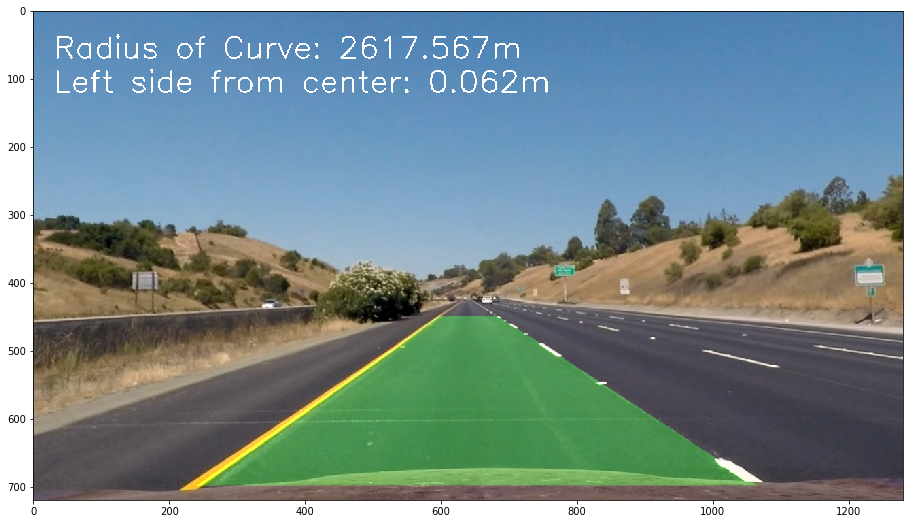

In [11]:
#image = mpimg.imread('../test_images/test2.jpg')
undistorted, mtx, dist = cal_undistort(image, objpoints, imgpoints)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
# print(pts)
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

text = 'Radius of Curve: ' + '{:04.3f}'.format(curvature) + 'm'
cv2.putText(result,text,(30,70), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2)

x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
if position_from_center < 0:
    direction = 'Left'
else:
    direction = 'Right'
text = direction + ' side' + ' from center: ' + '{:04.3f}'.format(abs(position_from_center)) + 'm '
cv2.putText(result,text,(30,120), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2)
plt.figure(figsize = (24,9))

plt.imshow(result)
plt.show()
plt.imsave('project_str1.jpg',result)

# Pipeline

In [12]:
def pipeline(img, line, M, Minv, cameraMat, distCoeffs):
    img_size = (img.shape[1], img.shape[0])
    width, height = img_size
    img = cv2.undistort(np.copy(img), cameraMat, distCoeffs)
    binary_warped = cv2.warpPerspective(threshold(img, mag_dir_thresh=False),M, (width, height))
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    margin = 80
    minpix = 50
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    if not line.first_frame_processed:
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        #out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
        
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3)
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
            
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Update current fit to Line
        line.update_fits(left_fit, right_fit)

        line.first_frame_processed = True
 
    else:
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        left_fit = line.avg_left_fit_coeffs
        right_fit = line.avg_right_fit_coeffs
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Update current fit to Line
        line.update_fits(left_fit, right_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(0,0,255), thickness=10)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=10)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    ## Add Radius of Curvature
    text = 'Radius of Curve: ' + '{:04.3f}'.format(line.curvature) + 'm'
    cv2.putText(result,text,(30,70), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2)
    
    ## Add distance from center
    position_from_center = line.get_position_from_center()
    if position_from_center < 0:
        direction = 'Left'
    else:
        direction = 'Right'
    text = direction + ' side' + ' from center: ' + '{:04.3f}'.format(abs(position_from_center)) + 'm '
    cv2.putText(result,text,(30,120), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2)
    
    return result

# Create Line class for tracking

In [13]:
class Line:
    def __init__(self):
        # if the first frame of video has been processed
        self.first_frame_processed = False  
        
        self.img = None
        
        self.avg_left_fit_coeffs = None
        self.avg_right_fit_coeffs = None
        self.mse_tolerance = 0.001
        self.left_fit = [np.array([False])] 
        self.right_fit = [np.array([False])] 
        self.his_left_fit = []
        self.his_right_fit = []
        self.y_eval = 700
        self.midx = 640
        self.ym_per_pix = 3.0/100.0 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/620.0 # meters per pixel in x dimension
        self.curvature = 0
       
    def update_avg_coeffe(self):
        """
        Average curve fitting coefficient
        """
        left_coeffs = self.his_left_fit[len(self.his_left_fit)-10:]
        #print(left_coeffs)
        right_coeffs = self.his_right_fit[len(self.his_right_fit)-10:]
        #print(right_coeffs)
        if len(left_coeffs)>0:
            avg=0
            for coeff in left_coeffs:
                avg +=np.array(coeff)
            avg = avg / len(left_coeffs)
            self.avg_left_fit_coeffs = avg
            print(self.avg_left_fit_coeffs)
        if len(right_coeffs)>0:
            avg=0
            for coeff in right_coeffs:
                avg +=np.array(coeff)
            avg = avg / len(right_coeffs)
            self.avg_right_fit_coeffs = avg
            print(self.avg_right_fit_coeffs)
            
    def update_fits(self, left_fit, right_fit):
        """
        Update the co-efficients of fitting polynomial
        """
        if self.first_frame_processed:
            left_error = ((self.left_fit[0] - left_fit[0])).mean(axis=None)
            right_error = ((self.right_fit[0] - right_fit[0])).mean(axis=None)
            print(left_error)
            print(right_error)
            if abs(left_error) < self.mse_tolerance:
                #self.left_fit = (0.75 * self.left_fit + 0.25 * left_fit)
                self.left_fit = left_fit
                self.his_left_fit.append(self.left_fit)
                print("L bad fit")
            if abs(right_error) < self.mse_tolerance:
                #self.right_fit = (0.75 * self.right_fit + 0.25 * right_fit)
                self.right_fit = right_fit
                self.his_right_fit.append(self.right_fit)
                print("R bad fit")
        else:
            self.right_fit = right_fit
            self.left_fit = left_fit
            self.his_left_fit.append(left_fit)
            self.his_right_fit.append(right_fit)
        
        self.update_avg_coeffe()
        #print(self.avg_right_fit_coeffs)
        self.update_curvature(self.avg_right_fit_coeffs)
     
     
    def update_curvature(self, fit):
        """
        Update radius of curvature
        """
        y1 = (2*fit[0]*self.y_eval + fit[1])*self.xm_per_pix/self.ym_per_pix
        y2 = 2*fit[0]*self.xm_per_pix/(self.ym_per_pix**2)
        curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
        
        if self.first_frame_processed:
            self.curvature = curvature
        
        elif np.absolute(self.curvature - curvature) < 500:
            self.curvature = 0.75*self.curvature + 0.25*(((1 + y1*y1)**(1.5))/np.absolute(y2)) 

    def get_position_from_center(self):
        """
        Get distance from center
        """
        x_left_pix = self.left_fit[0]*(self.y_eval**2) + self.left_fit[1]*self.y_eval + self.left_fit[2]
        x_right_pix = self.right_fit[0]*(self.y_eval**2) + self.right_fit[1]*self.y_eval + self.right_fit[2]
        
        return ((x_left_pix + x_right_pix)/2.0 - self.midx) * self.xm_per_pix

In [14]:
def process_image(img):
    return pipeline(img=img, line=line, M=M, Minv=Minv, cameraMat=cameraMat, distCoeffs=distCoeffs)

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line=Line()

white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("../project_video.mp4")#.subclip(0,5)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[ -4.17754186e-04   5.99918566e-01   1.73034942e+02]
[ -3.24337382e-04   4.79870422e-01   8.30905972e+02]
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

1.73472347598e-18
1.75811152642e-05
L bad fit
R bad fit
[ -4.17754186e-04   5.99918566e-01   1.73034942e+02]
[ -3.33127940e-04   4.89567899e-01   8.28318572e+02]


  0%|          | 2/1261 [00:00<04:32,  4.63it/s]

4.68484739955e-06
-6.57635030721e-06
L bad fit
R bad fit
[ -4.19315802e-04   6.02997675e-01   1.72072668e+02]
[ -3.33866009e-04   4.95470454e-01   8.24252203e+02]
-6.55624324047e-06
1.41055937748e-05
L bad fit
R bad fit
[ -4.18457549e-04   6.04326003e-01   1.71310482e+02]
[ -3.37761442e-04   5.04583731e-01   8.19471611e+02]


  0%|          | 5/1261 [00:00<03:42,  5.65it/s]

4.37603634035e-07
1.47020803493e-05
L bad fit
R bad fit
[ -4.18030118e-04   6.05371495e-01   1.70840074e+02]
[ -3.43039118e-04   5.15395334e-01   8.14224408e+02]
-2.32619572868e-05
2.36332209999e-06
L bad fit
R bad fit
[ -4.11925164e-04   6.05565912e-01   1.69373070e+02]
[ -3.53863213e-04   5.40105998e-01   8.01513658e+02]


  0%|          | 6/1261 [00:01<03:40,  5.70it/s]

1.03592506863e-05
-1.25979052742e-05
L bad fit
R bad fit
[ -4.04265506e-04   6.05039433e-01   1.67761507e+02]
[ -3.61526068e-04   5.61610965e-01   7.89636523e+02]
-2.68122807003e-05
-3.0018991322e-05
L bad fit
R bad fit
[ -3.90011547e-04   6.01375770e-01   1.65325680e+02]
[ -3.38905743e-04   5.46732166e-01   7.89237249e+02]


  1%|          | 8/1261 [00:01<03:37,  5.77it/s]

-1.91824915414e-06
-5.5369440734e-05
L bad fit
R bad fit
[ -3.74687158e-04   5.96032768e-01   1.64232325e+02]
[ -2.68526806e-04   5.09982839e-01   7.87214432e+02]
-3.845393022e-05
-3.16765301929e-06
L bad fit
R bad fit
[ -3.97415251e-04   5.98989877e-01   1.68340240e+02]
[ -3.29340618e-04   5.23464035e-01   8.02572814e+02]


  1%|          | 10/1261 [00:01<03:30,  5.95it/s]

-1.47215109858e-06
-3.24635504387e-05
L bad fit
R bad fit
[ -3.89115940e-04   5.95757243e-01   1.67439694e+02]
[ -3.20196440e-04   5.22386439e-01   7.99374576e+02]
2.5072614311e-05
3.60122555859e-05
L bad fit
R bad fit
[ -3.83323890e-04   5.95512275e-01   1.65634781e+02]
[ -3.12895376e-04   5.23226172e-01   7.95413115e+02]


  1%|          | 13/1261 [00:02<03:20,  6.24it/s]

-4.0097601831e-05
-1.87956319539e-05
L bad fit
R bad fit
[ -3.73053596e-04   5.91460902e-01   1.64006795e+02]
[ -3.04372384e-04   5.17863579e-01   7.95432799e+02]
-1.73881825596e-05
1.8750557854e-05
L bad fit
R bad fit
[ -3.61700107e-04   5.86341088e-01   1.62543371e+02]
[ -2.96313888e-04   5.13119986e-01   7.95118841e+02]


  1%|          | 14/1261 [00:02<03:12,  6.47it/s]

-8.27656073675e-06
3.00119573717e-06
L bad fit
R bad fit
[ -3.49475202e-04   5.80395877e-01   1.61177967e+02]
[ -2.87085304e-04   5.06654150e-01   7.95360684e+02]
5.90614268476e-05
2.0766784372e-05
L bad fit
R bad fit
[ -3.45482636e-04   5.81061146e-01   1.58907785e+02]
[ -2.79697066e-04   5.04482848e-01   7.93141168e+02]


  1%|▏         | 16/1261 [00:02<03:27,  6.00it/s]

1.3865104423e-05
1.19077951653e-05
L bad fit
R bad fit
[ -3.41840655e-04   5.81380965e-01   1.56929015e+02]
[ -2.74759398e-04   5.05050981e-01   7.89825169e+02]
3.40835790886e-05
-9.12133284681e-06
L bad fit
R bad fit
[ -3.44288260e-04   5.85979939e-01   1.54518345e+02]
[ -2.71911496e-04   5.08275406e-01   7.85361848e+02]


  1%|▏         | 18/1261 [00:03<03:15,  6.34it/s]

6.00462338359e-06
-1.05129844573e-06
L bad fit
R bad fit
[ -3.47528152e-04   5.90890271e-01   1.52047145e+02]
[ -2.74495408e-04   5.14135174e-01   7.80938560e+02]
-1.90747217158e-05
-9.87462216584e-06
L bad fit
R bad fit
[ -3.52705965e-04   5.96831831e-01   1.49600952e+02]
[ -2.76408624e-04   5.19106889e-01   7.76997750e+02]


  2%|▏         | 20/1261 [00:03<03:29,  5.93it/s]

-1.42683893412e-05
-7.98382132094e-06
L bad fit
R bad fit
[ -3.56604154e-04   6.01627009e-01   1.47287280e+02]
[ -2.80769812e-04   5.24493588e-01   7.73849083e+02]
-2.34947106572e-05
6.98691940241e-05
L bad fit
R bad fit
[ -3.55645611e-04   6.01504118e-01   1.45962603e+02]
[ -2.88516694e-04   5.29329967e-01   7.72549461e+02]


  2%|▏         | 22/1261 [00:03<03:35,  5.75it/s]

-2.32158532788e-05
-4.24131942016e-06
L bad fit
R bad fit
[ -3.56375242e-04   6.02655180e-01   1.44607875e+02]
[ -2.97719007e-04   5.37535496e-01   7.69603080e+02]
5.11908686055e-06
-1.02183350924e-05
L bad fit
R bad fit
[ -3.59355601e-04   6.04927615e-01   1.43140061e+02]
[ -3.04024431e-04   5.40382862e-01   7.69327677e+02]


  2%|▏         | 24/1261 [00:04<03:32,  5.82it/s]

4.59352770778e-05
-4.85837404629e-05
L bad fit
R bad fit
[ -3.67757143e-04   6.11326117e-01   1.41232657e+02]
[ -3.05171362e-04   5.39021760e-01   7.69752692e+02]
4.37339681672e-05
8.96581882378e-05
L bad fit
R bad fit
[ -3.74625940e-04   6.16167496e-01   1.39598225e+02]
[ -3.13207432e-04   5.42283818e-01   7.70319088e+02]


  2%|▏         | 27/1261 [00:04<03:22,  6.09it/s]

-4.90850971981e-05
-2.45181141878e-05
L bad fit
R bad fit
[ -3.75199716e-04   6.15461832e-01   1.38714675e+02]
[ -3.17600912e-04   5.38267827e-01   7.74862948e+02]
2.86949604137e-05
-1.84426923656e-06
L bad fit
R bad fit
[ -3.75234630e-04   6.14401539e-01   1.37873693e+02]
[ -3.22722098e-04   5.34716013e-01   7.79749854e+02]


  2%|▏         | 28/1261 [00:04<03:28,  5.90it/s]

-1.37383292307e-05
-1.10801865917e-05
L bad fit
R bad fit
[ -3.73295249e-04   6.11250866e-01   1.37363507e+02]
[ -3.26840396e-04   5.27237396e-01   7.87318809e+02]
3.36230000984e-05
6.57138640585e-06
L bad fit
R bad fit
[ -3.76625641e-04   6.12387466e-01   1.36511191e+02]
[ -3.32603294e-04   5.24543836e-01   7.92259816e+02]


  2%|▏         | 30/1261 [00:05<03:33,  5.76it/s]

2.09037177642e-05
1.75338635908e-05
L bad fit
R bad fit
[ -3.83473243e-04   6.16242043e-01   1.35675063e+02]
[ -3.40917961e-04   5.27096577e-01   7.94576928e+02]
5.60770110438e-05
2.84401537889e-05
L bad fit
R bad fit
[ -3.98278017e-04   6.26862579e-01   1.34121965e+02]
[ -3.45089723e-04   5.31505124e-01   7.94107160e+02]


  3%|▎         | 32/1261 [00:05<03:37,  5.64it/s]

3.12162936876e-05
2.12922208727e-05
L bad fit
R bad fit
[ -4.18526006e-04   6.41778938e-01   1.32505972e+02]
[ -3.51814840e-04   5.42388204e-01   7.90029819e+02]
-1.66663945095e-05
-5.68625455573e-05
L bad fit
R bad fit
[ -4.36595446e-04   6.55430801e-01   1.30974634e+02]
[ -3.53875536e-04   5.49080973e-01   7.86915824e+02]


  3%|▎         | 35/1261 [00:05<03:24,  5.99it/s]

3.07582158632e-05
-4.13459399309e-05
L bad fit
R bad fit
[ -4.53147181e-04   6.68568978e-01   1.29368128e+02]
[ -3.56660012e-04   5.56842124e-01   7.83525660e+02]
2.44259203954e-07
0.000102209423511
L bad fit
R bad fit
[ -4.65349945e-04   6.78332733e-01   1.28332011e+02]
[ -3.60699611e-04   5.64127028e-01   7.80804731e+02]


  3%|▎         | 37/1261 [00:06<02:58,  6.88it/s]

-4.80266284098e-06
-0.000110585226968
L bad fit
R bad fit
[ -4.81980952e-04   6.92521521e-01   1.26693819e+02]
[ -3.56132499e-04   5.67596628e-01   7.76819554e+02]
1.62931649346e-05
0.000141338758038
L bad fit
R bad fit
[ -4.97371779e-04   7.06404040e-01   1.24971550e+02]
[ -3.65883689e-04   5.84578584e-01   7.69515902e+02]


  3%|▎         | 39/1261 [00:06<02:52,  7.07it/s]

2.37207771511e-05
3.04328748762e-05
L bad fit
R bad fit
[ -5.16508518e-04   7.24775350e-01   1.22349532e+02]
[ -3.79786186e-04   6.08404328e-01   7.59006498e+02]
1.30346973607e-05
6.13280724285e-06
L bad fit
R bad fit
[ -5.33586426e-04   7.42095023e-01   1.19661246e+02]
[ -3.93644825e-04   6.32371135e-01   7.48252145e+02]


  3%|▎         | 41/1261 [00:06<02:41,  7.53it/s]

-3.61097429532e-05
-2.16583938886e-05
L bad fit
R bad fit
[ -5.44962987e-04   7.55382213e-01   1.17074973e+02]
[ -4.03584238e-04   6.50359481e-01   7.40010267e+02]
-1.07211269373e-05
1.18193450146e-05
L bad fit
R bad fit
[ -5.49659736e-04   7.63183229e-01   1.15155218e+02]
[ -4.11861571e-04   6.64810805e-01   7.33456564e+02]


  3%|▎         | 43/1261 [00:07<02:44,  7.39it/s]

2.77704395584e-07
-8.07818044738e-06
L bad fit
R bad fit
[ -5.51262625e-04   7.68517706e-01   1.13366532e+02]
[ -4.17201863e-04   6.73906083e-01   7.29475430e+02]
-4.51074015269e-05
-1.41748903224e-05
L bad fit
R bad fit
[ -5.50021413e-04   7.71739670e-01   1.11912556e+02]
[ -4.26810921e-04   6.86882167e-01   7.24546230e+02]


  4%|▎         | 45/1261 [00:07<02:56,  6.91it/s]

-4.0800529413e-05
-1.70896018357e-05
L bad fit
R bad fit
[ -5.41624327e-04   7.68752319e-01   1.11251518e+02]
[ -4.38845612e-04   6.99200717e-01   7.21093376e+02]
-2.48423175334e-05
-8.94179833507e-07
L bad fit
R bad fit
[ -5.30718583e-04   7.63930799e-01   1.10634254e+02]
[ -4.40569943e-04   7.01907284e-01   7.20102351e+02]


  4%|▎         | 47/1261 [00:07<02:47,  7.26it/s]

-9.88636221002e-06
-0.000115974539767
L bad fit
R bad fit
[ -5.19304470e-04   7.58235779e-01   1.10061621e+02]
[ -4.41755343e-04   7.03158412e-01   7.20131708e+02]
-1.54722312943e-05
7.71411802049e-05
L bad fit
R bad fit
[ -5.04713816e-04   7.49645828e-01   1.09843095e+02]
[ -4.36520985e-04   6.96694660e-01   7.22598345e+02]


  4%|▍         | 49/1261 [00:07<02:50,  7.11it/s]

-6.03605961639e-06
2.4882399898e-05
L bad fit
R bad fit
[ -4.87147479e-04   7.37502046e-01   1.10511941e+02]
[ -4.30731580e-04   6.90181582e-01   7.24871373e+02]
-3.29113057502e-05
-8.20228471813e-07
L bad fit
R bad fit
[ -4.64986542e-04   7.21137088e-01   1.11651869e+02]
[ -4.24246871e-04   6.79454891e-01   7.29905762e+02]


  4%|▍         | 51/1261 [00:08<02:53,  6.99it/s]

1.44816064238e-05
8.11268869002e-06
L bad fit
R bad fit
[ -4.47884740e-04   7.08832532e-01   1.12271287e+02]
[ -4.20739270e-04   6.73365340e-01   7.33081483e+02]
-2.45707594112e-05
1.44179887269e-06
L bad fit
R bad fit
[ -4.29397974e-04   6.95279939e-01   1.13031844e+02]
[ -4.16193915e-04   6.65788846e-01   7.36715140e+02]


  4%|▍         | 53/1261 [00:08<03:03,  6.59it/s]

-8.23239802324e-06
-6.19594371948e-06
L bad fit
R bad fit
[ -4.10060198e-04   6.80671851e-01   1.14113195e+02]
[ -4.11836784e-04   6.60233377e-01   7.38807126e+02]
6.76489865873e-06
5.56660852942e-06
L bad fit
R bad fit
[ -3.95909653e-04   6.69924741e-01   1.14802553e+02]
[ -4.09453802e-04   6.58316237e-01   7.38971481e+02]


  4%|▍         | 55/1261 [00:08<03:03,  6.58it/s]

-5.08690348865e-06
5.67396720965e-08
L bad fit
R bad fit
[ -3.85330469e-04   6.61435937e-01   1.15495403e+02]
[ -4.08785454e-04   6.60214047e-01   7.37113558e+02]
-1.69926937003e-05
3.99467862197e-06
L bad fit
R bad fit
[ -3.75536249e-04   6.53008161e-01   1.16297638e+02]
[ -4.08605992e-04   6.62939947e-01   7.34825002e+02]


  5%|▍         | 57/1261 [00:09<03:08,  6.39it/s]

1.03888563029e-05
-1.287119475e-05
L bad fit
R bad fit
[ -3.67769550e-04   6.45773373e-01   1.17099784e+02]
[ -4.18736865e-04   6.73397756e-01   7.31422476e+02]
7.35694978092e-06
-6.90953446556e-06
L bad fit
R bad fit
[ -3.62285769e-04   6.39863236e-01   1.18008921e+02]
[ -4.20462666e-04   6.78127556e-01   7.28505776e+02]


  5%|▍         | 59/1261 [00:09<02:54,  6.87it/s]

-2.24812730533e-05
-3.56961607862e-05
L bad fit
R bad fit
[ -3.55157466e-04   6.32391261e-01   1.19091448e+02]
[ -4.16130612e-04   6.76050041e-01   7.27695428e+02]
2.63587888721e-05
-9.39052064334e-05
L bad fit
R bad fit
[ -3.53956174e-04   6.29151098e-01   1.20165477e+02]
[ -4.02490059e-04   6.70768665e-01   7.24961597e+02]


  5%|▍         | 60/1261 [00:09<02:54,  6.87it/s]

1.75641396631e-05
9.56251223443e-06
L bad fit
R bad fit
[ -3.53063134e-04   6.25131106e-01   1.21925416e+02]
[ -3.88994489e-04   6.65331593e-01   7.21862944e+02]
-1.39305742194e-05
-2.06591541524e-05
L bad fit
R bad fit
[ -3.53234113e-04   6.20856327e-01   1.24286540e+02]
[ -3.73288823e-04   6.57657529e-01   7.19089288e+02]


  5%|▍         | 63/1261 [00:10<02:57,  6.75it/s]

1.23209115931e-05
4.26836749321e-05
L bad fit
R bad fit
[ -3.55460423e-04   6.17931104e-01   1.26575520e+02]
[ -3.62471120e-04   6.53908384e-01   7.15676446e+02]
-5.26402965515e-06
1.85474814112e-05
L bad fit
R bad fit
[ -3.56483841e-04   6.13860512e-01   1.28962218e+02]
[ -3.52951503e-04   6.48954153e-01   7.13751937e+02]


  5%|▌         | 65/1261 [00:10<02:54,  6.84it/s]

3.83957299924e-06
2.2126079734e-06
L bad fit
R bad fit
[ -3.58399905e-04   6.10514310e-01   1.31327981e+02]
[ -3.43647474e-04   6.43424096e-01   7.12237963e+02]
-2.22259203318e-06
-2.24374252415e-05
L bad fit
R bad fit
[ -3.61792980e-04   6.08213451e-01   1.33601483e+02]
[ -3.31700234e-04   6.33902606e-01   7.12111155e+02]


  5%|▌         | 67/1261 [00:10<02:50,  6.98it/s]

2.96146932369e-05
2.58590072257e-06
L bad fit
R bad fit
[ -3.67108639e-04   6.07445492e-01   1.35838479e+02]
[ -3.21298703e-04   6.26404915e-01   7.11086146e+02]
-1.77743104556e-05
1.40465985603e-06
L bad fit
R bad fit
[ -3.69911172e-04   6.04661805e-01   1.38328181e+02]
[ -3.11728593e-04   6.18177408e-01   7.10759726e+02]


  5%|▌         | 69/1261 [00:10<02:55,  6.78it/s]

6.66750850742e-07
-2.08619368978e-05
L bad fit
R bad fit
[ -3.75028507e-04   6.03486678e-01   1.40640433e+02]
[ -3.03641904e-04   6.09645107e-01   7.11176740e+02]
-1.00969072912e-05
3.278808698e-06
L bad fit
R bad fit
[ -3.76500272e-04   5.99466371e-01   1.43280580e+02]
[ -3.05273617e-04   6.07740865e-01   7.11135180e+02]


  6%|▌         | 71/1261 [00:11<02:49,  7.01it/s]

-2.60478633857e-05
-1.66223540821e-05
L bad fit
R bad fit
[ -3.73610838e-04   5.92647678e-01   1.45704369e+02]
[ -3.04286843e-04   6.00425420e-01   7.14179366e+02]
4.89624883156e-06
-0.000127683812391
L bad fit
R bad fit
[ -3.72604085e-04   5.88322233e-01   1.47348994e+02]
[ -2.92597604e-04   5.84951806e-01   7.18679868e+02]


  6%|▌         | 73/1261 [00:11<02:55,  6.79it/s]

-3.08422395282e-05
0.000281130209928
L bad fit
R bad fit
[ -3.67281017e-04   5.80823527e-01   1.49152830e+02]
[ -3.04753018e-04   5.86837800e-01   7.21316974e+02]
-2.52716023515e-05
-1.15589721199e-05
L bad fit
R bad fit
[ -3.59957192e-04   5.72076318e-01   1.51010001e+02]
[ -3.13897786e-04   5.87871684e-01   7.23431606e+02]


  6%|▌         | 75/1261 [00:11<02:45,  7.15it/s]

-1.26978713624e-05
5.52650438408e-06
L bad fit
R bad fit
[ -3.50979623e-04   5.62325059e-01   1.52813294e+02]
[ -3.23373945e-04   5.89092048e-01   7.25655626e+02]
-4.103228252e-06
-1.90431608637e-06
L bad fit
R bad fit
[ -3.41813990e-04   5.53406704e-01   1.53975380e+02]
[ -3.34903414e-04   5.92323441e-01   7.27590761e+02]


  6%|▌         | 77/1261 [00:12<02:51,  6.92it/s]

8.15603935912e-06
6.44503061269e-06
L bad fit
R bad fit
[ -3.30502492e-04   5.42928854e-01   1.55248049e+02]
[ -3.46818796e-04   5.96980795e-01   7.28869199e+02]
-2.47211831194e-05
-1.9367376846e-05
L bad fit
R bad fit
[ -3.18496306e-04   5.32402523e-01   1.55980876e+02]
[ -3.56656975e-04   5.98044018e-01   7.32128636e+02]


  6%|▋         | 79/1261 [00:12<02:45,  7.15it/s]

-1.42701287038e-05
-1.34294146299e-05
L bad fit
R bad fit
[ -3.04996433e-04   5.20970710e-01   1.56750773e+02]
[ -3.67238405e-04   6.00529146e-01   7.34936236e+02]
3.97248342749e-06
-3.86545283772e-06
L bad fit
R bad fit
[ -2.92903498e-04   5.10686068e-01   1.57001793e+02]
[ -3.77105410e-04   6.00695678e-01   7.39260804e+02]


  6%|▋         | 81/1261 [00:12<03:02,  6.46it/s]

-2.82333078681e-06
-4.84483949113e-06
L bad fit
R bad fit
[ -2.83133017e-04   5.01943331e-01   1.57257522e+02]
[ -3.88150166e-04   6.03862205e-01   7.41929674e+02]
5.99082733773e-05
9.05363388892e-06
L bad fit
R bad fit
[ -2.78863738e-04   4.97238390e-01   1.57016498e+02]
[ -4.12868667e-04   6.19416813e-01   7.41736887e+02]


  7%|▋         | 83/1261 [00:12<02:50,  6.92it/s]

-7.48600177374e-08
-1.42173466641e-05
L bad fit
R bad fit
[ -2.77671197e-04   4.94956154e-01   1.56386587e+02]
[ -4.08052412e-04   6.10349726e-01   7.46121990e+02]
-9.54144012081e-06
-2.30212699301e-05
L bad fit
R bad fit
[ -2.78051673e-04   4.93494014e-01   1.55856307e+02]
[ -4.02089927e-04   6.00533060e-01   7.50517520e+02]


  7%|▋         | 85/1261 [00:13<02:55,  6.71it/s]

-3.14169611133e-06
-0.000129270487557
L bad fit
R bad fit
[ -2.79387765e-04   4.92970612e-01   1.54730952e+02]
[ -3.82647743e-04   5.77227755e-01   7.59023023e+02]
4.04724749763e-06
2.8321943633e-05
L bad fit
R bad fit
[ -2.81538906e-04   4.92259435e-01   1.54260115e+02]
[ -3.66228185e-04   5.58458341e-01   7.65585383e+02]


  7%|▋         | 87/1261 [00:13<02:48,  6.97it/s]

6.17556948839e-06
3.17208180905e-05
L bad fit
R bad fit
[ -2.83491999e-04   4.91485467e-01   1.53781636e+02]
[ -3.52336206e-04   5.40639728e-01   7.72460529e+02]
2.25803635873e-05
-9.74247064623e-06
L bad fit
R bad fit
[ -2.90175248e-04   4.93194914e-01   1.54355723e+02]
[ -3.39406717e-04   5.29381186e-01   7.74752451e+02]


  7%|▋         | 89/1261 [00:13<02:48,  6.97it/s]

5.9839480858e-05
0.000101872131471
L bad fit
R bad fit
[ -3.04269457e-04   5.00803366e-01   1.54532656e+02]
[ -3.38007383e-04   5.31194787e-01   7.72759104e+02]
2.68880956642e-05
-1.47604927857e-05
L bad fit
R bad fit
[ -3.20655227e-04   5.10267741e-01   1.54887812e+02]
[ -3.35518545e-04   5.33477184e-01   7.69762478e+02]


  7%|▋         | 91/1261 [00:14<02:44,  7.13it/s]

1.73574483014e-05
-8.57353489799e-06
L bad fit
R bad fit
[ -3.39059075e-04   5.21569487e-01   1.55369586e+02]
[ -3.32656838e-04   5.37590117e-01   7.65205647e+02]
2.59136229471e-05
-5.3463812171e-06
L bad fit
R bad fit
[ -3.54063459e-04   5.31038695e-01   1.55756907e+02]
[ -3.28355129e-04   5.37321526e-01   7.63189200e+02]


  7%|▋         | 93/1261 [00:14<02:53,  6.74it/s]

-6.10401021717e-06
-3.32670817823e-06
L bad fit
R bad fit
[ -3.68464927e-04   5.40366596e-01   1.56237165e+02]
[ -3.25142483e-04   5.38128794e-01   7.60928188e+02]
3.11456137142e-05
-1.02565513385e-05
L bad fit
R bad fit
[ -3.86935100e-04   5.53155936e-01   1.56410284e+02]
[ -3.23206310e-04   5.40363445e-01   7.57958581e+02]


  8%|▊         | 95/1261 [00:14<02:51,  6.79it/s]

-6.81851238636e-06
3.05518647449e-06
L bad fit
R bad fit
[ -4.05037592e-04   5.65905742e-01   1.57010499e+02]
[ -3.34502704e-04   5.55944096e-01   7.50898705e+02]
-1.10247020073e-05
-1.12328058196e-05
L bad fit
R bad fit
[ -4.21632889e-04   5.77696909e-01   1.57541518e+02]
[ -3.41843623e-04   5.66278591e-01   7.45715519e+02]


  8%|▊         | 97/1261 [00:14<02:50,  6.83it/s]

-3.30900941563e-06
-4.10797811393e-05
L bad fit
R bad fit
[ -4.37279728e-04   5.89326341e-01   1.57845790e+02]
[ -3.41904482e-04   5.70423889e-01   7.41863114e+02]
-3.817990116e-06
0.000116474213385
L bad fit
R bad fit
[ -4.50286732e-04   6.00252069e-01   1.57281388e+02]
[ -3.54587010e-04   5.82157085e-01   7.38258256e+02]


  8%|▊         | 99/1261 [00:15<02:42,  7.15it/s]

-2.00150683994e-05
-3.92059492957e-05
L bad fit
R bad fit
[ -4.55308281e-04   6.05022137e-01   1.57119637e+02]
[ -3.53161729e-04   5.77937169e-01   7.39833721e+02]
-1.31057532033e-06
5.00453065393e-05
L bad fit
R bad fit
[ -4.57509963e-04   6.08256178e-01   1.56823594e+02]
[ -3.58217029e-04   5.79756830e-01   7.40181681e+02]


  8%|▊         | 101/1261 [00:15<02:49,  6.84it/s]

-1.22629870763e-05
-4.02594782423e-05
L bad fit
R bad fit
[ -4.56749601e-04   6.09630336e-01   1.56186576e+02]
[ -3.60103734e-04   5.75521712e-01   7.43624547e+02]
3.65640795985e-05
1.90681361864e-05
L bad fit
R bad fit
[ -4.57054285e-04   6.11849400e-01   1.55575959e+02]
[ -3.64431891e-04   5.75446592e-01   7.45233257e+02]


  8%|▊         | 103/1261 [00:15<02:43,  7.07it/s]

2.14539640378e-06
1.24326231304e-05
L bad fit
R bad fit
[ -4.58183909e-04   6.14767972e-01   1.54954831e+02]
[ -3.70335981e-04   5.78362615e-01   7.45427912e+02]
2.14388343932e-09
-4.36285768971e-06
L bad fit
R bad fit
[ -4.56199187e-04   6.15380086e-01   1.54458570e+02]
[ -3.76829440e-04   5.80665996e-01   7.46618515e+02]


  8%|▊         | 105/1261 [00:16<02:48,  6.86it/s]

1.10208002103e-05
-3.68701476007e-07
L bad fit
R bad fit
[ -4.55998395e-04   6.17381641e-01   1.53748483e+02]
[ -3.82980511e-04   5.82801933e-01   7.47944826e+02]
-2.61881057684e-05
-1.58684867461e-05
L bad fit
R bad fit
[ -4.54281264e-04   6.18093265e-01   1.53166420e+02]
[ -3.88668013e-04   5.83672064e-01   7.50301134e+02]


  8%|▊         | 107/1261 [00:16<02:40,  7.20it/s]

4.53855386797e-05
-1.80086371426e-05
L bad fit
R bad fit
[ -4.57433587e-04   6.23348954e-01   1.51530349e+02]
[ -3.96662630e-04   5.85797363e-01   7.52911104e+02]
-4.54852474407e-05
-1.07136279355e-05
L bad fit
R bad fit
[ -4.56419184e-04   6.24325283e-01   1.50827774e+02]
[ -3.91938463e-04   5.76058606e-01   7.58684216e+02]


  9%|▊         | 109/1261 [00:16<02:49,  6.79it/s]

2.20571442211e-05
-1.17883314639e-05
L bad fit
R bad fit
[ -4.59612003e-04   6.28952760e-01   1.49864394e+02]
[ -3.89956057e-04   5.72049012e-01   7.61693004e+02]
9.23325708977e-06
-9.21495535319e-05
L bad fit
R bad fit
[ -4.63859205e-04   6.34089242e-01   1.48849796e+02]
[ -3.73754166e-04   5.55097990e-01   7.67817125e+02]


  9%|▉         | 111/1261 [00:16<02:43,  7.01it/s]

1.37467635456e-05
1.0200048347e-05
L bad fit
R bad fit
[ -4.70707382e-04   6.41050777e-01   1.47716429e+02]
[ -3.62598227e-04   5.43333099e-01   7.72525645e+02]
7.68880913872e-06
-1.56226373289e-05
L bad fit
R bad fit
[ -4.74668032e-04   6.45096360e-01   1.47292014e+02]
[ -3.47973211e-04   5.28032586e-01   7.78003500e+02]


  9%|▉         | 113/1261 [00:17<02:46,  6.88it/s]

-8.57648601504e-05
-1.83631448411e-05
L bad fit
R bad fit
[ -4.69837657e-04   6.41604000e-01   1.47857573e+02]
[ -3.30268618e-04   5.06383262e-01   7.86722692e+02]
2.16904990144e-05
0.000205782893534
L bad fit
R bad fit
[ -4.67176116e-04   6.39806763e-01   1.48381037e+02]
[ -3.33578600e-04   5.07162347e-01   7.89114088e+02]


  9%|▉         | 115/1261 [00:17<02:44,  6.97it/s]

8.11551793054e-06
-0.000206077942569
L bad fit
R bad fit
[ -4.64224048e-04   6.37816172e-01   1.48968488e+02]
[ -3.16317658e-04   4.87759127e-01   7.96075632e+02]
2.1735991381e-05
0.000255710835365
L bad fit
R bad fit
[ -4.66064389e-04   6.39868832e-01   1.49304105e+02]
[ -3.26214648e-04   4.99605623e-01   7.93517299e+02]


  9%|▉         | 117/1261 [00:17<02:43,  6.98it/s]

1.43311999463e-06
4.85812520189e-06
L bad fit
R bad fit
[ -4.63509489e-04   6.37468670e-01   1.50820800e+02]
[ -3.38398315e-04   5.15325042e-01   7.89107579e+02]
-1.325422978e-05
1.30446631966e-05
L bad fit
R bad fit
[ -4.64177690e-04   6.38618015e-01   1.51435512e+02]
[ -3.52957810e-04   5.34839270e-01   7.83045881e+02]


  9%|▉         | 119/1261 [00:18<02:39,  7.16it/s]

3.07336290423e-05
-8.28184653352e-06
L bad fit
R bad fit
[ -4.65713540e-04   6.40658038e-01   1.51561528e+02]
[ -3.67867954e-04   5.53307970e-01   7.77760015e+02]
-1.41419290061e-05
-1.22550518839e-05
L bad fit
R bad fit
[ -4.64911871e-04   6.41371677e-01   1.51658039e+02]
[ -3.90767549e-04   5.78147897e-01   7.71209813e+02]


 10%|▉         | 121/1261 [00:18<02:49,  6.74it/s]

3.43679949731e-05
3.88513713553e-05
L bad fit
R bad fit
[ -4.66172325e-04   6.44257557e-01   1.51480705e+02]
[ -4.16532275e-04   6.08735094e-01   7.62066922e+02]
2.29823549869e-05
-1.86971110928e-05
L bad fit
R bad fit
[ -4.68962134e-04   6.49399368e-01   1.50356664e+02]
[ -4.41989554e-04   6.38482554e-01   7.53640208e+02]


 10%|▉         | 123/1261 [00:18<02:39,  7.15it/s]

-1.93978488538e-06
-5.05973885153e-05
L bad fit
R bad fit
[ -4.80134450e-04   6.61893813e-01   1.48191230e+02]
[ -4.64223409e-04   6.69584194e-01   7.42961060e+02]
5.70411830773e-06
3.24392209416e-05
L bad fit
R bad fit
[ -4.89708129e-04   6.73383077e-01   1.45999874e+02]
[ -4.69122897e-04   6.83456591e-01   7.36319775e+02]


 10%|▉         | 125/1261 [00:19<02:46,  6.81it/s]

-1.03858287927e-05
1.57149947141e-05
L bad fit
R bad fit
[ -4.97431672e-04   6.83078044e-01   1.44129819e+02]
[ -4.96201678e-04   7.19385716e-01   7.24487841e+02]
-2.25347432489e-06
1.89803998019e-05
L bad fit
R bad fit
[ -5.02756269e-04   6.90904284e-01   1.42365628e+02]
[ -4.99607416e-04   7.30236070e-01   7.19157531e+02]


 10%|█         | 127/1261 [00:19<02:37,  7.22it/s]

-3.70453766659e-05
-6.77209031841e-05
L bad fit
R bad fit
[ -5.04233017e-04   6.95644454e-01   1.40786696e+02]
[ -4.95755251e-04   7.30644357e-01   7.17917258e+02]
-9.97236659122e-06
2.75230764077e-05
L bad fit
R bad fit
[ -5.06037950e-04   7.00654113e-01   1.39233969e+02]
[ -4.93350927e-04   7.33532137e-01   7.15512131e+02]


 10%|█         | 129/1261 [00:19<02:43,  6.93it/s]

-1.29830942116e-05
-2.640226389e-05
L bad fit
R bad fit
[ -5.03471212e-04   7.01757559e-01   1.38348407e+02]
[ -4.89134561e-04   7.33067930e-01   7.14625224e+02]
1.72544007222e-05
4.24707385624e-05
L bad fit
R bad fit
[ -5.04044106e-04   7.05189667e-01   1.37400748e+02]
[ -4.90390775e-04   7.40826878e-01   7.10418278e+02]


 10%|█         | 131/1261 [00:19<02:35,  7.26it/s]

-4.84374502681e-05
-1.70087342834e-05
L bad fit
R bad fit
[ -4.96336456e-04   7.00804788e-01   1.37727444e+02]
[ -4.86060978e-04   7.39755985e-01   7.09625199e+02]
-8.73819388019e-06
-1.40494002337e-05
L bad fit
R bad fit
[ -4.85456751e-04   6.93069765e-01   1.38948744e+02]
[ -4.82195952e-04   7.40312127e-01   7.07750007e+02]


 11%|█         | 133/1261 [00:20<02:43,  6.91it/s]

3.17833895538e-05
-8.64498255534e-06
L bad fit
R bad fit
[ -4.77949363e-04   6.87717727e-01   1.40008973e+02]
[ -4.82526166e-04   7.43963742e-01   7.05285332e+02]
-8.6962592243e-06
-1.83041477851e-05
L bad fit
R bad fit
[ -4.69001938e-04   6.81275749e-01   1.41019704e+02]
[ -4.77782044e-04   7.40616150e-01   7.05731117e+02]


 11%|█         | 135/1261 [00:20<02:40,  7.01it/s]

-2.20134038328e-06
-6.43642982959e-05
L bad fit
R bad fit
[ -4.60872961e-04   6.75627977e-01   1.41864472e+02]
[ -4.65029993e-04   7.30648584e-01   7.07432816e+02]
-3.24768232733e-05
-3.66570176758e-05
L bad fit
R bad fit
[ -4.49721650e-04   6.66618374e-01   1.43550674e+02]
[ -4.46714199e-04   7.14232900e-01   7.11208153e+02]


 11%|█         | 137/1261 [00:20<02:42,  6.93it/s]

1.61434972292e-05
1.32872647535e-05
L bad fit
R bad fit
[ -4.43889226e-04   6.61605566e-01   1.44915646e+02]
[ -4.36499223e-04   7.06775325e-01   7.12325778e+02]
-4.72169140359e-05
-6.0873013133e-05
L bad fit
R bad fit
[ -4.34332347e-04   6.52740853e-01   1.47054349e+02]
[ -4.17444637e-04   6.88010175e-01   7.17256619e+02]


 11%|█         | 139/1261 [00:21<02:38,  7.08it/s]

8.98285345136e-06
5.83664628019e-05
L bad fit
R bad fit
[ -4.26972063e-04   6.45680771e-01   1.48782374e+02]
[ -4.06866925e-04   6.75857097e-01   7.21407201e+02]
3.27367438853e-06
-5.98650024813e-05
L bad fit
R bad fit
[ -4.18213707e-04   6.36900006e-01   1.50693637e+02]
[ -3.86055638e-04   6.50127821e-01   7.30381092e+02]


 11%|█         | 141/1261 [00:21<02:50,  6.58it/s]

-2.19964378639e-05
4.31504655036e-05
L bad fit
R bad fit
[ -4.12099451e-04   6.30299556e-01   1.52129904e+02]
[ -3.71260271e-04   6.29470173e-01   7.38748555e+02]
-1.87091895553e-05
-2.46380553722e-05
L bad fit
R bad fit
[ -4.04988096e-04   6.22671177e-01   1.53788084e+02]
[ -3.55406038e-04   6.07702270e-01   7.47305077e+02]


 11%|█▏        | 143/1261 [00:21<02:40,  6.98it/s]

1.06306592194e-05
-3.87238340049e-06
L bad fit
R bad fit
[ -3.95761468e-04   6.13031272e-01   1.55686236e+02]
[ -3.40029066e-04   5.85395869e-01   7.56399312e+02]
1.98880974666e-05
-3.80381428727e-06
L bad fit
R bad fit
[ -3.89393276e-04   6.04998467e-01   1.57733024e+02]
[ -3.26102127e-04   5.67190054e-01   7.62944642e+02]


 11%|█▏        | 145/1261 [00:21<02:48,  6.63it/s]

-2.73890584866e-06
1.22941428013e-05
L bad fit
R bad fit
[ -3.82971327e-04   5.96480252e-01   1.59896161e+02]
[ -3.19841032e-04   5.54490110e-01   7.68629595e+02]
-6.99481005241e-06
-8.03054088368e-07
L bad fit
R bad fit
[ -3.79097579e-04   5.90321676e-01   1.61493582e+02]
[ -3.17165333e-04   5.45616251e-01   7.73257112e+02]


 12%|█▏        | 147/1261 [00:22<02:40,  6.95it/s]

1.87920140397e-05
-1.42715568652e-05
L bad fit
R bad fit
[ -3.75488684e-04   5.84567252e-01   1.63085632e+02]
[ -3.11733752e-04   5.36372411e-01   7.76911860e+02]
-6.22767876284e-06
4.57523851173e-05
L bad fit
R bad fit
[ -3.75978711e-04   5.82353765e-01   1.64106732e+02]
[ -3.16964711e-04   5.37365982e-01   7.78154788e+02]


 12%|█▏        | 149/1261 [00:22<02:45,  6.72it/s]

5.69363822211e-05
4.62814638288e-05
L bad fit
R bad fit
[ -3.81264092e-04   5.83609284e-01   1.65330653e+02]
[ -3.20987170e-04   5.43294578e-01   7.75255226e+02]
-6.5973016165e-06
-1.84073218327e-05
L bad fit
R bad fit
[ -3.85562375e-04   5.84278008e-01   1.66662542e+02]
[ -3.29155397e-04   5.53986258e-01   7.71068464e+02]


 12%|█▏        | 151/1261 [00:22<02:35,  7.15it/s]

-5.10155554777e-05
3.62443481065e-05
L bad fit
R bad fit
[ -3.86958746e-04   5.83378642e-01   1.68046422e+02]
[ -3.36633013e-04   5.63355868e-01   7.67257523e+02]
1.40625420762e-05
1.59169903598e-05
L bad fit
R bad fit
[ -3.91632290e-04   5.84922403e-01   1.69006951e+02]
[ -3.48166133e-04   5.75133510e-01   7.63637763e+02]


 12%|█▏        | 153/1261 [00:23<02:43,  6.77it/s]

-4.95996123337e-05
-2.42316088482e-05
L bad fit
R bad fit
[ -3.90282807e-04   5.81716563e-01   1.70493112e+02]
[ -3.57663330e-04   5.84594653e-01   7.60858859e+02]
2.02487056684e-05
-1.40399285063e-05
L bad fit
R bad fit
[ -3.88969385e-04   5.78744746e-01   1.71818811e+02]
[ -3.66136916e-04   5.92810616e-01   7.58568141e+02]


 12%|█▏        | 155/1261 [00:23<02:34,  7.14it/s]

8.55974463081e-06
-3.03945495528e-07
L bad fit
R bad fit
[ -3.88785828e-04   5.77950304e-01   1.72062453e+02]
[ -3.73350693e-04   5.98340781e-01   7.57931506e+02]
3.70472710521e-08
-1.06978276665e-05
L bad fit
R bad fit
[ -3.89305457e-04   5.78511049e-01   1.71589364e+02]
[ -3.79574993e-04   6.02737345e-01   7.57670687e+02]


 12%|█▏        | 157/1261 [00:23<02:43,  6.74it/s]

2.63157281754e-06
-2.17908105858e-07
L bad fit
R bad fit
[ -3.88209042e-04   5.78197643e-01   1.70872061e+02]
[ -3.87204658e-04   6.07769679e-01   7.57481806e+02]
1.42500993678e-05
2.02927109717e-05
L bad fit
R bad fit
[ -3.89160404e-04   5.80207748e-01   1.69410772e+02]
[ -3.92288355e-04   6.12258002e-01   7.56585612e+02]


 13%|█▎        | 159/1261 [00:23<02:38,  6.97it/s]

3.23897358796e-05
1.46444075813e-05
L bad fit
R bad fit
[ -3.87657102e-04   5.80430654e-01   1.67888225e+02]
[ -3.94208347e-04   6.12622753e-01   7.56972118e+02]
-2.6502565284e-05
-7.08762855782e-05
L bad fit
R bad fit
[ -3.84163274e-04   5.79279009e-01   1.66196554e+02]
[ -3.90881442e-04   6.08480843e-01   7.58401488e+02]


 13%|█▎        | 161/1261 [00:24<02:43,  6.71it/s]

1.81117000125e-05
-4.38895873594e-05
L bad fit
R bad fit
[ -3.87582171e-04   5.83937240e-01   1.63577143e+02]
[ -3.79541144e-04   6.00477696e-01   7.58909312e+02]
5.68445147039e-07
-8.83348098251e-06
L bad fit
R bad fit
[ -3.89651658e-04   5.88288425e-01   1.60576747e+02]
[ -3.65725798e-04   5.89615807e-01   7.60417818e+02]


 13%|█▎        | 163/1261 [00:24<02:39,  6.90it/s]

3.85338859732e-06
-7.30350861152e-05
L bad fit
R bad fit
[ -3.97066445e-04   5.97480863e-01   1.56646870e+02]
[ -3.47030105e-04   5.74104153e-01   7.62834463e+02]
-2.03303228962e-05
9.05489310417e-05
L bad fit
R bad fit
[ -4.00423330e-04   6.03731516e-01   1.52761847e+02]
[ -3.38793298e-04   5.65755500e-01   7.65124756e+02]


 13%|█▎        | 165/1261 [00:24<02:32,  7.20it/s]

1.81333178198e-05
-0.000120218099158
L bad fit
R bad fit
[ -4.04737572e-04   6.10469735e-01   1.49262676e+02]
[ -3.18565076e-04   5.48731040e-01   7.67571761e+02]
1.96463154739e-05
0.000166222732255
L bad fit
R bad fit
[ -4.11012740e-04   6.18329491e-01   1.46168930e+02]
[ -3.16028909e-04   5.51756649e-01   7.63778196e+02]


 13%|█▎        | 167/1261 [00:25<02:33,  7.15it/s]

-2.34336085623e-05
-2.60501587964e-05
L bad fit
R bad fit
[ -4.14681391e-04   6.24270026e-01   1.43204953e+02]
[ -3.10909517e-04   5.51390197e-01   7.61160533e+02]
5.85954176583e-05
3.95441671678e-05
L bad fit
R bad fit
[ -4.22784573e-04   6.33628196e-01   1.40035730e+02]
[ -3.07715271e-04   5.54704891e-01   7.56818179e+02]


 13%|█▎        | 169/1261 [00:25<02:37,  6.93it/s]

-4.20453048709e-05
-3.10961810305e-05
L bad fit
R bad fit
[ -4.23444252e-04   6.37389766e-01   1.37110527e+02]
[ -2.99946967e-04   5.48266753e-01   7.57533942e+02]
2.81384284749e-05
-3.20367589705e-06
L bad fit
R bad fit
[ -4.29568029e-04   6.46001049e-01   1.33306827e+02]
[ -2.98945923e-04   5.46696406e-01   7.57565483e+02]


 14%|█▎        | 171/1261 [00:25<02:43,  6.67it/s]

-7.11593162577e-05
-2.71600772974e-06
L bad fit
R bad fit
[ -4.26764705e-04   6.46421427e-01   1.30882352e+02]
[ -3.02062237e-04   5.45713565e-01   7.59111541e+02]
8.95486282722e-07
2.04454566966e-05
L bad fit
R bad fit
[ -4.23994086e-04   6.46752371e-01   1.28637707e+02]
[ -3.08106445e-04   5.48226729e-01   7.59298580e+02]


 14%|█▎        | 172/1261 [00:25<03:10,  5.73it/s]

3.37657880224e-06
4.17635500317e-05
L bad fit
R bad fit
[ -4.21175785e-04   6.46879774e-01   1.26516808e+02]
[ -3.25630516e-04   5.62334479e-01   7.56462186e+02]
-8.85211668856e-06
2.83499038068e-05
L bad fit
R bad fit
[ -4.19505305e-04   6.47288551e-01   1.24817273e+02]
[ -3.36934685e-04   5.72949738e-01   7.53103011e+02]


 14%|█▍        | 175/1261 [00:26<03:05,  5.84it/s]

7.34093731881e-05
1.23210589067e-06
L bad fit
R bad fit
[ -4.23362430e-04   6.51738461e-01   1.22766576e+02]
[ -3.60383874e-04   5.96544404e-01   7.46318158e+02]
3.81345390528e-05
0.000271760653303
L bad fit
R bad fit
[ -4.29068378e-04   6.58275353e-01   1.20011559e+02]
[ -3.94386855e-04   6.29295174e-01   7.38109751e+02]


 14%|█▍        | 176/1261 [00:26<03:20,  5.40it/s]

3.4683527593e-05
-8.37508491725e-05
L bad fit
R bad fit
[ -4.40586039e-04   6.69278076e-01   1.16805135e+02]
[ -4.22619768e-04   6.57726837e-01   7.30428443e+02]


 14%|█▍        | 178/1261 [00:27<03:11,  5.67it/s]

-4.47911189595e-05
0.000117078479864
L bad fit
R bad fit
[ -4.41765047e-04   6.71137468e-01   1.14921495e+02]
[ -4.58606111e-04   6.89997795e-01   7.23985537e+02]
-3.39197214731e-06
-2.85094251768e-05
L bad fit
R bad fit
[ -4.46809388e-04   6.75523942e-01   1.13113266e+02]
[ -4.94851130e-04   7.25493520e-01   7.15714451e+02]


 14%|█▍        | 180/1261 [00:27<02:53,  6.24it/s]

2.37411068394e-05
-1.75326643039e-05
L bad fit
R bad fit
[ -4.51413996e-04   6.79095242e-01   1.11802895e+02]
[ -5.29663251e-04   7.60790568e-01   7.07206420e+02]
1.11377502727e-05
2.16432403117e-05
L bad fit
R bad fit
[ -4.64248312e-04   6.89517666e-01   1.09601005e+02]
[ -5.66911296e-04   8.00219159e-01   6.97401972e+02]


 14%|█▍        | 181/1261 [00:27<02:52,  6.27it/s]

4.99961388207e-05
-2.5572241138e-06
L bad fit
R bad fit
[ -4.81992692e-04   7.03738998e-01   1.07237032e+02]
[ -6.01859073e-04   8.40491649e-01   6.86216570e+02]
-4.92043800447e-05
-1.47285922844e-05
L bad fit
R bad fit
[ -4.94478977e-04   7.12637319e-01   1.06118742e+02]
[ -6.31157636e-04   8.74206879e-01   6.77434834e+02]


 15%|█▍        | 184/1261 [00:27<02:55,  6.14it/s]

2.12525891609e-05
-5.87860162395e-07
L bad fit
R bad fit
[ -5.09975733e-04   7.23744030e-01   1.04919295e+02]
[ -6.57562422e-04   9.06657427e-01   6.68424623e+02]
2.1709703693e-05
-7.85116931659e-05
L bad fit
R bad fit
[ -5.20302521e-04   7.30873698e-01   1.04281029e+02]
[ -6.75992829e-04   9.32398002e-01   6.60966794e+02]


 15%|█▍        | 186/1261 [00:28<02:45,  6.50it/s]

2.95346575614e-05
8.22485853e-06
L bad fit
R bad fit
[ -5.29769321e-04   7.36949826e-01   1.04118801e+02]
[ -6.68069656e-04   9.32980596e-01   6.59026229e+02]
5.88868079869e-05
3.09539692781e-05
L bad fit
R bad fit
[ -5.41656450e-04   7.45124123e-01   1.04092303e+02]
[ -6.71616965e-04   9.48458517e-01   6.51677194e+02]


 15%|█▍        | 187/1261 [00:28<02:42,  6.61it/s]

-3.25461365942e-06
-6.24787931941e-05
L bad fit
R bad fit
[ -5.57697228e-04   7.57419890e-01   1.03501592e+02]
[ -6.57208546e-04   9.47553970e-01   6.47111202e+02]
-2.05133048679e-06
1.32789481298e-05
L bad fit
R bad fit
[ -5.73872071e-04   7.70464062e-01   1.02856516e+02]
[ -6.46978965e-04   9.52442005e-01   6.39978126e+02]


 15%|█▌        | 190/1261 [00:28<02:42,  6.59it/s]

2.11446486086e-05
8.92401326694e-06
L bad fit
R bad fit
[ -5.89787269e-04   7.83896544e-01   1.02031416e+02]
[ -6.39395052e-04   9.59047548e-01   6.32454860e+02]
-1.34330336363e-05
-5.74584945645e-05
L bad fit
R bad fit
[ -6.03245387e-04   7.96068842e-01   1.01328261e+02]
[ -6.23900965e-04   9.57279696e-01   6.26526418e+02]


 15%|█▌        | 191/1261 [00:29<02:49,  6.31it/s]

-3.04721406644e-06
-1.00897128468e-05
L bad fit
R bad fit
[ -6.11399171e-04   8.04053135e-01   1.01254349e+02]
[ -6.07653629e-04   9.53208615e-01   6.21615356e+02]
-2.28551515764e-05
-1.450100777e-05
L bad fit
R bad fit
[ -6.22187877e-04   8.15697178e-01   1.00115015e+02]
[ -5.91429052e-04   9.48611118e-01   6.16896253e+02]


 15%|█▌        | 194/1261 [00:29<02:48,  6.34it/s]

1.79537032354e-05
1.66192230589e-05
L bad fit
R bad fit
[ -6.32646695e-04   8.28116915e-01   9.85099164e+01]
[ -5.76925183e-04   9.44495276e-01   6.12582375e+02]
-3.21161579441e-05
-2.34756229554e-05
L bad fit
R bad fit
[ -6.37722927e-04   8.35678721e-01   9.77348142e+01]
[ -5.67924921e-04   9.40740211e-01   6.10059382e+02]


 16%|█▌        | 196/1261 [00:29<02:38,  6.71it/s]

1.87220361448e-05
-2.39601745664e-05
L bad fit
R bad fit
[ -6.41717896e-04   8.42325061e-01   9.69267741e+01]
[ -5.55706156e-04   9.31263276e-01   6.10097187e+02]
-8.50813004887e-05
-9.77107545493e-05
L bad fit
R bad fit
[ -6.31316055e-04   8.36197868e-01   9.75562357e+01]
[ -5.30620918e-04   8.99777760e-01   6.20094358e+02]


 16%|█▌        | 198/1261 [00:30<02:36,  6.78it/s]

-5.99145440104e-05
-6.58691068572e-05
L bad fit
R bad fit
[ -6.15248220e-04   8.24980515e-01   9.85712083e+01]
[ -5.05196649e-04   8.63775654e-01   6.33408537e+02]
-6.15191989338e-05
-2.26097212798e-05
L bad fit
R bad fit
[ -5.93233599e-04   8.08520013e-01   9.98129010e+01]
[ -4.76183513e-04   8.17914394e-01   6.52097688e+02]


 16%|█▌        | 200/1261 [00:30<02:33,  6.93it/s]

-0.00011144968523
3.50900769855e-05
L bad fit
R bad fit
[ -5.57959544e-04   7.79947522e-01   1.02904836e+02]
[ -4.49786984e-04   7.71516813e-01   6.72583202e+02]
2.61703415206e-05
-4.4887568491e-05
L bad fit
R bad fit
[ -5.26645827e-04   7.54245175e-01   1.05505902e+02]
[ -4.24647547e-04   7.28270995e-01   6.91558906e+02]


 16%|█▌        | 201/1261 [00:30<02:49,  6.27it/s]

2.16287536679e-05
4.3571526215e-05
L bad fit
R bad fit
[ -4.97799707e-04   7.30118597e-01   1.07514292e+02]
[ -4.04874234e-04   6.88268549e-01   7.10789726e+02]
2.81852244634e-05
4.72779351804e-05
L bad fit
R bad fit
[ -4.74057624e-04   7.09389626e-01   1.09383500e+02]
[ -3.91278815e-04   6.58916893e-01   7.25316304e+02]


 16%|█▌        | 204/1261 [00:31<02:39,  6.63it/s]

3.0095645389e-05
1.70138188001e-05
L bad fit
R bad fit
[ -4.51529736e-04   6.88924618e-01   1.11322496e+02]
[ -3.77722856e-04   6.29868940e-01   7.39480845e+02]
2.06285837064e-05
1.34823253531e-05
L bad fit
R bad fit
[ -4.34276321e-04   6.73068745e-01   1.12235794e+02]
[ -3.67862692e-04   6.06377523e-01   7.51563943e+02]


 16%|█▋        | 206/1261 [00:31<02:34,  6.84it/s]

3.87488383016e-05
2.39853742147e-05
L bad fit
R bad fit
[ -4.19025587e-04   6.58699005e-01   1.13220041e+02]
[ -3.62797082e-04   5.90832750e-01   7.60185292e+02]
1.67790549785e-05
5.30835132439e-06
L bad fit
R bad fit
[ -4.13960888e-04   6.53137072e-01   1.13257523e+02]
[ -3.68033383e-04   5.91291656e-01   7.62055589e+02]


 16%|█▋        | 207/1261 [00:31<02:35,  6.80it/s]

3.30747835758e-05
2.86027273791e-05
L bad fit
R bad fit
[ -4.18195123e-04   6.55397643e-01   1.12896578e+02]
[ -3.82716868e-04   6.09227913e-01   7.55705210e+02]


 17%|█▋        | 209/1261 [00:31<02:50,  6.17it/s]

6.02303189482e-06
-4.07881666171e-05
L bad fit
R bad fit
[ -4.29183580e-04   6.64069606e-01   1.11856645e+02]
[ -3.95582508e-04   6.32757682e-01   7.44750010e+02]
-2.73313831223e-06
-3.81688236677e-05
L bad fit
R bad fit
[ -4.51043692e-04   6.82540853e-01   1.09265401e+02]
[ -4.01122258e-04   6.51576503e-01   7.33813249e+02]


 17%|█▋        | 210/1261 [00:32<03:06,  5.64it/s]

1.03223716553e-06
-1.66799427371e-05
L bad fit
R bad fit
[ -4.70389993e-04   6.99285237e-01   1.06676412e+02]
[ -4.09482771e-04   6.69832593e-01   7.24559878e+02]
-6.87642184221e-05
-4.79802182763e-05
L bad fit
R bad fit
[ -4.80696998e-04   7.08339243e-01   1.05412174e+02]
[ -4.08688109e-04   6.77128842e-01   7.18986259e+02]


 17%|█▋        | 213/1261 [00:32<03:00,  5.81it/s]

1.1088004793e-05
1.24312043084e-05
L bad fit
R bad fit
[ -4.89294280e-04   7.16331299e-01   1.04176292e+02]
[ -4.04408774e-04   6.78794410e-01   7.15715350e+02]
-4.29779217975e-07
1.80934295133e-05
L bad fit
R bad fit
[ -4.94839020e-04   7.22193224e-01   1.03032377e+02]
[ -4.00237400e-04   6.78735966e-01   7.13736064e+02]


 17%|█▋        | 215/1261 [00:32<02:41,  6.46it/s]

2.8148663559e-06
-1.02816195526e-05
L bad fit
R bad fit
[ -4.98602388e-04   7.26600891e-01   1.02236008e+02]
[ -3.93689631e-04   6.76510297e-01   7.11948087e+02]
-2.14146299541e-05
2.07803819453e-05
L bad fit
R bad fit
[ -4.96349409e-04   7.26734213e-01   1.01530170e+02]
[ -3.86821364e-04   6.71892573e-01   7.11565667e+02]


 17%|█▋        | 217/1261 [00:33<02:37,  6.63it/s]

-1.76145411873e-05
-4.85561325146e-06
L bad fit
R bad fit
[ -4.90657071e-04   7.24066177e-01   1.01044569e+02]
[ -3.78936700e-04   6.65574929e-01   7.11715518e+02]
2.81011796693e-05
1.36706238886e-05
L bad fit
R bad fit
[ -4.84467372e-04   7.21670144e-01   9.97799121e+01]
[ -3.69558825e-04   6.54752105e-01   7.14284361e+02]


 17%|█▋        | 219/1261 [00:33<02:32,  6.83it/s]

-4.06346926609e-05
-2.48840305417e-05
L bad fit
R bad fit
[ -4.73611901e-04   7.14950929e-01   9.89611524e+01]
[ -3.61771364e-04   6.40520274e-01   7.19633997e+02]
2.43877403954e-05
1.95612148846e-05
L bad fit
R bad fit
[ -4.65468518e-04   7.10062611e-01   9.82698173e+01]
[ -3.59756907e-04   6.35531529e-01   7.20759880e+02]


 18%|█▊        | 221/1261 [00:33<02:32,  6.80it/s]

-6.26687330107e-06
-5.4239468961e-05
L bad fit
R bad fit
[ -4.56595223e-04   7.04360837e-01   9.76921283e+01]
[ -3.53986498e-04   6.26801500e-01   7.22840437e+02]
-3.04493276399e-05
-0.000131119364895
L bad fit
R bad fit
[ -4.51553418e-04   7.02406697e-01   9.64809051e+01]
[ -3.39902173e-04   6.16257949e-01   7.22878053e+02]


 18%|█▊        | 223/1261 [00:34<02:27,  7.04it/s]

-5.12364018114e-05
4.15227310862e-06
L bad fit
R bad fit
[ -4.40279172e-04   6.94669862e-01   9.63462543e+01]
[ -3.24989956e-04   6.02643351e-01   7.24440346e+02]
-1.29760233835e-05
1.01528335986e-05
L bad fit
R bad fit
[ -4.27750302e-04   6.86006219e-01   9.62816965e+01]
[ -3.09283679e-04   5.87752856e-01   7.26530717e+02]


 18%|█▊        | 225/1261 [00:34<02:32,  6.78it/s]

1.46691748742e-05
0.000157975953688
L bad fit
R bad fit
[ -4.16406862e-04   6.77959753e-01   9.64838960e+01]
[ -3.10403159e-04   5.89546870e-01   7.24385344e+02]
1.05139736861e-05
1.27555623188e-05
L bad fit
R bad fit
[ -4.08256283e-04   6.71783090e-01   9.66256351e+01]
[ -3.10720158e-04   5.88826813e-01   7.23810675e+02]


 18%|█▊        | 227/1261 [00:34<02:28,  6.96it/s]

2.00277166752e-05
5.5170538739e-06
L bad fit
R bad fit
[ -4.03869930e-04   6.68384020e-01   9.66171230e+01]
[ -3.12074423e-04   5.90820505e-01   7.21833779e+02]
-1.39720065247e-05
-2.16683055854e-05
L bad fit
R bad fit
[ -3.95276258e-04   6.60786603e-01   9.74640521e+01]
[ -3.09894795e-04   5.87456086e-01   7.22031360e+02]


 18%|█▊        | 229/1261 [00:34<02:36,  6.60it/s]

-1.3720874172e-05
-1.50652733671e-05
L bad fit
R bad fit
[ -3.89373968e-04   6.55286576e-01   9.80672011e+01]
[ -3.08697043e-04   5.86253088e-01   7.21226557e+02]
1.3641910032e-05
-2.34816268635e-07
L bad fit
R bad fit
[ -3.82397094e-04   6.48427503e-01   9.88067832e+01]
[ -3.05519688e-04   5.80222858e-01   7.22909013e+02]


 18%|█▊        | 231/1261 [00:35<02:28,  6.93it/s]

-8.28346196564e-07
-6.46013729274e-06
L bad fit
R bad fit
[ -3.75964074e-04   6.41704050e-01   9.96472156e+01]
[ -3.07120266e-04   5.79160529e-01   7.23229860e+02]
2.9450222048e-06
3.19474899431e-05
L bad fit
R bad fit
[ -3.72870488e-04   6.37800590e-01   1.00043510e+02]
[ -3.25027529e-04   5.92126320e-01   7.20508884e+02]


 18%|█▊        | 233/1261 [00:35<02:33,  6.69it/s]

-2.5656502954e-05
-1.64629455623e-05
L bad fit
R bad fit
[ -3.72334893e-04   6.36263788e-01   9.96419340e+01]
[ -3.40873270e-04   6.02623792e-01   7.18809757e+02]
-7.8000354799e-06
-2.14248058516e-05
L bad fit
R bad fit
[ -3.72316896e-04   6.35151507e-01   9.91198241e+01]
[ -3.53561248e-04   6.11636430e-01   7.16842029e+02]


 19%|█▊        | 235/1261 [00:35<02:28,  6.90it/s]

-7.23488346972e-06
6.54559057721e-06
L bad fit
R bad fit
[ -3.70108493e-04   6.32555574e-01   9.83382859e+01]
[ -3.51106189e-04   6.05016738e-01   7.19208744e+02]
-9.54661262054e-06
-1.63460347431e-05
L bad fit
R bad fit
[ -3.65894032e-04   6.28447697e-01   9.77381405e+01]
[ -3.45740971e-04   5.97376828e-01   7.21051695e+02]


 19%|█▉        | 237/1261 [00:36<02:29,  6.83it/s]

4.07959054567e-05
1.85695790404e-05
L bad fit
R bad fit
[ -3.63756390e-04   6.25927708e-01   9.70576645e+01]
[ -3.41681005e-04   5.91761230e-01   7.22022293e+02]
1.6812670049e-05
0.000175825812671
L bad fit
R bad fit
[ -3.64697215e-04   6.25611975e-01   9.62328300e+01]
[ -3.57370451e-04   6.06278124e-01   7.18038994e+02]


 19%|█▉        | 239/1261 [00:36<02:28,  6.86it/s]

2.95719427284e-05
5.4698140051e-05
L bad fit
R bad fit
[ -3.69967322e-04   6.29151600e-01   9.48954630e+01]
[ -3.80036238e-04   6.30168827e-01   7.10840017e+02]
3.2647073803e-05
-9.2064158112e-07
L bad fit
R bad fit
[ -3.77137945e-04   6.34122090e-01   9.35218047e+01]
[ -4.02633443e-04   6.55707295e-01   7.02630338e+02]


 19%|█▉        | 241/1261 [00:36<02:32,  6.67it/s]

-3.2744979252e-06
-4.07979702559e-05
L bad fit
R bad fit
[ -3.84063954e-04   6.38860677e-01   9.23839373e+01]
[ -4.21796864e-04   6.79534351e-01   6.94217521e+02]
1.81794661324e-05
2.17150221227e-06
L bad fit
R bad fit
[ -3.92513406e-04   6.44323526e-01   9.13313778e+01]
[ -4.37982687e-04   6.99270719e-01   6.87352214e+02]


 19%|█▉        | 243/1261 [00:36<02:31,  6.74it/s]

-4.1439039403e-05
-1.7129780789e-05
L bad fit
R bad fit
[ -3.99384605e-04   6.48552178e-01   9.04868024e+01]
[ -4.54101826e-04   7.19006452e-01   6.80784664e+02]
2.72298672088e-05
7.73791928776e-06
L bad fit
R bad fit
[ -4.09758794e-04   6.55156424e-01   8.98145015e+01]
[ -4.73137238e-04   7.43007235e-01   6.72454189e+02]


 19%|█▉        | 245/1261 [00:37<02:34,  6.58it/s]

-2.10601991283e-05
-1.34910439658e-05
L bad fit
R bad fit
[ -4.18750452e-04   6.60479844e-01   8.94212350e+01]
[ -4.90168986e-04   7.63903604e-01   6.65459095e+02]
1.22176319728e-05
-7.42574106594e-05
L bad fit
R bad fit
[ -4.29918534e-04   6.67000493e-01   8.93259291e+01]
[ -5.01409597e-04   7.82277278e-01   6.57886296e+02]


 20%|█▉        | 247/1261 [00:37<02:31,  6.69it/s]

2.04403458989e-05
-2.06068508163e-05
L bad fit
R bad fit
[ -4.39051060e-04   6.72263940e-01   8.91317655e+01]
[ -5.08732564e-04   7.94289451e-01   6.52950383e+02]
3.16597240747e-06
-6.96503268918e-06
L bad fit
R bad fit
[ -4.46818917e-04   6.76858666e-01   8.88192508e+01]
[ -4.97776447e-04   7.87330558e-01   6.52806240e+02]


 20%|█▉        | 249/1261 [00:37<02:27,  6.85it/s]

3.55675633109e-05
9.44733897119e-05
L bad fit
R bad fit
[ -4.55186335e-04   6.81181105e-01   8.91125408e+01]
[ -4.90797855e-04   7.84812280e-01   6.51138952e+02]
-4.53215771769e-05
-8.53991353719e-05
L bad fit
R bad fit
[ -4.55756888e-04   6.79781691e-01   8.98509860e+01]
[ -4.75371414e-04   7.69984276e-01   6.54176474e+02]


 20%|█▉        | 251/1261 [00:38<02:27,  6.83it/s]

3.88249211258e-05
3.2774164229e-05
L bad fit
R bad fit
[ -4.60537384e-04   6.81856140e-01   9.01950241e+01]
[ -4.67302186e-04   7.63403820e-01   6.54695568e+02]
-5.29899071816e-05
2.51073406777e-05
L bad fit
R bad fit
[ -4.58200941e-04   6.77510523e-01   9.17014914e+01]
[ -4.61526542e-04   7.57693642e-01   6.55730990e+02]


 20%|██        | 253/1261 [00:38<02:27,  6.82it/s]

1.16679957103e-05
-4.27062349929e-05
L bad fit
R bad fit
[ -4.61175203e-04   6.78160680e-01   9.24002260e+01]
[ -4.53193253e-04   7.50014239e-01   6.56707114e+02]
-2.5429443134e-05
2.9667708486e-05
L bad fit
R bad fit
[ -4.58883533e-04   6.74137586e-01   9.37640534e+01]
[ -4.47052942e-04   7.42242581e-01   6.58833438e+02]


 20%|██        | 255/1261 [00:38<02:25,  6.91it/s]

-6.27557166108e-06
-3.29575724887e-05
L bad fit
R bad fit
[ -4.58070326e-04   6.71294263e-01   9.49800945e+01]
[ -4.38965979e-04   7.31624381e-01   6.62156191e+02]
1.28009731941e-05
1.27367788983e-05
L bad fit
R bad fit
[ -4.57315454e-04   6.68628307e-01   9.63198863e+01]
[ -4.39578434e-04   7.27314346e-01   6.64733548e+02]


 20%|██        | 257/1261 [00:39<02:33,  6.52it/s]

-2.08598131848e-05
-1.73825626568e-05
L bad fit
R bad fit
[ -4.52430565e-04   6.61553512e-01   9.87429412e+01]
[ -4.40513319e-04   7.22191142e-01   6.68234043e+02]
3.542603902e-05
-9.47554736446e-05
L bad fit
R bad fit
[ -4.50771683e-04   6.56917987e-01   1.01172748e+02]
[ -4.32669159e-04   7.11940554e-01   6.71886023e+02]


 21%|██        | 259/1261 [00:39<02:26,  6.84it/s]

-3.15622024996e-05
-2.32274676448e-05
L bad fit
R bad fit
[ -4.42399824e-04   6.45736795e-01   1.04990743e+02]
[ -4.13054913e-04   6.87784082e-01   6.79860349e+02]
-4.02312542495e-05
-2.1036426413e-06
L bad fit
R bad fit
[ -4.34536998e-04   6.34899725e-01   1.08944878e+02]
[ -4.01770217e-04   6.72973199e-01   6.85175889e+02]


 21%|██        | 261/1261 [00:39<02:26,  6.83it/s]

2.1773923448e-05
9.86769607791e-06
L bad fit
R bad fit
[ -4.24969072e-04   6.21843277e-01   1.13793005e+02]
[ -3.88194874e-04   6.55139351e-01   6.91432631e+02]
-4.10312486865e-05
0.000179418706717
L bad fit
R bad fit
[ -4.16597012e-04   6.10869844e-01   1.17836488e+02]
[ -3.90050668e-04   6.50646415e-01   6.95447285e+02]


 21%|██        | 263/1261 [00:39<02:18,  7.20it/s]

-8.96602240176e-06
3.33226995042e-05
L bad fit
R bad fit
[ -4.06161550e-04   5.97040612e-01   1.23048407e+02]
[ -3.99509355e-04   6.54895694e-01   6.96987450e+02]
3.97635766108e-05
-3.72553953954e-05
L bad fit
R bad fit
[ -4.02245390e-04   5.89202344e-01   1.27107145e+02]
[ -4.02275732e-04   6.51838807e-01   7.00691989e+02]


 21%|██        | 265/1261 [00:40<02:25,  6.86it/s]

-1.92080463571e-06
-1.55413126152e-05
L bad fit
R bad fit
[ -3.98764706e-04   5.81377828e-01   1.31373587e+02]
[ -4.06783734e-04   6.51653037e-01   7.03272650e+02]
-1.92333347935e-05
-2.86558565724e-05
L bad fit
R bad fit
[ -3.92080592e-04   5.70802506e-01   1.35805479e+02]
[ -4.07152473e-04   6.45677370e-01   7.08034530e+02]


 21%|██        | 267/1261 [00:40<02:29,  6.64it/s]

-3.69071096938e-05
-3.06213722016e-05
L bad fit
R bad fit
[ -3.83791749e-04   5.60069358e-01   1.39541776e+02]
[ -4.06197332e-04   6.37389950e-01   7.14043141e+02]
1.23597478941e-05
3.70657120322e-06
L bad fit
R bad fit
[ -3.73196276e-04   5.47146807e-01   1.43765803e+02]
[ -4.15088394e-04   6.37783027e-01   7.18108564e+02]


 21%|██▏       | 269/1261 [00:40<02:30,  6.59it/s]

-1.1712757975e-06
-1.14668053062e-06
L bad fit
R bad fit
[ -3.65639895e-04   5.37740894e-01   1.46791268e+02]
[ -4.26187536e-04   6.39713834e-01   7.22380955e+02]
1.04863930414e-05
-2.82932626893e-05
L bad fit
R bad fit
[ -3.63155280e-04   5.32422910e-01   1.49086030e+02]
[ -4.34667715e-04   6.39076801e-01   7.27375815e+02]


 21%|██▏       | 271/1261 [00:41<02:26,  6.74it/s]

-3.40584427879e-05
-8.9223239138e-05
L bad fit
R bad fit
[ -3.55087428e-04   5.22628201e-01   1.51838642e+02]
[ -4.33238801e-04   6.30669271e-01   7.33806123e+02]
-3.41760582875e-06
5.01363519993e-05
L bad fit
R bad fit
[ -3.50780940e-04   5.14957629e-01   1.55026724e+02]
[ -4.18881651e-04   6.13373256e-01   7.40330889e+02]


 22%|██▏       | 273/1261 [00:41<02:29,  6.61it/s]

3.87280562189e-05
4.08843823762e-05
L bad fit
R bad fit
[ -3.51243860e-04   5.11534091e-01   1.57650293e+02]
[ -4.05280670e-04   5.99467807e-01   7.44658623e+02]
-1.32812094378e-05
-1.29643559574e-05
L bad fit
R bad fit
[ -3.46402301e-04   5.03575630e-01   1.61146000e+02]
[ -3.94108792e-04   5.88354622e-01   7.47981763e+02]


 22%|██▏       | 275/1261 [00:41<02:22,  6.91it/s]

1.44258886007e-05
2.41807585904e-05
L bad fit
R bad fit
[ -3.43195412e-04   4.97084779e-01   1.64768443e+02]
[ -3.86909122e-04   5.83811215e-01   7.48366322e+02]
-2.93720632356e-05
-5.15151882953e-05
L bad fit
R bad fit
[ -3.38974650e-04   4.90220646e-01   1.68267956e+02]
[ -3.77423519e-04   5.75726085e-01   7.50145627e+02]


 22%|██▏       | 277/1261 [00:41<02:22,  6.91it/s]

-1.28436945179e-05
2.54474354872e-06
L bad fit
R bad fit
[ -3.37160229e-04   4.85088033e-01   1.71740372e+02]
[ -3.71254527e-04   5.71363972e-01   7.50873160e+02]
-8.01637690562e-06
9.43685914309e-06
L bad fit
R bad fit
[ -3.33308196e-04   4.78368335e-01   1.75238952e+02]
[ -3.65658564e-04   5.65628939e-01   7.52779750e+02]


 22%|██▏       | 279/1261 [00:42<02:19,  7.05it/s]

-2.26022239264e-05
-2.16259159712e-05
L bad fit
R bad fit
[ -3.27313068e-04   4.70318904e-01   1.78720568e+02]
[ -3.58014677e-04   5.57270869e-01   7.55560258e+02]
7.31316061233e-07
9.78401440493e-06
L bad fit
R bad fit
[ -3.20342433e-04   4.60843289e-01   1.83147839e+02]
[ -3.54178518e-04   5.55176743e-01   7.55461371e+02]


 22%|██▏       | 281/1261 [00:42<02:25,  6.74it/s]

-3.51575265913e-06
1.21755143382e-05
L bad fit
R bad fit
[ -3.16426066e-04   4.54095214e-01   1.87078196e+02]
[ -3.60482234e-04   5.60892515e-01   7.54178304e+02]
-4.90601986876e-06
-6.25057750659e-05
L bad fit
R bad fit
[ -3.12360858e-04   4.47876977e-01   1.90550416e+02]
[ -3.55521738e-04   5.55791222e-01   7.55810871e+02]


 22%|██▏       | 283/1261 [00:42<02:17,  7.10it/s]

-4.0700097327e-06
-3.72617575076e-05
L bad fit
R bad fit
[ -3.04015844e-04   4.37887846e-01   1.94589773e+02]
[ -3.42746628e-04   5.40672667e-01   7.60827863e+02]
-2.10457043133e-05
4.52031182102e-05
L bad fit
R bad fit
[ -2.94894380e-04   4.27321860e-01   1.98523573e+02]
[ -3.35788265e-04   5.29295200e-01   7.65989948e+02]


 23%|██▎       | 284/1261 [00:43<02:21,  6.90it/s]

-2.53093273701e-06
-2.09472733318e-05
L bad fit
R bad fit
[ -2.84077234e-04   4.14817799e-01   2.02885955e+02]
[ -3.24317099e-04   5.12012875e-01   7.73421651e+02]
-2.89086492591e-05
-2.35951079272e-05
L bad fit
R bad fit
[ -2.73306429e-04   4.02559635e-01   2.07143835e+02]
[ -3.15637941e-04   4.97019772e-01   7.80612955e+02]


 23%|██▎       | 287/1261 [00:43<02:25,  6.71it/s]

2.36374332559e-05
-3.23570566282e-06
L bad fit
R bad fit
[ -2.66183737e-04   3.93467087e-01   2.10845128e+02]
[ -3.06380738e-04   4.81481899e-01   7.87933336e+02]
-1.73540850255e-05
2.13062169926e-05
L bad fit
R bad fit
[ -2.58127274e-04   3.82986341e-01   2.15137324e+02]
[ -2.98310471e-04   4.67373653e-01   7.94782966e+02]


 23%|██▎       | 288/1261 [00:43<02:26,  6.62it/s]

-1.61160257664e-05
-1.35870883883e-05
L bad fit
R bad fit
[ -2.50719431e-04   3.72917106e-01   2.19451330e+02]
[ -2.91044086e-04   4.54125987e-01   8.01550982e+02]
4.66140911771e-05
7.65309373997e-06
L bad fit
R bad fit
[ -2.47899865e-04   3.65831595e-01   2.23711957e+02]
[ -2.83564610e-04   4.41342985e-01   8.07882942e+02]


 23%|██▎       | 291/1261 [00:44<02:26,  6.62it/s]

-7.17781040843e-05
-8.29456439572e-06
L bad fit
R bad fit
[ -2.38254065e-04   3.53082097e-01   2.28815121e+02]
[ -2.74038126e-04   4.25801617e-01   8.15285878e+02]
2.39237964571e-05
1.86709344591e-05
L bad fit
R bad fit
[ -2.31491246e-04   3.41709612e-01   2.34350029e+02]
[ -2.72629312e-04   4.19275001e-01   8.19733321e+02]


 23%|██▎       | 292/1261 [00:44<02:28,  6.51it/s]

2.00519447679e-05
5.76603222555e-06
L bad fit
R bad fit
[ -2.27140622e-04   3.32827250e-01   2.39170664e+02]
[ -2.75523278e-04   4.16959456e-01   8.23274947e+02]
-2.60291124893e-05
-1.46618715926e-05
L bad fit
R bad fit
[ -2.22291658e-04   3.23547564e-01   2.44071156e+02]
[ -2.72430744e-04   4.10807498e-01   8.26889184e+02]


 23%|██▎       | 295/1261 [00:44<02:30,  6.41it/s]

2.39861366932e-05
-5.93546942486e-06
L bad fit
R bad fit
[ -2.20094400e-04   3.17025837e-01   2.48225276e+02]
[ -2.70839391e-04   4.06225216e-01   8.29873444e+02]
-4.08353169282e-05
-8.98593292616e-06
L bad fit
R bad fit
[ -2.16704476e-04   3.09615437e-01   2.52473385e+02]
[ -2.70708956e-04   4.04570233e-01   8.31492788e+02]


 24%|██▎       | 297/1261 [00:45<02:20,  6.85it/s]

-1.23175293416e-06
5.68863377267e-06
L bad fit
R bad fit
[ -2.10827633e-04   2.99195187e-01   2.57779576e+02]
[ -2.71470954e-04   4.06134422e-01   8.30996465e+02]
6.55686024886e-06
1.36761497327e-05
L bad fit
R bad fit
[ -2.07341885e-04   2.91987452e-01   2.61831863e+02]
[ -2.71469946e-04   4.06593534e-01   8.30918487e+02]


 24%|██▎       | 299/1261 [00:45<02:21,  6.78it/s]

-1.66486516006e-05
-2.88079280568e-05
L bad fit
R bad fit
[ -2.03802874e-04   2.85536916e-01   2.65338177e+02]
[ -2.69946854e-04   4.06994023e-01   8.30044678e+02]
-2.19005341829e-05
6.97718514165e-07
L bad fit
R bad fit
[ -1.93412401e-04   2.74972090e-01   2.68401196e+02]
[ -2.67728224e-04   4.04804476e-01   8.30741950e+02]


 24%|██▍       | 301/1261 [00:45<02:21,  6.80it/s]

2.479788827e-06
-2.53449177616e-05
L bad fit
R bad fit
[ -1.90447717e-04   2.71428550e-01   2.69788520e+02]
[ -2.63804559e-04   4.00625137e-01   8.32043231e+02]
1.40465236634e-05
1.63032398641e-05
L bad fit
R bad fit
[ -1.86495305e-04   2.67832059e-01   2.70507472e+02]
[ -2.59644124e-04   3.95453133e-01   8.33941305e+02]


 24%|██▍       | 303/1261 [00:45<02:21,  6.79it/s]

-2.37813322759e-05
-1.02784476851e-05
L bad fit
R bad fit
[ -1.78159566e-04   2.61270910e-01   2.70981057e+02]
[ -2.53879242e-04   3.86578352e-01   8.37868570e+02]
-7.42664495776e-08
-1.14886770096e-05
L bad fit
R bad fit
[ -1.72419312e-04   2.57020571e-01   2.70981881e+02]
[ -2.48431679e-04   3.78833281e-01   8.40963126e+02]


 24%|██▍       | 305/1261 [00:46<02:19,  6.86it/s]

-2.3151664004e-05
1.22422625637e-05
L bad fit
R bad fit
[ -1.61965277e-04   2.48809813e-01   2.71475476e+02]
[ -2.44801889e-04   3.72996847e-01   8.43591832e+02]
-5.03815366303e-07
-0.000119064170896
L bad fit
R bad fit
[ -1.55544393e-04   2.44194579e-01   2.71134222e+02]
[ -2.30164275e-04   3.57605652e-01   8.48352700e+02]


 24%|██▍       | 307/1261 [00:46<02:25,  6.54it/s]

2.9502824431e-07
-6.9471746665e-05
L bad fit
R bad fit
[ -1.49276187e-04   2.38989438e-01   2.71394549e+02]
[ -2.08010623e-04   3.37301557e-01   8.53097969e+02]
6.78651340628e-06
3.17811741414e-06
L bad fit
R bad fit
[ -1.43030946e-04   2.34653383e-01   2.71142318e+02]
[ -1.84807169e-04   3.14329190e-01   8.59252241e+02]


 25%|██▍       | 309/1261 [00:46<02:15,  7.02it/s]

1.47893834608e-05
1.47785902031e-06
L bad fit
R bad fit
[ -1.39929508e-04   2.29773631e-01   2.72976767e+02]
[ -1.64632292e-04   2.96663638e-01   8.62744919e+02]
1.78625066479e-05
-4.85653780459e-07
L bad fit
R bad fit
[ -1.40804375e-04   2.28129141e-01   2.74422494e+02]
[ -1.44339079e-04   2.77219516e-01   8.67312336e+02]


 25%|██▍       | 311/1261 [00:47<02:21,  6.73it/s]

-3.85227356972e-05
-2.09748412393e-05
L bad fit
R bad fit
[ -1.37578989e-04   2.21639843e-01   2.77628906e+02]
[ -1.24482873e-04   2.59307091e-01   8.70784345e+02]
-7.15195225414e-05
2.95863456081e-05
L bad fit
R bad fit
[ -1.25796998e-04   2.06299459e-01   2.83292440e+02]
[ -1.05954978e-04   2.41640632e-01   8.74345762e+02]


 25%|██▍       | 313/1261 [00:47<02:13,  7.10it/s]

4.51701984079e-06
3.26131475833e-05
L bad fit
R bad fit
[ -1.16844843e-04   1.91951005e-01   2.89697261e+02]
[ -9.17162419e-05   2.29407260e-01   8.75912456e+02]
2.38802269888e-06
3.10755272517e-06
L bad fit
R bad fit
[ -1.08138917e-04   1.75846612e-01   2.97729522e+02]
[ -7.89371291e-05   2.19478543e-01   8.76260550e+02]


 25%|██▍       | 315/1261 [00:47<02:15,  6.97it/s]

-5.68477038374e-06
-4.11635006991e-06
L bad fit
R bad fit
[ -1.01179680e-04   1.61609801e-01   3.05206646e+02]
[ -6.45221551e-05   2.05104618e-01   8.78950470e+02]
1.07727477976e-06
-2.58941781343e-06
L bad fit
R bad fit
[ -9.43785519e-05   1.46853846e-01   3.13218709e+02]
[ -6.17546564e-05   2.00435298e-01   8.79576352e+02]


 25%|██▌       | 317/1261 [00:47<02:11,  7.17it/s]

-8.76050474557e-06
2.71484863077e-05
L bad fit
R bad fit
[ -8.66718707e-05   1.32800600e-01   3.20154059e+02]
[ -6.86491810e-05   2.00451776e-01   8.81440517e+02]
-2.45380827311e-05
4.35774695483e-05
L bad fit
R bad fit
[ -7.58327298e-05   1.15389766e-01   3.28023800e+02]
[ -7.95836407e-05   2.03429789e-01   8.82691678e+02]


 25%|██▌       | 319/1261 [00:48<02:20,  6.71it/s]

2.91333658825e-05
-1.54494532886e-05
L bad fit
R bad fit
[ -6.64279872e-05   9.98000581e-02   3.35164745e+02]
[ -8.88253693e-05   2.05050476e-01   8.84382873e+02]
-8.28346969329e-06
-1.22084406642e-06
L bad fit
R bad fit
[ -5.44086469e-05   8.18214413e-02   3.42656215e+02]
[ -9.79935788e-05   2.07050065e-01   8.86006924e+02]


 25%|██▌       | 321/1261 [00:48<02:13,  7.05it/s]

-3.89245125587e-05
5.20043426249e-05
L bad fit
R bad fit
[ -4.23491290e-05   6.37553226e-02   3.50231997e+02]
[ -1.14459707e-04   2.17096755e-01   8.85386339e+02]
-1.97420437058e-05
-3.55029793492e-05
L bad fit
R bad fit
[ -3.54673589e-05   5.21022932e-02   3.55533258e+02]
[ -1.24416902e-04   2.19679429e-01   8.87517540e+02]


 26%|██▌       | 323/1261 [00:48<02:17,  6.82it/s]

-2.51435414534e-05
-1.10840401807e-05
L bad fit
R bad fit
[ -2.56195327e-05   3.85609566e-02   3.60845634e+02]
[ -1.30004379e-04   2.18629591e-01   8.90308066e+02]
-3.54142012919e-05
4.46916325255e-06
L bad fit
R bad fit
[ -1.19914841e-05   2.26736264e-02   3.65827289e+02]
[ -1.35728017e-04   2.15961303e-01   8.94566508e+02]


 26%|██▌       | 325/1261 [00:49<02:10,  7.18it/s]

6.40544644594e-05
-2.22517946929e-05
L bad fit
R bad fit
[ -5.33735904e-06   1.43183456e-02   3.68616183e+02]
[ -1.39638110e-04   2.11768751e-01   8.99347301e+02]
1.43671111953e-05
1.29646842511e-05
L bad fit
R bad fit
[ -1.22175790e-08   6.46116483e-03   3.71648748e+02]
[ -1.45103613e-04   2.10622717e-01   9.02711355e+02]


 26%|██▌       | 327/1261 [00:49<02:16,  6.83it/s]

1.44009752919e-05
-7.26872327947e-06
L bad fit
R bad fit
[  2.99677588e-06   1.06832372e-03   3.74072308e+02]
[ -1.47127396e-04   2.07636133e-01   9.05774830e+02]
9.2474914575e-06
-9.49194611539e-06
L bad fit
R bad fit
[  2.62721192e-06  -1.52724304e-03   3.75877293e+02]
[ -1.43844237e-04   2.02220554e-01   9.08661853e+02]


 26%|██▌       | 329/1261 [00:49<02:15,  6.90it/s]

9.31018770466e-06
-2.47365715484e-05
L bad fit
R bad fit
[  4.23996578e-06  -4.61665350e-03   3.76825441e+02]
[ -1.39632366e-04   1.93311363e-01   9.13607147e+02]
5.21793932279e-05
-6.52692195464e-05
L bad fit
R bad fit
[ -1.93566650e-07  -2.89178440e-04   3.75241213e+02]
[ -1.29015657e-04   1.80008826e-01   9.19640081e+02]


 26%|██▌       | 331/1261 [00:49<02:13,  6.94it/s]

-8.24570129312e-05
7.3332658447e-06
L bad fit
R bad fit
[ -2.73849045e-07  -3.65854167e-05   3.74506882e+02]
[ -1.13931841e-04   1.62968682e-01   9.26094347e+02]
3.5349964294e-05
6.44266083678e-06
L bad fit
R bad fit
[ -5.86333224e-06   3.54847311e-03   3.74009518e+02]
[ -1.03042589e-04   1.51435374e-01   9.30272819e+02]


 26%|██▋       | 333/1261 [00:50<02:08,  7.20it/s]

-1.47779537327e-07
1.53407648605e-05
L bad fit
R bad fit
[ -1.39523916e-05   8.22842427e-03   3.74162320e+02]
[ -9.47958173e-05   1.44797619e-01   9.31766543e+02]
1.52902378436e-05
2.69052382138e-06
L bad fit
R bad fit
[ -2.71118949e-05   1.76550157e-02   3.73339578e+02]
[ -8.63711818e-05   1.38477956e-01   9.32718752e+02]


 27%|██▋       | 335/1261 [00:50<02:12,  7.00it/s]

-3.3135690901e-05
-2.06987639405e-05
L bad fit
R bad fit
[ -3.05523827e-05   1.74398950e-02   3.75001733e+02]
[ -7.81018493e-05   1.33694028e-01   9.32384005e+02]
8.68828287265e-06
5.43353931318e-06
L bad fit
R bad fit
[ -3.34249876e-05   1.74658716e-02   3.76266993e+02]
[ -6.90794023e-05   1.27675485e-01   9.32628044e+02]


 27%|██▋       | 337/1261 [00:50<02:09,  7.13it/s]

-1.47291930968e-05
3.07253213221e-06
L bad fit
R bad fit
[ -3.33845757e-05   1.64465532e-02   3.76756898e+02]
[ -6.10910809e-05   1.19339787e-01   9.35211314e+02]
6.32894067474e-06
-4.83735164743e-06
L bad fit
R bad fit
[ -3.30523087e-05   1.50531120e-02   3.77586508e+02]
[ -5.35682189e-05   1.11911506e-01   9.37210192e+02]


 27%|██▋       | 339/1261 [00:51<02:15,  6.82it/s]

-1.67522068452e-05
6.86347878063e-06
L bad fit
R bad fit
[ -3.01138023e-05   1.23282959e-02   3.78358571e+02]
[ -4.92053620e-05   1.06804977e-01   9.39002132e+02]
8.64852265012e-06
-1.62982700876e-05
L bad fit
R bad fit
[ -2.28222088e-05   3.48810169e-03   3.81614421e+02]
[ -4.97395999e-05   1.06400102e-01   9.38673597e+02]


 27%|██▋       | 341/1261 [00:51<02:10,  7.06it/s]

-9.46696083086e-06
3.98539361855e-06
L bad fit
R bad fit
[ -2.28296205e-05   4.72838098e-04   3.84048973e+02]
[ -4.99390507e-05   1.05549343e-01   9.38601125e+02]
-5.49615763065e-06
-2.19218592364e-05
L bad fit
R bad fit
[ -1.87524200e-05  -4.52258620e-03   3.86078946e+02]
[ -4.73020495e-05   1.02361890e-01   9.39315417e+02]


 27%|██▋       | 343/1261 [00:51<02:14,  6.84it/s]

4.42753714625e-06
-1.62228126329e-05
L bad fit
R bad fit
[ -1.51327512e-05  -9.08780841e-03   3.87988866e+02]
[ -4.15086905e-05   9.57350701e-02   9.41172770e+02]
4.78947258071e-06
1.14319081797e-05
L bad fit
R bad fit
[ -1.04630059e-05  -1.25555018e-02   3.88601849e+02]
[ -3.65894699e-05   8.82828594e-02   9.44258733e+02]


 27%|██▋       | 345/1261 [00:51<02:07,  7.20it/s]

-1.82421880624e-06
7.69514387929e-06
L bad fit
R bad fit
[ -8.92440775e-06  -1.27026075e-02   3.88227377e+02]
[ -3.45096402e-05   8.29141431e-02   9.47238658e+02]
3.34970724848e-05
-1.38464955471e-06
L bad fit
R bad fit
[ -9.86668858e-06  -1.02229794e-02   3.87111289e+02]
[ -3.17479915e-05   7.59130345e-02   9.50940804e+02]


 28%|██▊       | 347/1261 [00:52<02:15,  6.73it/s]

-1.45632094706e-05
2.97561582803e-06
L bad fit
R bad fit
[ -1.08255678e-05  -8.76781513e-03   3.86809021e+02]
[ -2.89766512e-05   7.06902607e-02   9.53150371e+02]
4.69031963536e-05
-1.08295904056e-06
L bad fit
R bad fit
[ -1.58418725e-05  -4.18905543e-03   3.86279810e+02]
[ -2.65807502e-05   6.74359639e-02   9.54073864e+02]


 28%|██▊       | 349/1261 [00:52<02:10,  7.00it/s]

-8.86974880107e-06
2.65070698751e-05
L bad fit
R bad fit
[ -2.16464231e-05   2.00839516e-03   3.84857993e+02]
[ -2.61492083e-05   6.50276298e-02   9.55444830e+02]
-1.114135728e-05
-1.48770078156e-05
L bad fit
R bad fit
[ -2.54719857e-05   5.47801952e-03   3.84406506e+02]
[ -2.58597926e-05   6.36667324e-02   9.56132903e+02]


 28%|██▊       | 351/1261 [00:52<02:09,  7.01it/s]

-1.5821210905e-06
2.34988959194e-05
L bad fit
R bad fit
[ -3.00860322e-05   1.26920531e-02   3.81583169e+02]
[ -2.75217271e-05   6.16143559e-02   9.58482541e+02]
3.48550447385e-05
5.14031844071e-07
L bad fit
R bad fit
[ -3.87351990e-05   2.33121121e-02   3.78156425e+02]
[ -3.14272508e-05   6.11384567e-02   9.60475261e+02]


 28%|██▊       | 353/1261 [00:53<02:10,  6.98it/s]

6.88774381451e-06
1.04371252063e-05
L bad fit
R bad fit
[ -4.76303865e-05   3.53968589e-02   3.73543313e+02]
[ -3.79987682e-05   6.11083805e-02   9.63541032e+02]
3.40409450057e-05
-8.0296684372e-06
L bad fit
R bad fit
[ -5.94507212e-05   4.96645834e-02   3.68638764e+02]
[ -4.26241280e-05   5.87773506e-02   9.67387959e+02]


 28%|██▊       | 355/1261 [00:53<02:13,  6.81it/s]

4.72208425041e-07
8.51677446042e-06
L bad fit
R bad fit
[ -7.15006986e-05   6.26868326e-02   3.64812067e+02]
[ -4.73316508e-05   5.86694575e-02   9.69673863e+02]
-1.5997747729e-06
2.14159145282e-06
L bad fit
R bad fit
[ -8.00409913e-05   7.28756864e-02   3.61338554e+02]
[ -5.23917977e-05   5.91468575e-02   9.71802821e+02]


 28%|██▊       | 357/1261 [00:53<02:07,  7.08it/s]

-4.02560335535e-06
1.32214143431e-05
L bad fit
R bad fit
[ -8.96350446e-05   8.30589104e-02   3.58483356e+02]
[ -5.84765245e-05   6.27155154e-02   9.72278384e+02]
8.54937866124e-06
-1.00752582565e-05
L bad fit
R bad fit
[ -9.53937161e-05   8.96916805e-02   3.56437318e+02]
[ -6.36620214e-05   6.60329107e-02   9.72475306e+02]


 28%|██▊       | 359/1261 [00:54<02:08,  7.00it/s]

6.66159207918e-06
1.44952763554e-05
L bad fit
R bad fit
[ -1.02705522e-04   9.73489555e-02   3.54556022e+02]
[ -6.76463389e-05   6.89993475e-02   9.72248238e+02]
-2.58637081755e-05
4.94847596115e-06
L bad fit
R bad fit
[ -1.08545092e-04   1.04348703e-01   3.52691714e+02]
[ -7.36132048e-05   7.44197611e-02   9.71212411e+02]


 29%|██▊       | 361/1261 [00:54<02:04,  7.26it/s]

-6.52255826141e-05
-1.74747842284e-05
L bad fit
R bad fit
[ -1.08020317e-04   1.04473110e-01   3.52720989e+02]
[ -7.54827026e-05   7.62708348e-02   9.70737469e+02]
-4.04766669831e-05
-1.14850437695e-05
L bad fit
R bad fit
[ -9.99623699e-05   9.76747959e-02   3.54169612e+02]
[ -7.61522929e-05   7.67107152e-02   9.70736908e+02]


 29%|██▉       | 363/1261 [00:54<02:12,  6.77it/s]

5.94423554144e-05
1.25983247755e-05
L bad fit
R bad fit
[ -9.71598842e-05   9.55906348e-02   3.54898910e+02]
[ -7.70380032e-05   7.84028183e-02   9.69853420e+02]
-0.000171234414453
-1.22755744184e-05
L bad fit
R bad fit
[ -7.38298626e-05   7.26748974e-02   3.60826947e+02]
[ -7.74991229e-05   8.08433239e-02   9.68251966e+02]


 29%|██▉       | 365/1261 [00:54<02:09,  6.93it/s]

3.52088675162e-05
-6.9025837948e-06
L bad fit
R bad fit
[ -5.39735070e-05   5.24176759e-02   3.66679217e+02]
[ -7.64183067e-05   8.36270948e-02   9.65615016e+02]
-5.94245957731e-05
-4.05069686147e-05
L bad fit
R bad fit
[ -2.83346692e-05   2.61704304e-02   3.73982504e+02]
[ -7.10726346e-05   8.33624181e-02   9.63613949e+02]


 29%|██▉       | 367/1261 [00:55<02:11,  6.82it/s]

5.56831575015e-06
-9.30424257191e-06
L bad fit
R bad fit
[ -3.65522335e-06   7.05025017e-04   3.81098601e+02]
[ -6.34743967e-05   8.03742386e-02   9.62391336e+02]
1.58282880738e-05
3.00890123214e-05
L bad fit
R bad fit
[  2.02963316e-05  -2.39746454e-02   3.87590784e+02]
[ -5.98925859e-05   7.80790698e-02   9.62535294e+02]


 29%|██▉       | 369/1261 [00:55<02:05,  7.13it/s]

2.64872969928e-05
-7.18537243522e-06
L bad fit
R bad fit
[  4.22653160e-05  -4.73217176e-02   3.93772457e+02]
[ -5.41427102e-05   7.38745531e-02   9.63068785e+02]
-0.000106402450936
4.30917602556e-06
L bad fit
R bad fit
[  7.22881747e-05  -7.92581264e-02   4.02040818e+02]
[ -4.83289046e-05   6.92483281e-02   9.63676388e+02]


 29%|██▉       | 371/1261 [00:55<02:12,  6.69it/s]

6.20735655325e-05
-2.28075526045e-06
L bad fit
R bad fit
[  8.95811186e-05  -9.87212447e-02   4.07322287e+02]
[ -4.40345018e-05   6.56535030e-02   9.64223219e+02]
1.42479614593e-05
8.93051144105e-07
L bad fit
R bad fit
[  1.01401600e-04  -1.14038121e-01   4.11968038e+02]
[ -4.09779085e-05   6.39842444e-02   9.63969727e+02]


 30%|██▉       | 372/1261 [00:55<02:14,  6.62it/s]

9.56394176603e-06
-2.37368155525e-05
L bad fit
R bad fit
[  1.18209922e-04  -1.33470889e-01   4.16843071e+02]
[ -3.42878012e-05   5.65855163e-02   9.66151411e+02]


 30%|██▉       | 374/1261 [00:56<02:29,  5.95it/s]

-9.67884473971e-06
1.492462173e-05
L bad fit
R bad fit
[  1.18862687e-04  -1.37130415e-01   4.17983931e+02]
[ -3.03177135e-05   5.19159929e-02   9.67628395e+02]
5.54160664041e-05
-1.43105867117e-05
L bad fit
R bad fit
[  1.17494733e-04  -1.39069269e-01   4.18478040e+02]
[ -2.56068255e-05   4.48413242e-02   9.70328767e+02]


 30%|██▉       | 376/1261 [00:56<02:21,  6.24it/s]

1.13503765609e-05
-2.99860876111e-06
L bad fit
R bad fit
[  1.09049281e-04  -1.35337837e-01   4.18327300e+02]
[ -2.46467735e-05   4.17470883e-02   9.71423616e+02]
6.80470754091e-05
4.79632229435e-07
L bad fit
R bad fit
[  9.43559537e-05  -1.27122571e-01   4.18034599e+02]
[ -2.46651090e-05   4.19002873e-02   9.70521419e+02]


 30%|██▉       | 377/1261 [00:56<02:33,  5.76it/s]

2.40895021603e-05
-1.61577933983e-05
L bad fit
R bad fit
[  7.88365046e-05  -1.17974331e-01   4.17599439e+02]
[ -2.00587639e-05   3.87299167e-02   9.70052305e+02]
2.48847806231e-05
1.19801240253e-05
L bad fit
R bad fit
[  6.34773072e-05  -1.09516090e-01   4.17837040e+02]
[ -1.73689684e-05   3.85141548e-02   9.68221004e+02]


 30%|███       | 380/1261 [00:57<02:24,  6.11it/s]

3.50478838109e-05
-2.86157421805e-05
L bad fit
R bad fit
[  3.39730763e-05  -8.55670012e-02   4.13747597e+02]
[ -1.13866811e-05   3.27349411e-02   9.69192908e+02]
1.10969914953e-05
1.33822813147e-05
L bad fit
R bad fit
[  9.56650279e-06  -6.66428948e-02   4.11004717e+02]
[ -6.97069751e-06   2.87885659e-02   9.69657108e+02]


 30%|███       | 382/1261 [00:57<02:19,  6.29it/s]

2.02937029001e-06
-4.90843757949e-06
L bad fit
R bad fit
[ -1.36182116e-05  -4.66157014e-02   4.07235475e+02]
[ -1.97456502e-06   2.29728807e-02   9.71222457e+02]
-1.65951574178e-05
1.18241405654e-05
L bad fit
R bad fit
[ -3.41870160e-05  -2.90441970e-02   4.04198909e+02]
[ -5.34528148e-07   2.09105120e-02   9.71665011e+02]


 30%|███       | 384/1261 [00:57<02:12,  6.62it/s]

2.93325093274e-05
-5.34643512531e-07
L bad fit
R bad fit
[ -5.86569559e-05  -7.17570800e-03   4.00388633e+02]
[  2.45143525e-06   1.87490899e-02   9.71397931e+02]
-4.61116075106e-05
-6.68315885885e-06
L bad fit
R bad fit
[ -7.29741284e-05   6.39088118e-03   3.97910745e+02]
[  4.67465587e-06   1.64243169e-02   9.71799733e+02]


 31%|███       | 386/1261 [00:58<02:09,  6.74it/s]

6.84883598923e-06
7.33732670652e-07
L bad fit
R bad fit
[ -8.68411468e-05   2.06281671e-02   3.94808718e+02]
[  6.52464234e-06   1.35986017e-02   9.72854445e+02]
-2.56362748179e-05
4.31173327636e-06
L bad fit
R bad fit
[ -9.13398302e-05   2.90979260e-02   3.91344974e+02]
[  7.99141871e-06   8.37721082e-03   9.75981098e+02]


 31%|███       | 388/1261 [00:58<02:16,  6.41it/s]

-1.49592912862e-05
-5.38427507616e-06
L bad fit
R bad fit
[ -9.19336343e-05   3.59229874e-02   3.87323512e+02]
[  8.38084324e-06   3.10937305e-03   9.79603043e+02]
4.18100176724e-05
-5.59835860145e-06
L bad fit
R bad fit
[ -9.42199620e-05   4.36619801e-02   3.83370358e+02]
[  1.05281160e-05  -3.05840636e-03   9.83108108e+02]


 31%|███       | 390/1261 [00:58<02:20,  6.20it/s]

-3.3236018535e-05
-2.79332383715e-06
L bad fit
R bad fit
[ -8.96778995e-05   4.58256191e-02   3.80195890e+02]
[  1.00931470e-05  -6.17202686e-03   9.85641022e+02]
1.95965556728e-05
-9.00111065098e-06
L bad fit
R bad fit
[ -8.59857935e-05   4.95529919e-02   3.76310422e+02]
[  1.18965172e-05  -1.05524611e-02   9.88026212e+02]


 31%|███       | 392/1261 [00:59<02:15,  6.43it/s]

-5.85488262879e-06
-2.97782146283e-06
L bad fit
R bad fit
[ -8.15052621e-05   5.16045938e-02   3.73096348e+02]
[  1.35068257e-05  -1.39613163e-02   9.89620713e+02]
1.401111419e-05
-1.7552100315e-05
L bad fit
R bad fit
[ -8.00853579e-05   5.73044519e-02   3.68715393e+02]
[  1.80547584e-05  -1.91488782e-02   9.91319925e+02]


 31%|███       | 393/1261 [00:59<02:09,  6.68it/s]

-2.7977225495e-05
4.74043302272e-06
L bad fit
R bad fit
[ -7.29344802e-05   5.68356298e-02   3.65911666e+02]
[  2.20751833e-05  -2.33410919e-02   9.92336930e+02]
-2.80645387121e-05
2.31017087973e-05
L bad fit
R bad fit
[ -6.75883095e-05   5.92457438e-02   3.61799202e+02]
[  2.31171216e-05  -2.58731694e-02   9.93504100e+02]


 31%|███▏      | 396/1261 [00:59<02:13,  6.50it/s]

7.71684053265e-06
-1.49497676925e-05
L bad fit
R bad fit
[ -6.23289391e-05   6.13914224e-02   3.57858698e+02]
[  2.57274098e-05  -2.89359347e-02   9.94156342e+02]
5.01526292271e-06
4.30915147474e-06
L bad fit
R bad fit
[ -6.01347225e-05   6.54414779e-02   3.53927636e+02]
[  2.83379562e-05  -3.16382769e-02   9.94416975e+02]


 31%|███▏      | 397/1261 [00:59<02:08,  6.72it/s]

5.24904765099e-06
-1.31783678863e-05
L bad fit
R bad fit
[ -5.99613399e-05   7.02929022e-02   3.50241597e+02]
[  3.17279120e-05  -3.45264239e-02   9.94392825e+02]
2.35656612135e-05
1.74051694976e-06
L bad fit
R bad fit
[ -5.79635216e-05   7.37900998e-02   3.46543288e+02]
[  3.43839801e-05  -3.76457436e-02   9.94854887e+02]


 32%|███▏      | 400/1261 [01:00<02:21,  6.08it/s]

-2.1978434682e-05
-1.65271979116e-06
L bad fit
R bad fit
[ -5.70914616e-05   7.77614008e-02   3.42948377e+02]
[  3.69259879e-05  -4.09502368e-02   9.95352965e+02]
-5.25424170125e-06
1.76744719476e-06
L bad fit
R bad fit
[ -5.37343219e-05   7.75989363e-02   3.41036832e+02]
[  3.83911398e-05  -4.25577802e-02   9.95070285e+02]


 32%|███▏      | 402/1261 [01:00<02:13,  6.43it/s]

-2.97231900691e-06
6.42858235159e-05
L bad fit
R bad fit
[ -5.06654386e-05   7.74466154e-02   3.39173713e+02]
[  3.31299273e-05  -3.93544247e-02   9.94451155e+02]
1.4272873039e-05
3.42910466633e-06
L bad fit
R bad fit
[ -4.76227312e-05   7.64579483e-02   3.37925463e+02]
[  2.57705943e-05  -3.43472970e-02   9.93439699e+02]


 32%|███▏      | 404/1261 [01:01<02:06,  6.79it/s]

-1.58114332177e-05
-2.98583400559e-05
L bad fit
R bad fit
[ -4.57966030e-05   7.66075170e-02   3.36366389e+02]
[  2.18711386e-05  -3.25769653e-02   9.93330028e+02]
-1.30880522567e-05
1.3924983861e-05
L bad fit
R bad fit
[ -4.54681235e-05   7.79749154e-02   3.34597616e+02]
[  1.88893553e-05  -3.16389907e-02   9.93520434e+02]


 32%|███▏      | 406/1261 [01:01<02:05,  6.84it/s]

-5.83499528643e-06
-3.41111610449e-05
L bad fit
R bad fit
[ -4.37844603e-05   7.76090691e-02   3.33467624e+02]
[  1.78237115e-05  -3.14953761e-02   9.93479511e+02]
8.94466726549e-06
2.36117135129e-06
L bad fit
R bad fit
[ -4.24937376e-05   7.79023012e-02   3.31980183e+02]
[  1.69528656e-05  -3.25916827e-02   9.94252173e+02]


 32%|███▏      | 407/1261 [01:01<02:15,  6.30it/s]

-2.66643599613e-05
-3.22581083321e-06
L bad fit
R bad fit
[ -3.80116742e-05   7.45279965e-02   3.31583038e+02]
[  1.50867640e-05  -3.20491377e-02   9.94283898e+02]
-5.04893565366e-06


 33%|███▎      | 410/1261 [01:02<02:15,  6.30it/s]

1.83956051589e-06
L bad fit
R bad fit
[ -3.06681510e-05   6.88086098e-02   3.31563639e+02]
[  1.32107581e-05  -3.15499551e-02   9.94268724e+02]
2.74459589749e-05
6.2260505542e-06
L bad fit
R bad fit
[ -2.82670673e-05   6.72810242e-02   3.30950444e+02]
[  1.05468751e-05  -2.96581594e-02   9.93586267e+02]
-1.32662421589e-06
-6.60680238842e-08
L bad fit
R bad fit
[ -2.62587452e-05   6.56690737e-02   3.30550923e+02]
[  8.06634364e-06  -2.74672637e-02   9.92453188e+02]


 33%|███▎      | 412/1261 [01:02<02:10,  6.50it/s]

-3.142261904e-06
5.33481123932e-06
L bad fit
R bad fit
[ -2.42334289e-05   6.37067667e-02   3.30340056e+02]
[  1.14809134e-05  -2.96036772e-02   9.91830084e+02]
3.14009519948e-05
-2.1675865747e-06
L bad fit
R bad fit
[ -2.39209205e-05   6.28799397e-02   3.30070208e+02]
[  1.54551523e-05  -3.16797858e-02   9.90920077e+02]


 33%|███▎      | 413/1261 [01:02<02:11,  6.47it/s]

-2.02832401547e-05
6.15082099397e-06
L bad fit
R bad fit
[ -2.31612314e-05   6.20362560e-02   3.29430534e+02]
[  1.58284751e-05  -3.17559249e-02   9.90273608e+02]
-1.17920462919e-05
-4.77012422994e-06
L bad fit
R bad fit
[ -2.25311428e-05   6.00984100e-02   3.29701588e+02]
[  1.80713087e-05  -3.22122252e-02   9.89030569e+02]


 33%|███▎      | 416/1261 [01:02<02:19,  6.08it/s]

3.19396943322e-05
-1.74582570573e-05
L bad fit
R bad fit
[ -2.56785233e-05   6.11196774e-02   3.29678464e+02]
[  1.86488519e-05  -3.11459925e-02   9.87333240e+02]
7.98768495759e-06
-4.08254328056e-06
L bad fit
R bad fit
[ -2.87302055e-05   6.27958809e-02   3.29121899e+02]
[  1.98707666e-05  -3.13273607e-02   9.86324531e+02]


 33%|███▎      | 417/1261 [01:03<02:12,  6.37it/s]

3.77097549179e-05
-7.77989109635e-06
L bad fit
R bad fit
[ -3.82192992e-05   6.98329287e-02   3.27946177e+02]
[  2.15480893e-05  -3.04889795e-02   9.84336208e+02]
9.43083261162e-06
9.67508616604e-06
L bad fit
R bad fit
[ -4.91563697e-05   7.81591199e-02   3.26452689e+02]
[  2.24418594e-05  -2.97868860e-02   9.82864355e+02]


 33%|███▎      | 419/1261 [01:03<02:40,  5.26it/s]

-2.82958356825e-05
8.78322919731e-06
L bad fit
R bad fit
[ -5.45192607e-05   8.15998868e-02   3.25795044e+02]
[  2.30799117e-05  -2.91190083e-02   9.81592416e+02]
5.17262675846e-06
-4.49737887489e-06
L bad fit
R bad fit
[ -6.05320769e-05   8.59072819e-02   3.25051498e+02]
[  2.41610950e-05  -2.89024935e-02   9.80392054e+02]


 33%|███▎      | 422/1261 [01:04<02:23,  5.84it/s]

-2.05667262045e-06
1.34919746668e-05
L bad fit
R bad fit
[ -6.66534520e-05   9.03003022e-02   3.24356457e+02]
[  2.44265621e-05  -2.80354320e-02   9.79080845e+02]
2.37682191046e-05
-1.58911813482e-06
L bad fit
R bad fit
[ -7.20115538e-05   9.33889861e-02   3.24395137e+02]
[  2.46341822e-05  -2.59655471e-02   9.76817269e+02]


 34%|███▎      | 424/1261 [01:04<02:13,  6.28it/s]

-9.37947956872e-06
-1.86112850969e-05
L bad fit
R bad fit
[ -7.84600316e-05   9.84150635e-02   3.23518049e+02]
[  2.73180130e-05  -2.75353805e-02   9.75940708e+02]
-2.60036457403e-05
4.83082856437e-05
L bad fit
R bad fit
[ -8.34873495e-05   1.02734755e-01   3.22442359e+02]
[  2.46940028e-05  -2.44414047e-02   9.74196730e+02]


 34%|███▍      | 426/1261 [01:04<02:11,  6.37it/s]

-3.15016930287e-05
1.59669298095e-05
L bad fit
R bad fit
[ -8.21705287e-05   1.02841916e-01   3.21368144e+02]
[  1.87274739e-05  -2.10355788e-02   9.73508530e+02]
3.32317420962e-05
3.2141763418e-06
L bad fit
R bad fit
[ -8.33781136e-05   1.05530303e-01   3.19678564e+02]
[  1.20312730e-05  -1.67546364e-02   9.72629122e+02]


 34%|███▍      | 428/1261 [01:04<02:06,  6.57it/s]

1.44103464225e-05
-1.15201444863e-06
L bad fit
R bad fit
[ -8.22557576e-05   1.06483464e-01   3.18105216e+02]
[  4.67228449e-06  -1.22305550e-02   9.71933998e+02]
-2.98118030215e-05
-1.84276026184e-05
L bad fit
R bad fit
[ -7.72091381e-05   1.04394661e-01   3.16954334e+02]
[  1.23564840e-07  -9.17476476e-03   9.71049454e+02]


 34%|███▍      | 430/1261 [01:05<02:05,  6.61it/s]

2.53611149589e-06
1.78879498247e-05
L bad fit
R bad fit
[ -7.52457133e-05   1.03823723e-01   3.16137399e+02]
[ -5.33562687e-06  -4.06264579e-03   9.68979962e+02]
-1.67533147786e-05
-9.24416122362e-06
L bad fit
R bad fit
[ -7.10896943e-05   1.02381980e-01   3.14740092e+02]
[ -1.03201403e-05  -6.56464702e-04   9.67960834e+02]


 34%|███▍      | 432/1261 [01:05<02:04,  6.64it/s]

2.2065132686e-05
-7.18808987004e-06
L bad fit
R bad fit
[ -6.93458559e-05   1.04268192e-01   3.12000607e+02]
[ -1.32366474e-05   2.65108972e-04   9.67921162e+02]
-4.3154120931e-05
1.60374624189e-05
L bad fit
R bad fit
[ -6.09097835e-05   1.00653206e-01   3.09919817e+02]
[ -1.79158124e-05   1.81398657e-03   9.68436164e+02]


 34%|███▍      | 434/1261 [01:05<02:02,  6.77it/s]

4.94537269045e-05
4.11516246856e-06
L bad fit
R bad fit
[ -5.83570317e-05   1.03204584e-01   3.06226142e+02]
[ -2.48676223e-05   5.27150752e-03   9.68882204e+02]
-1.0554361788e-07
-1.7380642143e-05
L bad fit
R bad fit
[ -5.83940901e-05   1.06869655e-01   3.02912221e+02]
[ -2.52505393e-05   3.27310432e-03   9.70048590e+02]


 35%|███▍      | 436/1261 [01:06<02:02,  6.74it/s]

-3.57460540828e-05
1.62393286641e-06
L bad fit
R bad fit
[ -5.80067124e-05   1.09022073e-01   3.00350904e+02]
[ -2.41991567e-05   9.74359908e-04   9.71174256e+02]
-5.00954037462e-05
3.41658490294e-05
L bad fit
R bad fit
[ -4.92866201e-05   1.00467781e-01   3.01531996e+02]
[ -2.62429413e-05   4.15152348e-03   9.69774566e+02]


 35%|███▍      | 438/1261 [01:06<02:01,  6.79it/s]

-5.23498095363e-06
-3.76538759516e-06
L bad fit
R bad fit
[ -3.86019951e-05   8.90147581e-02   3.03945345e+02]
[ -2.80253886e-05   7.55812279e-03   9.67890399e+02]
1.01806141789e-07
-1.53503744008e-06
L bad fit
R bad fit
[ -3.09087310e-05   8.03664603e-02   3.05601748e+02]
[ -3.14970925e-05   1.11520989e-02   9.66778363e+02]


 35%|███▍      | 440/1261 [01:06<01:58,  6.92it/s]

-4.72908407762e-05
-1.39351808693e-06
L bad fit
R bad fit
[ -1.82327717e-05   6.61263847e-02   3.09014792e+02]
[ -3.30406495e-05   1.42349482e-02   9.65182580e+02]
2.4363891465e-05
9.73054531974e-07
L bad fit
R bad fit
[ -9.66853304e-06   5.31026640e-02   3.13549410e+02]
[ -3.56059281e-05   2.01224202e-02   9.62103445e+02]


 35%|███▌      | 442/1261 [01:07<02:00,  6.80it/s]

8.78348413474e-06
3.74055824131e-06
L bad fit
R bad fit
[  2.23870505e-07   3.84856392e-02   3.18663795e+02]
[ -3.92640716e-05   2.72956720e-02   9.58567909e+02]
-1.28642312128e-05
2.20282237021e-05
L bad fit
R bad fit
[  7.08728508e-06   2.66942961e-02   3.23119849e+02]
[ -4.35212911e-05   3.41139081e-02   9.55475538e+02]


 35%|███▌      | 444/1261 [01:07<01:55,  7.06it/s]

5.29859555956e-06
-1.48038905812e-05
L bad fit
R bad fit
[  1.83662128e-05   1.13174316e-02   3.27864838e+02]
[ -4.58866054e-05   3.77097044e-02   9.53803922e+02]
-3.21919647293e-05
4.0062896811e-06
L bad fit
R bad fit
[  3.28537826e-05  -6.69158413e-03   3.32993693e+02]
[ -5.03906128e-05   4.34265133e-02   9.51717702e+02]


 35%|███▌      | 446/1261 [01:07<01:56,  6.99it/s]

2.76389251626e-05
-9.3707638706e-06
L bad fit
R bad fit
[  4.10028545e-05  -1.82739037e-02   3.36389087e+02]
[ -5.37951506e-05   4.72948072e-02   9.50457599e+02]
-1.46654925164e-05
-3.85576311448e-06
L bad fit
R bad fit
[  4.56089353e-05  -2.63016796e-02   3.38875856e+02]
[ -5.33975271e-05   4.74831810e-02   9.49988679e+02]


 36%|███▌      | 448/1261 [01:07<01:57,  6.92it/s]

3.04233425354e-05
2.18400774676e-07
L bad fit
R bad fit
[  4.66491837e-05  -3.16739067e-02   3.41035234e+02]
[ -5.33982825e-05   4.84345061e-02   9.49251440e+02]
-9.56059228535e-06
1.93608548888e-06
L bad fit
R bad fit
[  4.86556720e-05  -3.83327872e-02   3.43760682e+02]
[ -5.37461502e-05   5.05210380e-02   9.47865319e+02]


 36%|███▌      | 450/1261 [01:08<01:55,  7.01it/s]

8.77826777712e-06
-1.04208631632e-05
L bad fit
R bad fit
[  4.50552494e-05  -3.96033879e-02   3.45160980e+02]
[ -5.31912834e-05   5.13519333e-02   9.47159752e+02]
1.67718558109e-05
-1.48972434005e-05
L bad fit
R bad fit
[  4.22140304e-05  -3.91057157e-02   3.44912925e+02]
[ -5.10493867e-05   4.84789585e-02   9.48407876e+02]


 36%|███▌      | 452/1261 [01:08<02:00,  6.71it/s]

4.59303350106e-05
3.10257877116e-05
L bad fit
R bad fit
[  3.56581262e-05  -3.70001426e-02   3.45262807e+02]
[ -5.16360131e-05   4.88371046e-02   9.48471879e+02]
6.175260203e-06
-3.04605659408e-05
L bad fit
R bad fit
[  2.71982730e-05  -3.32296826e-02   3.45397154e+02]
[ -4.69737604e-05   4.44456342e-02   9.49558392e+02]


 36%|███▌      | 454/1261 [01:08<02:04,  6.47it/s]

-6.02095420438e-05
1.0428973721e-05
L bad fit
R bad fit
[  2.52892335e-05  -3.74707040e-02   3.48368264e+02]
[ -4.48347942e-05   4.42482584e-02   9.48721740e+02]
6.65778734788e-05
-4.37412714131e-06
L bad fit
R bad fit
[  1.35032102e-05  -3.30057167e-02   3.50183487e+02]
[ -4.18577863e-05   4.35570095e-02   9.47749658e+02]


 36%|███▌      | 456/1261 [01:09<02:04,  6.45it/s]

2.60514281835e-05
8.96799455308e-06
L bad fit
R bad fit
[  1.87593657e-06  -2.84276428e-02   3.52216234e+02]
[ -4.07146543e-05   4.52370671e-02   9.45968335e+02]
-1.06741517785e-06
-1.11438530537e-05
L bad fit
R bad fit
[ -1.11111448e-05  -2.18054734e-02   3.53620965e+02]
[ -3.88427132e-05   4.50232626e-02   9.45235484e+02]


 36%|███▋      | 458/1261 [01:09<02:03,  6.52it/s]

-2.10978202353e-05
1.18650788887e-05
L bad fit
R bad fit
[ -1.89461099e-05  -1.77224651e-02   3.54600756e+02]
[ -3.81354400e-05   4.39784971e-02   9.45770132e+02]
-7.25520581636e-06
-3.18852235423e-05
L bad fit
R bad fit
[ -2.70116136e-05  -1.36998364e-02   3.55846092e+02]
[ -3.40460358e-05   3.94136195e-02   9.47136325e+02]


 36%|███▋      | 460/1261 [01:09<02:00,  6.66it/s]

2.57753273619e-05
-4.22405831649e-05
L bad fit
R bad fit
[ -3.67768232e-05  -8.09164410e-03   3.57037819e+02]
[ -2.67746597e-05   3.12091110e-02   9.49318328e+02]
2.7608883698e-05
-1.73340684736e-05
L bad fit
R bad fit
[ -4.76257357e-05  -2.15199935e-03   3.58395950e+02]
[ -1.92596011e-05   2.28743892e-02   9.51584273e+02]


 37%|███▋      | 462/1261 [01:09<01:59,  6.70it/s]

-1.88414305296e-05
-5.22881345978e-05
L bad fit
R bad fit
[ -5.19974716e-05  -3.28847125e-04   3.59865224e+02]
[ -3.41315018e-06   8.01125855e-03   9.55254051e+02]
-3.43544137382e-06
2.21252445852e-05
L bad fit
R bad fit
[ -5.54081374e-05   1.89075871e-03   3.60621151e+02]
[  7.17471964e-06  -3.56639915e-03   9.58961211e+02]


 37%|███▋      | 464/1261 [01:10<01:56,  6.81it/s]

-2.97733035456e-05
3.33949828372e-06
L bad fit
R bad fit
[ -6.18624270e-05   7.84555254e-03   3.60274744e+02]
[  1.84715370e-05  -1.60597803e-02   9.63027923e+02]
2.04727772435e-05
-5.82266926031e-06
L bad fit
R bad fit
[ -6.37062070e-05   9.60686466e-03   3.60670921e+02]
[  2.99132086e-05  -2.92034566e-02   9.67223377e+02]


 37%|███▋      | 466/1261 [01:10<01:56,  6.80it/s]

3.12077153559e-05
-8.38277921252e-06
L bad fit
R bad fit
[ -6.60656157e-05   1.20929755e-02   3.60772116e+02]
[  4.30899575e-05  -4.42462262e-02   9.71843523e+02]
-4.88063017405e-06
-1.75897388248e-05
L bad fit
R bad fit
[ -6.80437029e-05   1.33429579e-02   3.61627254e+02]
[  5.69112951e-05  -5.84797529e-02   9.75445449e+02]


 37%|███▋      | 468/1261 [01:10<01:57,  6.74it/s]

-5.30586260368e-06
-2.48965572515e-06
L bad fit
R bad fit
[ -7.16009858e-05   1.64013366e-02   3.61763530e+02]
[  7.21681061e-05  -7.49776841e-02   9.79828654e+02]
-1.42490145884e-05
1.08600485195e-05
L bad fit
R bad fit
[ -7.44588879e-05   1.94084736e-02   3.61720792e+02]
[  8.31503899e-05  -8.74470591e-02   9.83235018e+02]


 37%|███▋      | 470/1261 [01:11<01:54,  6.92it/s]

-9.26645110823e-06
7.64849202588e-06
L bad fit
R bad fit
[ -7.38126121e-05   2.09256591e-02   3.60997890e+02]
[  8.91437661e-05  -9.63758474e-02   9.86521943e+02]
-2.43517839902e-05
5.82972061145e-07
L bad fit
R bad fit
[ -6.79702696e-05   2.00546716e-02   3.59553689e+02]
[  9.33454383e-05  -1.05091313e-01   9.90455317e+02]


 37%|███▋      | 472/1261 [01:11<01:57,  6.71it/s]

3.33817740146e-07
5.06344610994e-05
L bad fit
R bad fit
[ -6.40454519e-05   2.03051861e-02   3.58358719e+02]
[  8.72548510e-05  -1.04387331e-01   9.91854781e+02]
-1.10895304628e-06
1.05139425191e-05
L bad fit
R bad fit
[ -6.03532830e-05   1.99974763e-02   3.57624595e+02]
[  8.23253938e-05  -1.03909697e-01   9.92828314e+02]


 38%|███▊      | 474/1261 [01:11<01:58,  6.62it/s]

-1.87097085011e-05
3.27420423122e-05
L bad fit
R bad fit
[ -5.77674737e-05   2.02622761e-02   3.57150740e+02]
[  7.44556823e-05  -1.00586184e-01   9.92679039e+02]
4.62731498509e-06
-4.35254943802e-07
L bad fit
R bad fit
[ -5.35971181e-05   1.99229850e-02   3.56265300e+02]
[  6.60472293e-05  -9.66902178e-02   9.92732044e+02]


 38%|███▊      | 476/1261 [01:12<01:59,  6.59it/s]

9.77381832694e-06
-1.80662894585e-07
L bad fit
R bad fit
[ -4.72833728e-05   1.86985424e-02   3.54807167e+02]
[  5.68185647e-05  -9.34884617e-02   9.93948963e+02]
-2.90178439391e-05
-1.44582528177e-06
L bad fit
R bad fit
[ -3.85559061e-05   1.57546301e-02   3.53272748e+02]
[  4.59755087e-05  -8.90638457e-02   9.95301114e+02]


 38%|███▊      | 478/1261 [01:12<01:54,  6.82it/s]

-8.43389049951e-06
6.11048023365e-06
L bad fit
R bad fit
[ -2.95156366e-05   1.28654393e-02   3.51473172e+02]
[  3.42724391e-05  -8.42596053e-02   9.97112987e+02]
-3.13464049885e-06
1.15035849549e-05
L bad fit
R bad fit
[ -2.15868046e-05   1.10840668e-02   3.49261018e+02]
[  2.25050159e-05  -7.95945775e-02   9.99256136e+02]


 38%|███▊      | 479/1261 [01:12<02:00,  6.47it/s]

-4.53124691057e-06
-5.31336259552e-06
L bad fit
R bad fit
[ -1.41314930e-05   9.77344873e-03   3.46800141e+02]
[  1.20337782e-05  -7.62753764e-02   1.00195206e+03]
3.01718099378e-05
1.87130590596e-06
L bad fit
R bad fit
[ -1.21285407e-05   1.18668104e-02   3.44437856e+02]
[  1.43370706e-06  -7.15629100e-02   1.00394661e+03]


 38%|███▊      | 481/1261 [01:12<02:19,  5.61it/s]

-5.63747087776e-06
-6.59334683717e-06
L bad fit
R bad fit
[ -9.52845962e-06   1.22163337e-02   3.42791260e+02]
[ -3.44358328e-06  -7.24001053e-02   1.00731023e+03]
3.35482011808e-06
1.16746380325e-05
L bad fit
R bad fit
[ -7.37475583e-06   1.34846349e-02   3.40507424e+02]
[ -8.43694317e-06  -7.31326447e-02   1.01094062e+03]


 38%|███▊      | 483/1261 [01:13<02:33,  5.07it/s]

-1.57884495489e-05
5.14788991647e-06
L bad fit
R bad fit
[ -5.51317794e-06   1.44149488e-02   3.38286076e+02]
[ -1.06708878e-05  -7.53770496e-02   1.01488701e+03]
-7.94850608228e-06
-1.94530380994e-05
L bad fit
R bad fit
[ -2.39401795e-06   1.35695877e-02   3.36701154e+02]
[ -1.10030541e-05  -7.89522241e-02   1.01886713e+03]


 39%|███▊      | 486/1261 [01:13<02:18,  5.60it/s]

2.21869461143e-05
-5.03290880307e-06
L bad fit
R bad fit
[ -5.16170728e-07   1.19997224e-02   3.36213449e+02]
[ -1.08499959e-05  -8.00200210e-02   1.02098205e+03]
-7.73257872954e-05
4.64783032979e-05
L bad fit
R bad fit
[  6.19247083e-06   6.05166457e-03   3.36877112e+02]
[ -1.54893505e-05  -7.60430148e-02   1.02140286e+03]


 39%|███▊      | 488/1261 [01:14<02:11,  5.89it/s]

5.51481520759e-05
-8.67850247162e-07
L bad fit
R bad fit
[  6.54290812e-06   3.83869549e-03   3.37858475e+02]
[ -1.94308720e-05  -7.08344425e-02   1.02057096e+03]
1.34226129241e-05
-1.39930138994e-05
L bad fit
R bad fit
[  5.23762008e-06   8.15514598e-04   3.40264315e+02]
[ -2.08227337e-05  -6.52096000e-02   1.01817434e+03]


 39%|███▉      | 490/1261 [01:14<02:05,  6.15it/s]

2.92044220727e-05
1.94214200845e-05
L bad fit
R bad fit
[  5.58765134e-07  -2.23232091e-04   3.42980103e+02]
[ -2.46880736e-05  -5.64860383e-02   1.01448511e+03]
-3.8041716806e-06
-1.16360297712e-06
L bad fit
R bad fit
[ -7.22491648e-07  -5.19544511e-03   3.47019030e+02]
[ -2.82499227e-05  -4.72154348e-02   1.01008629e+03]


 39%|███▉      | 492/1261 [01:14<02:01,  6.35it/s]

-7.77246782828e-06
-1.26787811914e-05
L bad fit
R bad fit
[ -1.79024874e-06  -8.74092677e-03   3.50120708e+02]
[ -3.12032283e-05  -3.88926449e-02   1.00602148e+03]
-1.37436949539e-05
1.93408956426e-06
L bad fit
R bad fit
[ -1.14815431e-06  -1.34008486e-02   3.53389903e+02]
[ -3.31824791e-05  -3.15653464e-02   1.00214730e+03]


 39%|███▉      | 494/1261 [01:15<01:54,  6.70it/s]

-1.18435072308e-05
1.09934846471e-05
L bad fit
R bad fit
[ -9.00554126e-07  -1.80515964e-02   3.56954247e+02]
[ -3.57462893e-05  -2.29354759e-02   9.97548323e+02]
7.95999411553e-06
-9.02708261694e-06
L bad fit
R bad fit
[ -2.24380396e-06  -1.92769177e-02   3.58685389e+02]
[ -3.93526951e-05  -1.59570677e-02   9.94693457e+02]


 39%|███▉      | 496/1261 [01:15<01:50,  6.92it/s]

1.54284346056e-05
6.15498381211e-06
L bad fit
R bad fit
[ -2.91120264e-06  -2.03387118e-02   3.60001515e+02]
[ -4.40778901e-05  -9.12078461e-03   9.92231232e+02]
2.06264453579e-05
1.69928761697e-07
L bad fit
R bad fit
[ -1.33738246e-05  -1.17305290e-02   3.58834034e+02]
[ -4.41722477e-05  -7.34633249e-03   9.91334767e+02]


 39%|███▉      | 498/1261 [01:15<01:57,  6.52it/s]

1.54072097167e-05
-5.64276066825e-05
L bad fit
R bad fit
[ -1.98623523e-05  -5.75148303e-03   3.57717627e+02]
[ -3.87106297e-05  -9.71917351e-03   9.91069022e+02]
1.47525595536e-05
2.64297536075e-06
L bad fit
R bad fit
[ -2.64838747e-05   1.48958799e-03   3.55770399e+02]
[ -3.49126106e-05  -1.15247406e-02   9.90985776e+02]


 40%|███▉      | 500/1261 [01:16<01:57,  6.50it/s]

-1.25051437118e-05
-2.36366536945e-06
L bad fit
R bad fit
[ -2.89344405e-05   6.77128443e-03   3.53064322e+02]
[ -2.89360829e-05  -1.69721705e-02   9.92625428e+02]
-2.15525996087e-05
4.52377076292e-06
L bad fit
R bad fit
[ -2.96101635e-05   1.21266820e-02   3.49390461e+02]
[ -2.35282926e-05  -2.31891623e-02   9.95127252e+02]


 40%|███▉      | 502/1261 [01:16<01:54,  6.61it/s]

5.28643304841e-06
-1.25902164774e-05
L bad fit
R bad fit
[ -3.15917766e-05   1.91708073e-02   3.44885405e+02]
[ -1.81293588e-05  -3.07488195e-02   9.98806182e+02]
-1.92116963656e-05
1.08915387159e-05
L bad fit
R bad fit
[ -3.30265895e-05   2.58961447e-02   3.40370159e+02]
[ -1.36261699e-05  -3.82193705e-02   1.00292284e+03]


 40%|███▉      | 504/1261 [01:16<01:52,  6.75it/s]

1.45420010524e-05
-6.12793236096e-06
L bad fit
R bad fit
[ -3.70999533e-05   3.37283104e-02   3.36493465e+02]
[ -7.41083925e-06  -4.60839021e-02   1.00640300e+03]
1.51145611042e-05
5.08093500584e-06
L bad fit
R bad fit
[ -4.18887738e-05   4.11153774e-02   3.33347212e+02]
[ -2.60631041e-06  -5.16249021e-02   1.00880174e+03]


 40%|████      | 506/1261 [01:16<01:57,  6.45it/s]

1.51869508624e-05
-7.7724996845e-06
L bad fit
R bad fit
[ -4.66534459e-05   4.84593549e-02   3.30327916e+02]
[  3.59096679e-06  -5.81218463e-02   1.01116007e+03]
-1.679777654e-05
2.88705724572e-06
L bad fit
R bad fit
[ -4.76756958e-05   5.17742398e-02   3.28338882e+02]
[  9.51653114e-06  -6.48288726e-02   1.01382660e+03]


 40%|████      | 508/1261 [01:17<01:51,  6.76it/s]

9.17919254013e-06
6.15966363831e-06
L bad fit
R bad fit
[ -4.80751440e-05   5.54123323e-02   3.25812948e+02]
[  9.18336845e-06  -6.75191954e-02   1.01625500e+03]
-4.33559616297e-06
-1.29186974512e-05
L bad fit
R bad fit
[ -4.65657766e-05   5.83459029e-02   3.22943069e+02]
[  1.04063731e-05  -7.20292541e-02   1.01928335e+03]


 40%|████      | 510/1261 [01:17<01:49,  6.83it/s]

0.000118444665042
-5.32592969772e-05
L bad fit
R bad fit
[ -5.81513901e-05   7.26125548e-02   3.18009148e+02]
[  1.67189408e-05  -7.94422450e-02   1.02237556e+03]
-3.19295867201e-05
0.000130576745965
L bad fit
R bad fit
[ -6.86993049e-05   8.53875394e-02   3.13945619e+02]
[  1.04262110e-05  -7.50367797e-02   1.02212197e+03]


 41%|████      | 512/1261 [01:17<01:56,  6.40it/s]

-2.2279857892e-05
1.39558167733e-05
L bad fit
R bad fit
[ -7.64905906e-05   9.43225322e-02   3.11349623e+02]
[  1.47887796e-06  -6.71400319e-02   1.02028769e+03]
5.13963496111e-05
-2.12223174385e-05
L bad fit
R bad fit
[ -9.13426808e-05   1.08878376e-01   3.08270937e+02]
[ -4.25706951e-06  -5.89901319e-02   1.01665208e+03]


 41%|████      | 514/1261 [01:18<01:50,  6.76it/s]

-1.62381563305e-05
8.33982695875e-06
L bad fit
R bad fit
[ -1.03116755e-04   1.21415915e-01   3.05273292e+02]
[ -1.14397929e-05  -4.92493162e-02   1.01236626e+03]
4.37349300495e-05
-1.37154255298e-05
L bad fit
R bad fit
[ -1.17752867e-04   1.38290246e-01   3.00586010e+02]
[ -1.67428803e-05  -4.12225924e-02   1.00847077e+03]


 41%|████      | 516/1261 [01:18<01:50,  6.77it/s]

-9.7228727176e-05
5.65988402737e-06
L bad fit
R bad fit
[ -1.21147410e-04   1.43093589e-01   2.99085210e+02]
[ -2.33892060e-05  -3.13928791e-02   1.00390794e+03]
-0.000130637530686
4.54031579671e-06
L bad fit
R bad fit
[ -1.13157979e-04   1.37984731e-01   2.99182273e+02]
[ -3.02008576e-05  -2.26837152e-02   1.00031244e+03]


 41%|████      | 518/1261 [01:18<01:46,  6.95it/s]

0.000128414439094
-1.56938045244e-05
L bad fit
R bad fit
[ -1.17092072e-04   1.44990077e-01   2.96364583e+02]
[ -3.48271623e-05  -1.62038409e-02   9.97281121e+02]
2.1481895358e-05
1.32226318516e-05
L bad fit
R bad fit
[ -1.23607914e-04   1.53880045e-01   2.93347284e+02]
[ -4.20676000e-05  -7.94171249e-03   9.94276744e+02]


 41%|████      | 520/1261 [01:18<01:44,  7.08it/s]

-3.84391012944e-06
-3.90354339034e-06
L bad fit
R bad fit
[ -1.17894898e-04   1.50629185e-01   2.93267519e+02]
[ -5.42436131e-05   2.88567105e-03   9.91510646e+02]
-9.74166155334e-05
1.30490498078e-05
L bad fit
R bad fit
[ -1.05633180e-04   1.38366467e-01   2.96399555e+02]
[ -5.46668565e-05   5.09730134e-03   9.90043850e+02]


 41%|████▏     | 522/1261 [01:19<01:49,  6.74it/s]

1.95559754851e-05
1.46711793532e-05
L bad fit
R bad fit
[ -9.75550448e-05   1.30856677e-01   2.98250644e+02]
[ -5.51616362e-05   6.75450160e-03   9.89139754e+02]
-2.38290788995e-05
-4.54546941632e-05
L bad fit
R bad fit
[ -8.19543669e-05   1.15207135e-01   3.02180402e+02]
[ -5.32331782e-05   5.93370275e-03   9.89257905e+02]


 42%|████▏     | 524/1261 [01:19<01:50,  6.68it/s]

-0.000170864254332
3.33551989438e-05
L bad fit
R bad fit
[ -5.08910792e-05   8.19530914e-02   3.10838711e+02]
[ -5.38062574e-05   5.04708032e-03   9.90608814e+02]
0.00014809232486
5.53997541128e-06
L bad fit
R bad fit
[ -3.02635310e-05   5.86762562e-02   3.17579912e+02]
[ -5.63048767e-05   6.64647232e-03   9.90935564e+02]


 42%|████▏     | 526/1261 [01:19<01:51,  6.62it/s]

2.00578228536e-05
-1.60949663813e-06
L bad fit
R bad fit
[ -2.13646378e-05   4.74078642e-02   3.21532540e+02]
[ -5.80765580e-05   7.90214021e-03   9.91070781e+02]
0.000149590477698
-3.51079011523e-06
L bad fit
R bad fit
[ -4.04885455e-05   6.55562763e-02   3.17942573e+02]
[ -5.90431286e-05   7.13632455e-03   9.92313472e+02]


 42%|████▏     | 528/1261 [01:20<01:46,  6.90it/s]

4.40569308482e-05
-8.08325666844e-06
L bad fit
R bad fit
[ -5.11767023e-05   7.39290818e-02   3.17151399e+02]
[ -6.07707541e-05   7.02864838e-03   9.93427829e+02]
6.43464785886e-06
6.35363118546e-06
L bad fit
R bad fit
[ -6.03601344e-05   8.22815719e-02   3.15523082e+02]
[ -6.18114794e-05   4.42850658e-03   9.96158462e+02]


 42%|████▏     | 530/1261 [01:20<01:46,  6.90it/s]

-0.00015689497578
-5.69119295407e-06
L bad fit
R bad fit
[ -5.42384599e-05   7.42999272e-02   3.18311196e+02]
[ -6.26734399e-05   4.14874151e-03   9.96980963e+02]
3.92035952657e-05
-6.8613362006e-05
L bad fit
R bad fit
[ -6.17788064e-05   7.97311605e-02   3.18219178e+02]
[ -5.53691591e-05  -2.77075543e-03   9.98399058e+02]


 42%|████▏     | 532/1261 [01:20<01:46,  6.82it/s]

-2.08916847901e-05
-2.9728986762e-05
L bad fit
R bad fit
[ -6.52743870e-05   8.01682024e-02   3.19840357e+02]
[ -4.36248617e-05  -1.20940009e-02   9.99352779e+02]
1.20337186063e-05
-2.19506465356e-06
L bad fit
R bad fit
[ -7.23562473e-05   8.22173379e-02   3.22244019e+02]
[ -3.62065273e-05  -1.61565218e-02   9.97931681e+02]


 42%|████▏     | 534/1261 [01:21<01:50,  6.58it/s]

6.19711978208e-05
-0.000139348559183
L bad fit
R bad fit
[ -1.02721653e-04   1.10483032e-01   3.17397334e+02]
[ -1.15178171e-05  -3.22246438e-02   9.98339067e+02]
5.53174900096e-05
1.94008355358e-05
L bad fit
R bad fit
[ -1.23809575e-04   1.28897186e-01   3.14999983e+02]
[  1.17848072e-05  -4.83161322e-02   9.99305761e+02]


 43%|████▎     | 536/1261 [01:21<01:50,  6.59it/s]

-6.40887395364e-05
3.19058134049e-05
L bad fit
R bad fit
[ -1.36482841e-04   1.40091796e-01   3.13519979e+02]
[  3.17359004e-05  -6.45125780e-02   1.00185045e+03]
0.000101984683654
4.51179160072e-06
L bad fit
R bad fit
[ -1.44395527e-04   1.46678825e-01   3.13200997e+02]
[  5.08847354e-05  -8.01535282e-02   1.00437463e+03]


 43%|████▎     | 538/1261 [01:21<01:48,  6.65it/s]

-6.22023274905e-06
-7.82136719896e-06
L bad fit
R bad fit
[ -1.47280497e-04   1.48230375e-01   3.14240285e+02]
[  7.00073815e-05  -9.59332119e-02   1.00676722e+03]
-0.000198326073413
-1.20881487126e-05
L bad fit
R bad fit
[ -1.29689395e-04   1.28873635e-01   3.20360466e+02]
[  9.09742056e-05  -1.13680924e-01   1.00960430e+03]


 43%|████▎     | 540/1261 [01:21<01:49,  6.60it/s]

1.22448537453e-05
6.29899813215e-06
L bad fit
R bad fit
[ -1.29012276e-04   1.26756487e-01   3.22381070e+02]
[  1.10742011e-04  -1.31366680e-01   1.01278511e+03]
2.73636041041e-05
1.16198682266e-05
L bad fit
R bad fit
[ -1.27151158e-04   1.24422270e-01   3.23564922e+02]
[  1.22486493e-04  -1.44403695e-01   1.01665193e+03]


 43%|████▎     | 542/1261 [01:22<01:46,  6.75it/s]

-4.17923246785e-05
0.000106404452152
L bad fit
R bad fit
[ -1.23199975e-04   1.20769592e-01   3.24654116e+02]
[  1.20617631e-04  -1.45881741e-01   1.01870758e+03]
3.87973876063e-05
-1.00301322626e-05
L bad fit
R bad fit
[ -1.21925160e-04   1.21882479e-01   3.23459176e+02]
[  1.19532275e-04  -1.50325565e-01   1.02250954e+03]


 43%|████▎     | 543/1261 [01:22<01:55,  6.21it/s]

-6.93122640414e-06
-1.5047499441e-06
L bad fit
R bad fit
[ -1.13760102e-04   1.16039487e-01   3.23775872e+02]
[  1.04662539e-04  -1.46256537e-01   1.02553144e+03]
-3.79573944558e-05
-5.81900256682e-06
L bad fit
R bad fit
[ -9.62675561e-05   1.00284565e-01   3.26704859e+02]
[  9.23147871e-05  -1.42873468e-01   1.02786623e+03]


 43%|████▎     | 546/1261 [01:22<01:47,  6.66it/s]

6.46446086002e-06
2.84709132733e-05
L bad fit
R bad fit
[ -8.58303299e-05   9.17073843e-02   3.27954538e+02]
[  8.03105248e-05  -1.39440381e-01   1.02992442e+03]
-7.44947459965e-05
6.5189513523e-06
L bad fit
R bad fit
[ -5.77451607e-05   6.28727793e-02   3.35065404e+02]
[  6.81055466e-05  -1.33052580e-01   1.02983952e+03]


 43%|████▎     | 548/1261 [01:23<01:45,  6.73it/s]

0.000142078792088
-2.68986196774e-05
L bad fit
R bad fit
[ -4.44898941e-05   5.11693207e-02   3.37174998e+02]
[  5.78082936e-05  -1.28282575e-01   1.03034322e+03]
-8.84190318427e-05
6.13616327365e-06
L bad fit
R bad fit
[ -4.22253316e-05   4.93280605e-02   3.37607394e+02]
[  4.56886094e-05  -1.20255597e-01   1.02937714e+03]


 44%|████▎     | 550/1261 [01:23<01:41,  6.98it/s]

5.98678094659e-05
2.004002017e-05
L bad fit
R bad fit
[ -4.47230647e-05   5.38659634e-02   3.35807149e+02]
[  3.21948230e-05  -1.11778913e-01   1.02899051e+03]
0.00011095676274
1.80017605835e-07
L bad fit
R bad fit
[ -5.55801136e-05   6.99732496e-02   3.29693036e+02]
[  1.98450217e-05  -1.06353877e-01   1.03073355e+03]


 44%|████▍     | 552/1261 [01:23<01:38,  7.19it/s]

1.54033628649e-05
-1.4711218666e-05
L bad fit
R bad fit
[ -7.21567313e-05   9.13696163e-02   3.22354931e+02]
[  1.96067874e-05  -1.12261645e-01   1.03505119e+03]
-8.15732299219e-05
4.23898108098e-06
L bad fit
R bad fit
[ -7.66962872e-05   1.01520357e-01   3.17019897e+02]
[  1.79416418e-05  -1.18139844e-01   1.04040510e+03]


 44%|████▍     | 554/1261 [01:24<01:41,  6.93it/s]

-3.42890526873e-05
1.27075608428e-05
L bad fit
R bad fit
[ -7.85000605e-05   1.09036997e-01   3.12381370e+02]
[  1.48552651e-05  -1.21781243e-01   1.04496231e+03]
-3.59621975903e-05
-9.72370790632e-06
L bad fit
R bad fit
[ -8.05033535e-05   1.16293294e-01   3.07695148e+02]
[  1.21593590e-05  -1.26626993e-01   1.05049356e+03]


 44%|████▍     | 556/1261 [01:24<01:41,  6.97it/s]

-3.69500916592e-05
-2.38957524875e-05
L bad fit
R bad fit
[ -7.81651913e-05   1.17247155e-01   3.05437685e+02]
[  1.47001195e-05  -1.33481041e-01   1.05531390e+03]
4.27106259746e-05
2.48277416999e-05
L bad fit
R bad fit
[ -8.75475662e-05   1.29112997e-01   3.01211885e+02]
[  1.54100009e-05  -1.37092061e-01   1.05865481e+03]


 44%|████▍     | 558/1261 [01:24<01:45,  6.65it/s]

3.8990443999e-05
-2.00832239579e-05
L bad fit
R bad fit
[ -8.66211064e-05   1.28576032e-01   3.00827985e+02]
[  1.54383427e-05  -1.38330961e-01   1.06045903e+03]
-1.56698936107e-05
-1.94681482723e-05
L bad fit
R bad fit
[ -9.29695603e-05   1.35970170e-01   2.98048995e+02]
[  1.80271157e-05  -1.42157394e-01   1.06303507e+03]


 44%|████▍     | 560/1261 [01:24<01:43,  6.79it/s]

-2.34172472936e-06
3.62361818748e-05
L bad fit
R bad fit
[ -9.30970609e-05   1.40411882e-01   2.93859019e+02]
[  1.89962725e-05  -1.48491542e-01   1.06875950e+03]
-7.39542601362e-05
-5.643171634e-05
L bad fit
R bad fit
[ -7.47334591e-05   1.30475814e-01   2.90636962e+02]
[  2.56266027e-05  -1.65348326e-01   1.07999983e+03]


 45%|████▍     | 562/1261 [01:25<01:47,  6.50it/s]

-4.10880815684e-05
-1.04458594009e-05
L bad fit
R bad fit
[ -5.07207129e-05   1.16385295e-01   2.87239189e+02]
[  3.18303970e-05  -1.84691967e-01   1.09307863e+03]
1.4590531826e-05
0.00011094306859
L bad fit
R bad fit
[ -3.63243429e-05   1.13274069e-01   2.80564497e+02]
[  2.73637825e-05  -1.93799682e-01   1.10447786e+03]


 45%|████▍     | 563/1261 [01:25<01:44,  6.69it/s]

4.81744406924e-05
-6.783253879e-05
L bad fit
R bad fit
[ -3.01743222e-05   1.11825724e-01   2.76799028e+02]
[  3.09511780e-05  -2.03714994e-01   1.11172785e+03]
7.87292045777e-05
-2.25152963534e-05
L bad fit
R bad fit
[ -3.54934418e-05   1.18301606e-01   2.73677587e+02]
[  3.58177324e-05  -2.07759029e-01   1.11340116e+03]


 45%|████▍     | 566/1261 [01:25<01:49,  6.35it/s]

-8.05186774021e-05
0.000186642048131
L bad fit
R bad fit
[ -3.64557027e-05   1.18302922e-01   2.73253211e+02]
[  1.96305067e-05  -1.93149007e-01   1.11013194e+03]
-4.15604938439e-05
-0.000220350361529
L bad fit
R bad fit
[ -2.89908517e-05   1.06093394e-01   2.77501223e+02]
[  2.79610913e-05  -1.95498601e-01   1.10827332e+03]


 45%|████▍     | 567/1261 [01:26<02:03,  5.62it/s]

2.58553553477e-06
5.85650920211e-06
L bad fit
R bad fit
[ -1.78855098e-05   8.92904879e-02   2.83447036e+02]
[  3.36977026e-05  -1.95582020e-01   1.10562936e+03]


 45%|████▌     | 568/1261 [01:26<02:06,  5.50it/s]

1.07377022519e-05
-9.92798398913e-06
L bad fit
R bad fit
[ -9.42092756e-06   7.48250725e-02   2.89475495e+02]
[  3.84802974e-05  -1.94260106e-01   1.10224349e+03]
1.55457507264e-05
0.000218600804641
L bad fit
R bad fit
[ -2.74509282e-06   6.06713829e-02   2.96482057e+02]
[  2.50264300e-05  -1.73071652e-01   1.09284141e+03]


 45%|████▌     | 570/1261 [01:26<02:03,  5.58it/s]

3.88800062527e-05
2.95415122168e-05
L bad fit
R bad fit
[ -7.35268473e-06   5.32762778e-02   3.04863381e+02]
[  2.97523973e-06  -1.36326715e-01   1.07574995e+03]
-9.29081625041e-05
-2.48477791897e-05
L bad fit
R bad fit
[ -6.77826854e-06   4.09527249e-02   3.14452775e+02]
[ -1.76357586e-05  -1.01547862e-01   1.05966379e+03]


 45%|████▌     | 573/1261 [01:27<02:06,  5.46it/s]

3.01351841167e-05
2.07938222135e-06
L bad fit
R bad fit
[ -7.75831758e-06   2.83058459e-02   3.25409553e+02]
[ -2.73603882e-05  -7.51856893e-02   1.04380329e+03]
-3.40752459819e-05
-7.18591531472e-06
L bad fit
R bad fit
[ -5.13397953e-07   1.42452098e-02   3.33025759e+02]
[ -4.31496802e-05  -5.08195232e-02   1.03329585e+03]


 46%|████▌     | 575/1261 [01:27<01:56,  5.87it/s]

3.19217490568e-05
1.57266177987e-05
L bad fit
R bad fit
[  1.14122672e-05  -1.04364775e-03   3.38878577e+02]
[ -6.27631636e-05  -2.82297198e-02   1.02683968e+03]
-8.75563649667e-05
2.8402945893e-05
L bad fit
R bad fit
[  2.40417012e-05  -1.67538231e-02   3.44329933e+02]
[ -6.65527368e-05  -1.92737022e-02   1.02429772e+03]


 46%|████▌     | 577/1261 [01:27<01:51,  6.15it/s]

1.46955305121e-05
-2.19676339928e-05
L bad fit
R bad fit
[  3.10455327e-05  -2.24197961e-02   3.45266994e+02]
[ -9.01805828e-05   2.29183284e-03   1.02137512e+03]
-5.55079255368e-05
-0.000211045906269
L bad fit
R bad fit
[  4.38587103e-05  -3.45039927e-02   3.47695135e+02]
[ -9.21181872e-05   7.89463078e-03   1.02104857e+03]


 46%|████▌     | 579/1261 [01:28<01:44,  6.54it/s]

4.85671765762e-05
-4.96459735264e-05
L bad fit
R bad fit
[  5.28889404e-05  -4.25934168e-02   3.49082605e+02]
[ -9.00839926e-05   1.17244350e-02   1.02003138e+03]
4.28666279519e-05
-2.77649877128e-05
L bad fit
R bad fit
[  5.91870829e-05  -5.05953938e-02   3.51941763e+02]
[ -6.34132188e-05  -4.39795747e-03   1.02115966e+03]


 46%|████▌     | 581/1261 [01:28<01:41,  6.71it/s]

3.20153923595e-05
4.27528211759e-05
L bad fit
R bad fit
[  6.61716867e-05  -6.03787735e-02   3.55707561e+02]
[ -3.80635760e-05  -2.02326759e-02   1.02203893e+03]
1.2586807082e-05
-1.54953632006e-05
L bad fit
R bad fit
[  6.26067936e-05  -6.03128854e-02   3.57891737e+02]
[ -1.36491747e-05  -3.17617896e-02   1.02005822e+03]


 46%|████▌     | 583/1261 [01:28<01:39,  6.85it/s]

3.43384470517e-06
8.46955445274e-06
L bad fit
R bad fit
[  6.17120344e-05  -6.22705908e-02   3.60017367e+02]
[  1.01262094e-05  -4.48764966e-02   1.01899911e+03]
9.58614701536e-06
-5.42907124294e-06
L bad fit
R bad fit
[  5.64511360e-05  -6.03590064e-02   3.61618877e+02]
[  3.37259091e-05  -5.70656993e-02   1.01670160e+03]


 46%|████▋     | 585/1261 [01:29<01:38,  6.85it/s]

9.7250474736e-05
-2.65653555503e-05
L bad fit
R bad fit
[  4.46573649e-05  -5.05522586e-02   3.60829916e+02]
[  6.15548061e-05  -7.37572665e-02   1.01488166e+03]
-2.62273766292e-05
5.42924929574e-06
L bad fit
R bad fit
[  2.67306950e-05  -3.03871439e-02   3.55446939e+02]
[  9.16810727e-05  -9.64667963e-02   1.01591195e+03]


 47%|████▋     | 587/1261 [01:29<01:38,  6.81it/s]

2.56025456503e-05
-8.14524559265e-06
L bad fit
R bad fit
[  7.71332366e-06  -9.53720693e-03   3.50271471e+02]
[  1.20425101e-04  -1.18246574e-01   1.01676876e+03]
-4.89432046283e-05
-1.45119542442e-05
L bad fit
R bad fit
[ -1.19605198e-05   1.40356832e-02   3.43312622e+02]
[  1.29515733e-04  -1.28634930e-01   1.01755510e+03]


 47%|████▋     | 588/1261 [01:29<01:46,  6.29it/s]

5.54144581322e-05
4.46322125278e-06
L bad fit
R bad fit
[ -3.23190915e-05   3.91234310e-02   3.35683752e+02]
[  1.33195446e-04  -1.34849036e-01   1.01796809e+03]


 47%|████▋     | 590/1261 [01:29<01:49,  6.13it/s]

-4.47297045083e-05
-0.000126248304566
L bad fit
R bad fit
[ -4.39180299e-05   5.59249823e-02   3.29522841e+02]
[  1.46723491e-04  -1.51369874e-01   1.02177513e+03]
4.7167436118e-05
5.84360853838e-05
L bad fit
R bad fit
[ -5.70321726e-05   7.62530926e-02   3.21385857e+02]
[  1.58683210e-04  -1.68512880e-01   1.02695562e+03]


 47%|████▋     | 592/1261 [01:30<01:39,  6.72it/s]

9.31940343358e-05
1.12509125685e-05
L bad fit
R bad fit
[ -7.82070381e-05   1.06728377e-01   3.09702443e+02]
[  1.67968300e-04  -1.85243245e-01   1.03289248e+03]
3.55069441921e-05
2.24510963795e-06
L bad fit
R bad fit
[ -1.02589214e-04   1.39973111e-01   2.97656737e+02]
[  1.77875836e-04  -2.01527869e-01   1.03829558e+03]


 47%|████▋     | 594/1261 [01:30<01:38,  6.76it/s]

-2.21172413363e-05
7.37755212791e-05
L bad fit
R bad fit
[ -1.23801050e-04   1.70680503e-01   2.85722745e+02]
[  1.79862912e-04  -2.11677795e-01   1.04311573e+03]
-4.63386037805e-05
-3.00229887777e-05
L bad fit
R bad fit
[ -1.30653979e-04   1.86409280e-01   2.77051978e+02]
[  1.82195751e-04  -2.24258117e-01   1.04988709e+03]


 47%|████▋     | 596/1261 [01:30<01:39,  6.68it/s]

1.1248681344e-05
4.08668279844e-05
L bad fit
R bad fit
[ -1.41254513e-04   2.04321891e-01   2.69010581e+02]
[  1.80984833e-04  -2.29840452e-01   1.05340406e+03]
-6.44690926822e-05
5.01169561965e-07
L bad fit
R bad fit
[ -1.42847884e-04   2.13838350e-01   2.62047139e+02]
[  1.78909273e-04  -2.37699743e-01   1.05921698e+03]


 47%|████▋     | 597/1261 [01:30<01:40,  6.59it/s]

1.08018757313e-05
-6.57807888729e-06
L bad fit
R bad fit
[ -1.50415763e-04   2.30282272e-01   2.53183018e+02]
[  1.76040325e-04  -2.44182449e-01   1.06461097e+03]
-4.08373263722e-05
-1.02656309895e-05
L bad fit
R bad fit
[ -1.48358463e-04   2.35623460e-01   2.47040446e+02]
[  1.74644263e-04  -2.53796107e-01   1.07152487e+03]


 48%|████▊     | 600/1261 [01:31<01:42,  6.44it/s]

-4.4457381171e-05
-1.36226066039e-05
L bad fit
R bad fit
[ -1.46328396e-04   2.40153591e-01   2.41363198e+02]
[  1.61985631e-04  -2.53533517e-01   1.07621743e+03]
5.54490835685e-06
7.44294812516e-06
L bad fit
R bad fit
[ -1.40136076e-04   2.37708369e-01   2.38682844e+02]
[  1.54426312e-04  -2.55119699e-01   1.07980232e+03]


 48%|████▊     | 602/1261 [01:31<01:42,  6.43it/s]

-0.00016775549575
-0.000138810531343
L bad fit
R bad fit
[ -1.07848803e-04   2.04238670e-01   2.45068101e+02]
[  1.61873138e-04  -2.65024042e-01   1.08408608e+03]
-3.02387522226e-05
3.89328853728e-05
L bad fit
R bad fit
[ -6.89869598e-05   1.64503810e-01   2.52553426e+02]
[  1.65651187e-04  -2.74049230e-01   1.08961258e+03]


 48%|████▊     | 604/1261 [01:32<01:35,  6.87it/s]

2.09622839482e-05
-2.05397272279e-06
L bad fit
R bad fit
[ -3.44330695e-05   1.27426350e-01   2.60189018e+02]
[  1.77012184e-04  -2.90129739e-01   1.09669373e+03]
-5.8755720116e-05
4.4432235844e-06
L bad fit
R bad fit
[  1.36253234e-06   8.70947847e-02   2.69579421e+02]
[  1.84926561e-04  -3.02193505e-01   1.10240325e+03]


 48%|████▊     | 606/1261 [01:32<01:41,  6.44it/s]

2.15906331463e-05
-3.88677005217e-05
L bad fit
R bad fit
[  3.61239391e-05   4.50206381e-02   2.80709802e+02]
[  2.00814390e-04  -3.21119119e-01   1.10881076e+03]
2.9046768521e-05
-8.97872405152e-05
L bad fit
R bad fit
[  6.15337596e-05   8.79823547e-03   2.92440072e+02]
[  2.25731061e-04  -3.44981128e-01   1.11361231e+03]


 48%|████▊     | 607/1261 [01:32<01:40,  6.49it/s]

-4.04887628858e-05
-5.1049974846e-05
L bad fit
R bad fit
[  9.20726441e-05  -3.59776011e-02   3.07805299e+02]
[  2.55094921e-04  -3.71633107e-01   1.11764833e+03]
7.62519124409e-05
2.57350154139e-05
L bad fit
R bad fit
[  1.10902605e-04  -6.64714673e-02   3.18672962e+02]
[  2.80858716e-04  -3.95558881e-01   1.12135460e+03]


 48%|████▊     | 610/1261 [01:33<01:49,  5.97it/s]

0.00023071250629
-5.43108193427e-07
L bad fit
R bad fit
[  1.02215577e-04  -6.31043640e-02   3.19153804e+02]
[  3.05314562e-04  -4.19297202e-01   1.12528721e+03]
-0.000285761923952
-1.78320794479e-06
L bad fit
R bad fit
[  1.22659232e-04  -9.33963719e-02   3.29017687e+02]
[  3.30693023e-04  -4.44609091e-01   1.12973570e+03]


 49%|████▊     | 612/1261 [01:33<01:44,  6.22it/s]

-4.02862644376e-06
-1.68647700007e-06
L bad fit
R bad fit
[  1.26730200e-04  -1.04779610e-01   3.33664055e+02]
[  3.42359079e-04  -4.61588419e-01   1.13282729e+03]
-7.50723292056e-05
-2.05848918893e-05
L bad fit
R bad fit
[  1.35284526e-04  -1.23594794e-01   3.41714612e+02]
[  3.59976912e-04  -4.80952439e-01   1.13463663e+03]


 49%|████▊     | 613/1261 [01:33<01:50,  5.86it/s]

-0.000431332951651
-1.63134104719e-05
L bad fit
R bad fit
[  1.89068375e-04  -1.95456000e-01   3.65118595e+02]
[  3.79020690e-04  -5.00664773e-01   1.13625798e+03]


 49%|████▊     | 614/1261 [01:33<01:59,  5.42it/s]

-0.000271122535847
-6.01428622154e-06
L bad fit
R bad fit
[  2.64088906e-04  -2.92611536e-01   3.95929592e+02]
[  3.99110218e-04  -5.22075320e-01   1.13832146e+03]
7.22316984334e-05
-2.09779725175e-06
L bad fit
R bad fit
[  3.34045330e-04  -3.80857325e-01   4.22656272e+02]
[  4.15522756e-04  -5.43570573e-01   1.14250234e+03]


 49%|████▉     | 617/1261 [01:34<01:46,  6.07it/s]

3.73998458006e-06
-1.80095537974e-05
L bad fit
R bad fit
[  4.06532433e-04  -4.72724988e-01   4.50471210e+02]
[  4.24757525e-04  -5.60257651e-01   1.14706121e+03]
-4.22903089505e-05
0.000229426753799
L bad fit
R bad fit
[  4.79199691e-04  -5.66824715e-01   4.79679815e+02]
[  4.05944621e-04  -5.54727412e-01   1.14826898e+03]


 49%|████▉     | 618/1261 [01:34<01:47,  6.00it/s]

0.000273817041584
-0.000187299110166
L bad fit
R bad fit
[  5.32110435e-04  -6.39211866e-01   5.03550166e+02]
[  4.08435130e-04  -5.66571628e-01   1.15271106e+03]
1.06217775648e-05
0.000110571190283
L bad fit
R bad fit
[  6.07030252e-04  -7.43494118e-01   5.39436572e+02]
[  3.99814209e-04  -5.66548723e-01   1.15369042e+03]


 49%|████▉     | 620/1261 [01:34<01:58,  5.39it/s]

0.000101406256832
3.80140405645e-05
L bad fit
R bad fit
[  6.43233252e-04  -8.03268993e-01   5.63000789e+02]
[  3.87213563e-04  -5.62759707e-01   1.15425457e+03]
-8.83291661727e-05
6.36965350466e-06
L bad fit
R bad fit
[  6.87866305e-04  -8.76615241e-01   5.92222320e+02]
[  3.73807305e-04  -5.57687222e-01   1.15449986e+03]


 49%|████▉     | 623/1261 [01:35<01:43,  6.19it/s]

-4.46579020118e-05
4.68112606845e-05
L bad fit
R bad fit
[  7.29457916e-04  -9.45292345e-01   6.19346895e+02]
[  3.53661431e-04  -5.48769750e-01   1.15585901e+03]
8.17886921372e-05
1.83235929386e-05
L bad fit
R bad fit
[  7.19737362e-04  -9.52482424e-01   6.28720205e+02]
[  3.30051856e-04  -5.36820294e-01   1.15715834e+03]


 50%|████▉     | 625/1261 [01:35<01:40,  6.34it/s]

-0.000150561675086
-1.00503668597e-05
L bad fit
R bad fit
[  6.97960722e-04  -9.44382895e-01   6.33605301e+02]
[  3.06845890e-04  -5.25523261e-01   1.15933971e+03]
-0.000179202298131
-2.12409984765e-05
L bad fit
R bad fit
[  7.01327482e-04  -9.72481971e-01   6.52678367e+02]
[  2.85554243e-04  -5.10957792e-01   1.15836589e+03]


 50%|████▉     | 627/1261 [01:35<01:34,  6.72it/s]

5.87634554917e-05
-1.17272315782e-05
L bad fit
R bad fit
[  6.99191894e-04  -9.89672058e-01   6.67399596e+02]
[  2.63634365e-04  -4.96965851e-01   1.15851452e+03]
-0.000115136755391
1.25304696196e-05
L bad fit
R bad fit
[  7.04340952e-04  -1.01302345e+00   6.83043551e+02]
[  2.63404115e-04  -5.00155123e-01   1.16226629e+03]


 50%|████▉     | 629/1261 [01:36<01:35,  6.62it/s]

0.000140088862926
-4.12882849949e-06
L bad fit
R bad fit
[  7.22862827e-04  -1.05574517e+00   7.06262864e+02]
[  2.44856837e-04  -4.86044475e-01   1.16153995e+03]
2.01761204994e-05
-0.000199278110576
L bad fit
R bad fit
[  7.40429268e-04  -1.09308470e+00   7.25875440e+02]
[  2.57294489e-04  -5.00136191e-01   1.16807282e+03]


 50%|█████     | 631/1261 [01:36<01:34,  6.68it/s]

0.000185813840661
8.00275111188e-05
L bad fit
R bad fit
[  7.49554950e-04  -1.11429531e+00   7.37970842e+02]
[  2.65530793e-04  -5.12440218e-01   1.17579463e+03]
0.00026784780787
3.99111510492e-05
L bad fit
R bad fit
[  7.23062935e-04  -1.08816677e+00   7.33630917e+02]
[  2.70412948e-04  -5.23970542e-01   1.18496186e+03]


 50%|█████     | 633/1261 [01:36<01:34,  6.62it/s]

1.38113663527e-05
4.01898149329e-05
L bad fit
R bad fit
[  6.90723994e-04  -1.05251681e+00   7.25263001e+02]
[  2.75957248e-04  -5.35515104e-01   1.19365481e+03]
1.29448123189e-05
2.11993097731e-05
L bad fit
R bad fit
[  6.65269440e-04  -1.02493901e+00   7.18778072e+02]
[  2.81213976e-04  -5.46552765e-01   1.20154014e+03]


 50%|█████     | 635/1261 [01:37<01:33,  6.71it/s]

-3.6025069137e-05
-3.16035843876e-05
L bad fit
R bad fit
[  6.28361226e-04  -9.85706951e-01   7.09645420e+02]
[  2.88626026e-04  -5.56268257e-01   1.20705353e+03]
-7.07402530169e-05
-6.14815550691e-05
L bad fit
R bad fit
[  5.80606807e-04  -9.31275958e-01   6.94853833e+02]
[  3.00062131e-04  -5.69876539e-01   1.21305238e+03]


 51%|█████     | 637/1261 [01:37<01:32,  6.71it/s]

-6.06788996834e-05
-2.67226410085e-05
L bad fit
R bad fit
[  5.44796623e-04  -8.94881896e-01   6.87108078e+02]
[  3.12997777e-04  -5.81424785e-01   1.21629655e+03]
-1.81828901149e-05
-6.29549294565e-05
L bad fit
R bad fit
[  4.99291053e-04  -8.50928742e-01   6.79429411e+02]
[  3.33481964e-04  -5.97376214e-01   1.21843074e+03]


 51%|█████     | 639/1261 [01:37<01:32,  6.75it/s]

3.00370920058e-05
-3.92905779071e-05
L bad fit
R bad fit
[  4.64790661e-04  -8.15581771e-01   6.72421376e+02]
[  3.57482325e-04  -6.18672773e-01   1.22273000e+03]
0.000183179860741
4.53004720485e-05
L bad fit
R bad fit
[  4.13989894e-04  -7.58567716e-01   6.58320499e+02]
[  3.57024828e-04  -6.18540352e-01   1.22255348e+03]


 51%|█████     | 641/1261 [01:37<01:32,  6.74it/s]

-2.23077374524e-05
6.31066327958e-05
L bad fit
R bad fit
[  3.84001285e-04  -7.26896896e-01   6.52126680e+02]
[  3.58259418e-04  -6.19262537e-01   1.22223175e+03]
2.38189965855e-05
7.32667072975e-05
L bad fit
R bad fit
[  3.78415557e-04  -7.21500076e-01   6.52838195e+02]
[  3.56158454e-04  -6.16718089e-01   1.22143569e+03]


 51%|█████     | 643/1261 [01:38<01:29,  6.87it/s]

0.000101883905044
-1.02210256729e-06
L bad fit
R bad fit
[  3.64022575e-04  -7.07807659e-01   6.52240521e+02]
[  3.58178680e-04  -6.17053032e-01   1.22076878e+03]
-7.87200826818e-06
-1.57911435452e-05
L bad fit
R bad fit
[  3.51711276e-04  -6.96805818e-01   6.53019608e+02]
[  3.63897953e-04  -6.20044993e-01   1.22036545e+03]


 51%|█████     | 644/1261 [01:38<01:34,  6.52it/s]

5.62433323213e-05
-3.64196869713e-05
L bad fit
R bad fit
[  3.30173136e-04  -6.75439447e-01   6.51089857e+02]
[  3.70098835e-04  -6.23952247e-01   1.22064353e+03]
-5.22754632583e-05
-4.92130090924e-06
L bad fit
R bad fit
[  3.06788517e-04  -6.46870779e-01   6.44847562e+02]
[  3.70643692e-04  -6.25007234e-01   1.22203498e+03]


 51%|█████▏    | 647/1261 [01:38<01:32,  6.66it/s]

9.40752998335e-06
-2.80225543758e-05
L bad fit
R bad fit
[  2.76395255e-04  -6.07540659e-01   6.34148641e+02]
[  3.71318540e-04  -6.27265350e-01   1.22450499e+03]
1.07861807942e-05
-3.45057692409e-07
L bad fit
R bad fit
[  2.43105086e-04  -5.58968231e-01   6.17746058e+02]
[  3.65732402e-04  -6.25897105e-01   1.22784941e+03]


 51%|█████▏    | 649/1261 [01:39<01:32,  6.63it/s]

-1.85487223256e-05
-3.67182330817e-07
L bad fit
R bad fit
[  2.14673499e-04  -5.15307354e-01   6.02172084e+02]
[  3.56253923e-04  -6.19835288e-01   1.22975573e+03]
3.92354848758e-05
2.80183527273e-05
L bad fit
R bad fit
[  2.00636349e-04  -4.90400669e-01   5.92915831e+02]
[  3.48503657e-04  -6.14521263e-01   1.23081457e+03]


 52%|█████▏    | 651/1261 [01:39<01:33,  6.55it/s]

1.04915562164e-05
2.67332055416e-05
L bad fit
R bad fit
[  1.83319270e-04  -4.64867265e-01   5.84946802e+02]
[  3.44390733e-04  -6.10530817e-01   1.23060125e+03]
1.49585237405e-05
1.63470741243e-06
L bad fit
R bad fit
[  1.66888238e-04  -4.44661334e-01   5.80647358e+02]
[  3.47441009e-04  -6.09936276e-01   1.22876138e+03]


 52%|█████▏    | 653/1261 [01:39<01:33,  6.47it/s]

-8.84093542405e-05
3.32434417313e-06
L bad fit
R bad fit
[  1.69486532e-04  -4.45751443e-01   5.82265875e+02]
[  3.50056641e-04  -6.08253222e-01   1.22615686e+03]
1.4518623037e-05
-6.44487526068e-06
L bad fit
R bad fit
[  1.69845763e-04  -4.43864709e-01   5.82661371e+02]
[  3.51737646e-04  -6.05793428e-01   1.22340726e+03]


 52%|█████▏    | 655/1261 [01:40<01:33,  6.45it/s]

-6.36440629968e-05
1.58391256389e-05
L bad fit
R bad fit
[  1.82193733e-04  -4.52198598e-01   5.84343322e+02]
[  3.48192769e-04  -6.00465852e-01   1.22095510e+03]
-1.60075505035e-05
2.78015988187e-05
L bad fit
R bad fit
[  1.90914913e-04  -4.56213531e-01   5.84645462e+02]
[  3.41375603e-04  -5.92331260e-01   1.21813334e+03]


 52%|█████▏    | 657/1261 [01:40<01:34,  6.42it/s]

-2.90123073514e-05
1.03518638021e-05
L bad fit
R bad fit
[  2.03478075e-04  -4.62612367e-01   5.84565586e+02]
[  3.30720994e-04  -5.81845861e-01   1.21569667e+03]
6.70266383302e-06
-1.40315483559e-07
L bad fit
R bad fit
[  2.16449590e-04  -4.70020650e-01   5.84978863e+02]
[  3.20045912e-04  -5.70927392e-01   1.21303969e+03]


 52%|█████▏    | 659/1261 [01:40<01:32,  6.51it/s]

-4.82814109947e-05
-1.485570979e-05
L bad fit
R bad fit
[  2.32394373e-04  -4.81586708e-01   5.86916097e+02]
[  3.10819682e-04  -5.60594650e-01   1.21009349e+03]
1.81338023717e-05
1.07469892183e-05
L bad fit
R bad fit
[  2.50449325e-04  -4.95455556e-01   5.89125867e+02]
[  3.03320589e-04  -5.52979395e-01   1.20835811e+03]


 52%|█████▏    | 661/1261 [01:41<01:33,  6.44it/s]

-9.33699600297e-06
1.18722611624e-05
L bad fit
R bad fit
[  2.70487132e-04  -5.14072019e-01   5.93705867e+02]
[  2.97307590e-04  -5.45600774e-01   1.20591020e+03]
-0.000103521295067
1.51493845127e-06
L bad fit
R bad fit
[  3.02372921e-04  -5.45622297e-01   6.01381371e+02]
[  2.91306568e-04  -5.39364155e-01   1.20441642e+03]


 53%|█████▎    | 663/1261 [01:41<01:27,  6.83it/s]

6.23794812244e-05
1.58914398235e-05
L bad fit
R bad fit
[  3.19179826e-04  -5.60733909e-01   6.04555958e+02]
[  2.84048836e-04  -5.31971465e-01   1.20288708e+03]
2.07155435432e-05
-3.24956822557e-07
L bad fit
R bad fit
[  3.35367039e-04  -5.75043943e-01   6.07256301e+02]
[  2.76179113e-04  -5.24137897e-01   1.20150160e+03]


 53%|█████▎    | 664/1261 [01:41<01:27,  6.80it/s]

-2.01060927355e-05
-8.0681292686e-07
L bad fit
R bad fit
[  3.47200455e-04  -5.85394887e-01   6.09017372e+02]
[  2.69973983e-04  -5.17097966e-01   1.20017778e+03]
-1.61030589767e-05
-2.57148763707e-05
L bad fit
R bad fit
[  3.59043422e-04  -5.96809292e-01   6.11357069e+02]
[  2.69120501e-04  -5.14252760e-01   1.19933051e+03]


 53%|█████▎    | 667/1261 [01:41<01:25,  6.94it/s]

4.7141237102e-05
-3.49598645313e-06
L bad fit
R bad fit
[  3.63271035e-04  -6.01574757e-01   6.12525037e+02]
[  2.69651804e-04  -5.11712437e-01   1.19797507e+03]
3.4941010115e-05
-3.95340632296e-05
L bad fit
R bad fit
[  3.64674813e-04  -6.04662031e-01   6.13775230e+02]
[  2.74122481e-04  -5.11270641e-01   1.19654663e+03]


 53%|█████▎    | 669/1261 [01:42<01:24,  7.01it/s]

-2.80053717107e-05
2.78945514989e-05
L bad fit
R bad fit
[  3.64050987e-04  -6.04052304e-01   6.13175851e+02]
[  2.74318133e-04  -5.08814679e-01   1.19578070e+03]
5.80929935263e-05
7.86943161315e-07
L bad fit
R bad fit
[  3.59431242e-04  -5.99563599e-01   6.11872591e+02]
[  2.75509789e-04  -5.06522982e-01   1.19481305e+03]


 53%|█████▎    | 671/1261 [01:42<01:27,  6.71it/s]

4.26062477894e-05
7.43200339827e-06
L bad fit
R bad fit
[  3.49617172e-04  -5.89202817e-01   6.08892639e+02]
[  2.77145471e-04  -5.05633996e-01   1.19462009e+03]
-2.42359170443e-05
7.18197349927e-06
L bad fit
R bad fit
[  3.31874565e-04  -5.69736891e-01   6.03519151e+02]
[  2.78214450e-04  -5.04054267e-01   1.19413842e+03]


 53%|█████▎    | 673/1261 [01:42<01:32,  6.33it/s]

-3.17914452214e-05
-1.01688133049e-06
L bad fit
R bad fit
[  3.23549050e-04  -5.62624877e-01   6.02516174e+02]
[  2.80974260e-04  -5.03351072e-01   1.19314310e+03]
0.000106116853685
-1.07434577531e-05
L bad fit
R bad fit
[  3.06683405e-04  -5.46544599e-01   5.99309552e+02]
[  2.84775921e-04  -5.04456219e-01   1.19283165e+03]


 54%|█████▎    | 675/1261 [01:43<01:30,  6.45it/s]

-1.27001446791e-05
1.65398277608e-05
L bad fit
R bad fit
[  2.89077164e-04  -5.30196047e-01   5.96367844e+02]
[  2.86842917e-04  -5.03334713e-01   1.19170358e+03]
-2.28957436579e-05
-1.89379132275e-05
L bad fit
R bad fit
[  2.72150192e-04  -5.14692768e-01   5.93688519e+02]
[  2.88232218e-04  -5.02803508e-01   1.19118119e+03]


 54%|█████▎    | 676/1261 [01:43<01:30,  6.47it/s]

-2.49775782879e-05
-2.17735150954e-05
L bad fit
R bad fit
[  2.62435102e-04  -5.05288398e-01   5.92045499e+02]
[  2.91449271e-04  -5.04212324e-01   1.19112081e+03]
7.16402521582e-05
1.69550823105e-06
L bad fit
R bad fit
[  2.49050087e-04  -4.90904878e-01   5.88756917e+02]
[  2.90543367e-04  -5.03494065e-01   1.19111152e+03]


 54%|█████▍    | 679/1261 [01:43<01:30,  6.46it/s]

1.59028928424e-05
1.0742160958e-05
L bad fit
R bad fit
[  2.31274246e-04  -4.72347633e-01   5.84721119e+02]
[  2.91352702e-04  -5.03408467e-01   1.19081438e+03]
-7.92637871328e-05
-2.99420632456e-05
L bad fit
R bad fit
[  2.27234083e-04  -4.69571038e-01   5.85290348e+02]
[  2.95234937e-04  -5.05036704e-01   1.19023314e+03]


 54%|█████▍    | 681/1261 [01:44<01:31,  6.36it/s]

4.68051707232e-05
-4.29119671471e-06
L bad fit
R bad fit
[  2.22774028e-04  -4.64526597e-01   5.84609022e+02]
[  3.00289493e-04  -5.07283994e-01   1.18960191e+03]
-1.0370785788e-05
6.90281638056e-06
L bad fit
R bad fit
[  2.16927459e-04  -4.59598964e-01   5.84668405e+02]
[  3.05371965e-04  -5.09385656e-01   1.18864345e+03]


 54%|█████▍    | 683/1261 [01:44<01:27,  6.60it/s]

5.35633877383e-08
1.40149005409e-05
L bad fit
R bad fit
[  2.07896390e-04  -4.49349116e-01   5.82422235e+02]
[  3.08951258e-04  -5.11305422e-01   1.18834581e+03]
5.39658070974e-05
5.42696417778e-06
L bad fit
R bad fit
[  2.04080425e-04  -4.44271758e-01   5.81386053e+02]
[  3.10913509e-04  -5.11138775e-01   1.18736610e+03]


 54%|█████▍    | 685/1261 [01:44<01:26,  6.69it/s]

-7.99826722017e-05
-8.29892144637e-06
L bad fit
R bad fit
[  2.06992713e-04  -4.44983512e-01   5.81112882e+02]
[  3.15359635e-04  -5.14764984e-01   1.18782915e+03]
-2.38232831863e-06
1.64104496946e-05
L bad fit
R bad fit
[  2.07853660e-04  -4.42353122e-01   5.79522544e+02]
[  3.16270924e-04  -5.14740734e-01   1.18745619e+03]


 54%|█████▍    | 687/1261 [01:45<01:29,  6.44it/s]

3.33248985473e-05
-1.80904312012e-05
L bad fit
R bad fit
[  2.02884359e-04  -4.34088109e-01   5.76715287e+02]
[  3.16813906e-04  -5.14304216e-01   1.18687406e+03]
-2.19168234618e-05
6.97219761516e-06
L bad fit
R bad fit
[  2.07270765e-04  -4.36128090e-01   5.76536137e+02]
[  3.16829218e-04  -5.13575313e-01   1.18628201e+03]


 55%|█████▍    | 689/1261 [01:45<01:26,  6.59it/s]

-3.28240377677e-05
-1.45794651299e-06
L bad fit
R bad fit
[  2.16529865e-04  -4.42316834e-01   5.76973318e+02]
[  3.18064541e-04  -5.14109997e-01   1.18592355e+03]
4.28642323525e-05
2.15282229501e-05
L bad fit
R bad fit
[  2.13576162e-04  -4.33215249e-01   5.72362867e+02]
[  3.14152836e-04  -5.11871836e-01   1.18608842e+03]


 55%|█████▍    | 691/1261 [01:45<01:23,  6.85it/s]

5.51224871827e-06
-6.75119747756e-07
L bad fit
R bad fit
[  2.14751752e-04  -4.29775246e-01   5.69689594e+02]
[  3.09879522e-04  -5.08902611e-01   1.18582452e+03]
-7.64959827121e-05
-1.53391438335e-05
L bad fit
R bad fit
[  2.22539861e-04  -4.33214823e-01   5.68608301e+02]
[  3.07830405e-04  -5.07765070e-01   1.18590319e+03]


 55%|█████▍    | 693/1261 [01:45<01:25,  6.64it/s]

-6.28988889879e-05
-7.28391386456e-06
L bad fit
R bad fit
[  2.36623216e-04  -4.44835395e-01   5.70285609e+02]
[  3.07911169e-04  -5.07444584e-01   1.18561754e+03]
-3.2064749734e-05
-3.45454152432e-06
L bad fit
R bad fit
[  2.59309626e-04  -4.65509555e-01   5.74179021e+02]
[  3.08880084e-04  -5.07961323e-01   1.18544035e+03]


 55%|█████▌    | 695/1261 [01:46<01:20,  7.03it/s]

1.67122591199e-05
1.92685991232e-05
L bad fit
R bad fit
[  2.72326544e-04  -4.76725245e-01   5.75973125e+02]
[  3.07092247e-04  -5.05830782e-01   1.18459320e+03]
-5.41778588956e-05
-8.77710240977e-06
L bad fit
R bad fit
[  2.90523014e-04  -4.93911447e-01   5.79348434e+02]
[  3.07823165e-04  -5.05893130e-01   1.18414577e+03]


 55%|█████▌    | 697/1261 [01:46<01:26,  6.51it/s]

2.34239207322e-06
-5.84789271796e-07
L bad fit
R bad fit
[  3.11817735e-04  -5.14261530e-01   5.83272158e+02]
[  3.06803518e-04  -5.05298648e-01   1.18415816e+03]
-7.32242784837e-06
-1.38283668758e-05
L bad fit
R bad fit
[  3.31653016e-04  -5.33381906e-01   5.87100834e+02]
[  3.07863929e-04  -5.06202758e-01   1.18415221e+03]


 55%|█████▌    | 699/1261 [01:46<01:22,  6.83it/s]

-3.66315381874e-05
-1.68947287945e-05
L bad fit
R bad fit
[  3.51869048e-04  -5.55616514e-01   5.92876449e+02]
[  3.10468017e-04  -5.07890086e-01   1.18380776e+03]
3.31992680217e-05
-1.66467459178e-05
L bad fit
R bad fit
[  3.73051576e-04  -5.81087597e-01   6.00554203e+02]
[  3.16889602e-04  -5.12016986e-01   1.18322064e+03]


 56%|█████▌    | 701/1261 [01:47<01:20,  6.93it/s]

-2.3057474455e-05
-7.46865638685e-06
L bad fit
R bad fit
[  3.97091076e-04  -6.11433438e-01   6.10211688e+02]
[  3.23990541e-04  -5.16989616e-01   1.18277010e+03]
2.16734117169e-06
-7.68108603794e-06
L bad fit
R bad fit
[  4.13264243e-04  -6.33628636e-01   6.17927025e+02]
[  3.30325675e-04  -5.21235410e-01   1.18210754e+03]


 56%|█████▌    | 703/1261 [01:47<01:20,  6.96it/s]

6.83260066236e-05
8.78202729438e-06
L bad fit
R bad fit
[  4.16314922e-04  -6.40024680e-01   6.20722072e+02]
[  3.35054214e-04  -5.24960288e-01   1.18196976e+03]
1.98077920482e-05
-1.10449234108e-05
L bad fit
R bad fit
[  4.14178346e-04  -6.42034782e-01   6.22743821e+02]
[  3.40541791e-04  -5.29004307e-01   1.18191359e+03]


 56%|█████▌    | 705/1261 [01:47<01:24,  6.60it/s]

-1.98218629034e-05
-3.22484702228e-05
L bad fit
R bad fit
[  4.15695182e-04  -6.48490474e-01   6.26182347e+02]
[  3.51181075e-04  -5.36526331e-01   1.18229408e+03]
6.97532305103e-05
-2.25414519761e-05
L bad fit
R bad fit
[  4.04818909e-04  -6.43333802e-01   6.27304756e+02]
[  3.63196794e-04  -5.45631333e-01   1.18296624e+03]


 56%|█████▌    | 707/1261 [01:47<01:19,  6.93it/s]

-1.74773313312e-05
2.98673141694e-05
L bad fit
R bad fit
[  3.95924609e-04  -6.39319442e-01   6.28313437e+02]
[  3.72167303e-04  -5.52157472e-01   1.18321114e+03]
1.69009133376e-05
9.78791349462e-06
L bad fit
R bad fit
[  3.84607974e-04  -6.32352887e-01   6.28271455e+02]
[  3.78776184e-04  -5.57330206e-01   1.18365577e+03]


 56%|█████▌    | 709/1261 [01:48<01:21,  6.79it/s]

7.91369519709e-06
9.0557113818e-06
L bad fit
R bad fit
[  3.68836817e-04  -6.19492230e-01   6.26198071e+02]
[  3.82790021e-04  -5.60906323e-01   1.18416711e+03]
-1.56377685975e-05
-2.61483066012e-05
L bad fit
R bad fit
[  3.57949362e-04  -6.12078085e-01   6.25553624e+02]
[  3.87754013e-04  -5.65410092e-01   1.18468856e+03]


 56%|█████▋    | 711/1261 [01:48<01:21,  6.78it/s]

-5.09805144512e-05
2.35437270412e-05
L bad fit
R bad fit
[  3.49854212e-04  -6.06589147e-01   6.24954786e+02]
[  3.89616768e-04  -5.67509787e-01   1.18506171e+03]
6.90829393358e-05
-6.63093468243e-06
L bad fit
R bad fit
[  3.35067502e-04  -5.92592301e-01   6.21658193e+02]
[  3.91374507e-04  -5.69798007e-01   1.18570166e+03]


 57%|█████▋    | 713/1261 [01:48<01:21,  6.73it/s]

2.21555541923e-05
1.75384203647e-05
L bad fit
R bad fit
[  3.24897838e-04  -5.83705510e-01   6.19712333e+02]
[  3.92256607e-04  -5.71853013e-01   1.18643257e+03]
-5.0292880838e-05
3.82573867628e-06
L bad fit
R bad fit
[  3.21738240e-04  -5.81176001e-01   6.19050019e+02]
[  3.91651641e-04  -5.73750207e-01   1.18751270e+03]


 57%|█████▋    | 715/1261 [01:49<01:15,  7.19it/s]

-2.5637498297e-06
-1.67178786568e-05
L bad fit
R bad fit
[  3.16852831e-04  -5.77147374e-01   6.18356606e+02]
[  3.89493616e-04  -5.74406108e-01   1.18802682e+03]
5.54483598815e-05
1.04806660005e-05
L bad fit
R bad fit
[  3.13397910e-04  -5.74021846e-01   6.17781034e+02]
[  3.84033379e-04  -5.72204815e-01   1.18809705e+03]


 57%|█████▋    | 717/1261 [01:49<01:17,  7.03it/s]

-4.96980410086e-06
-5.65022915832e-06
L bad fit
R bad fit
[  3.08692235e-04  -5.70015356e-01   6.17314185e+02]
[  3.82124896e-04  -5.72814451e-01   1.18867634e+03]
2.4155385289e-05
7.92452056966e-06
L bad fit
R bad fit
[  3.03261114e-04  -5.63867553e-01   6.15781667e+02]
[  3.80402752e-04  -5.74080729e-01   1.18983876e+03]


 57%|█████▋    | 719/1261 [01:49<01:13,  7.34it/s]

6.68181174158e-06
1.84869647167e-05
L bad fit
R bad fit
[  2.97953180e-04  -5.57280513e-01   6.13915713e+02]
[  3.77737484e-04  -5.74870726e-01   1.19143172e+03]
8.43214886101e-06
7.31764597547e-06
L bad fit
R bad fit
[  2.90238255e-04  -5.47408614e-01   6.11004572e+02]
[  3.71725620e-04  -5.73528063e-01   1.19323180e+03]


 57%|█████▋    | 721/1261 [01:50<01:18,  6.91it/s]

-4.02930545519e-06
5.15978590583e-06
L bad fit
R bad fit
[  2.77828209e-04  -5.31740866e-01   6.06253096e+02]
[  3.67552150e-04  -5.74279382e-01   1.19583467e+03]
-3.43112216966e-05
1.00085571233e-05
L bad fit
R bad fit
[  2.75757580e-04  -5.28041272e-01   6.04977021e+02]
[  3.61714730e-04  -5.74122930e-01   1.19866998e+03]


 57%|█████▋    | 723/1261 [01:50<01:14,  7.26it/s]

2.32915148793e-05
1.60156242746e-05
L bad fit
R bad fit
[  2.73573354e-04  -5.25118297e-01   6.04360028e+02]
[  3.56029591e-04  -5.73756322e-01   1.20141198e+03]
2.47051630875e-05
-6.50547286381e-06
L bad fit
R bad fit
[  2.63889323e-04  -5.14150516e-01   6.01806050e+02]
[  3.51377572e-04  -5.73819574e-01   1.20420898e+03]


 57%|█████▋    | 725/1261 [01:50<01:17,  6.90it/s]

1.66162804089e-05
1.57504772283e-05
L bad fit
R bad fit
[  2.52287290e-04  -5.00015852e-01   5.97867728e+02]
[  3.43478719e-04  -5.71755855e-01   1.20723964e+03]
-3.38308022966e-05
-8.82126002519e-06
L bad fit
R bad fit
[  2.49613173e-04  -4.93262492e-01   5.94802429e+02]
[  3.37510057e-04  -5.72713332e-01   1.21178967e+03]


 58%|█████▊    | 727/1261 [01:50<01:13,  7.31it/s]

-5.32577519792e-05
1.22964653539e-05
L bad fit
R bad fit
[  2.51767851e-04  -4.93028624e-01   5.94018776e+02]
[  3.29746726e-04  -5.71642566e-01   1.21564944e+03]
3.18108765461e-05
-1.18097851978e-05
L bad fit
R bad fit
[  2.53156979e-04  -4.94340026e-01   5.94664142e+02]
[  3.23956826e-04  -5.71210416e-01   1.21905485e+03]


 58%|█████▊    | 729/1261 [01:51<01:18,  6.77it/s]

-6.04854960909e-06
-2.96460540619e-05
L bad fit
R bad fit
[  2.55819144e-04  -4.97549167e-01   5.96228367e+02]
[  3.22980228e-04  -5.73756613e-01   1.22236994e+03]
7.1182409116e-06
1.11574537675e-05
L bad fit
R bad fit
[  2.58612700e-04  -5.01397587e-01   5.98154065e+02]
[  3.21619649e-04  -5.75426269e-01   1.22528478e+03]


 58%|█████▊    | 731/1261 [01:51<01:13,  7.19it/s]

-7.42857059202e-07
-1.24788887089e-06
L bad fit
R bad fit
[  2.61077610e-04  -5.04925996e-01   6.00178827e+02]
[  3.20899837e-04  -5.77325246e-01   1.22810159e+03]
-4.08749504806e-05
3.13382367654e-06
L bad fit
R bad fit
[  2.64198894e-04  -5.09682792e-01   6.02778712e+02]
[  3.20867499e-04  -5.78971983e-01   1.23025575e+03]


 58%|█████▊    | 733/1261 [01:51<01:15,  7.00it/s]

-3.66345545684e-05
-2.54620486867e-05
L bad fit
R bad fit
[  2.73312784e-04  -5.21833794e-01   6.07858758e+02]
[  3.24982928e-04  -5.83554944e-01   1.23231251e+03]
-1.65185649261e-05
-9.36587884499e-06
L bad fit
R bad fit
[  2.86549048e-04  -5.40176747e-01   6.15319215e+02]
[  3.29384397e-04  -5.87491056e-01   1.23356883e+03]


 58%|█████▊    | 735/1261 [01:51<01:14,  7.08it/s]

8.35262934399e-06
-1.98581351992e-05
L bad fit
R bad fit
[  3.00611676e-04  -5.59653693e-01   6.23143103e+02]
[  3.37346728e-04  -5.94342337e-01   1.23515669e+03]
-2.04075886656e-05
-5.89200964708e-06
L bad fit
R bad fit
[  3.13331983e-04  -5.78326974e-01   6.31122700e+02]
[  3.45016134e-04  -6.00369423e-01   1.23617229e+03]


 58%|█████▊    | 737/1261 [01:52<01:16,  6.89it/s]

9.82959180076e-06
1.16923667414e-06
L bad fit
R bad fit
[  3.19743556e-04  -5.89730594e-01   6.36997612e+02]
[  3.53798262e-04  -6.07680655e-01   1.23757572e+03]
1.9588030653e-05
5.43238759298e-06
L bad fit
R bad fit
[  3.27377413e-04  -6.01694769e-01   6.42691499e+02]
[  3.60856174e-04  -6.14157559e-01   1.23909040e+03]


 59%|█████▊    | 739/1261 [01:52<01:14,  7.01it/s]

1.41197895602e-05
-1.6575557533e-05
L bad fit
R bad fit
[  3.32994436e-04  -6.12660994e-01   6.48540576e+02]
[  3.66607035e-04  -6.19815387e-01   1.24042952e+03]
1.06059578855e-05
1.87861666314e-05
L bad fit
R bad fit
[  3.38262688e-04  -6.22331695e-01   6.53563487e+02]
[  3.71595026e-04  -6.24603364e-01   1.24176534e+03]


 59%|█████▉    | 741/1261 [01:52<01:15,  6.92it/s]

-3.29469946186e-05
-7.34079211869e-05
L bad fit
R bad fit
[  3.46751354e-04  -6.36942583e-01   6.60478271e+02]
[  3.83799019e-04  -6.33402552e-01   1.24292221e+03]
5.12865412873e-05
2.70407058091e-05
L bad fit
R bad fit
[  3.46023870e-04  -6.41162577e-01   6.64451000e+02]
[  3.93612325e-04  -6.40993218e-01   1.24419680e+03]


 59%|█████▉    | 743/1261 [01:53<01:13,  7.01it/s]

-7.15649673299e-06
-3.36557699767e-05
L bad fit
R bad fit
[  3.42348580e-04  -6.41802571e-01   6.67305336e+02]
[  4.04245002e-04  -6.49536926e-01   1.24586859e+03]
1.55947271852e-05
1.1272560891e-05
L bad fit
R bad fit
[  3.35461961e-04  -6.37369243e-01   6.68148594e+02]
[  4.12813836e-04  -6.57551636e-01   1.24800051e+03]


 59%|█████▉    | 745/1261 [01:53<01:18,  6.59it/s]

-5.38726788171e-05
-5.35234956607e-06
L bad fit
R bad fit
[  3.34797873e-04  -6.40127344e-01   6.71099792e+02]
[  4.19932091e-04  -6.64387104e-01   1.24985271e+03]
4.77600170789e-05
2.18115071101e-05
L bad fit
R bad fit
[  3.27317025e-04  -6.35688156e-01   6.72275678e+02]
[  4.24279994e-04  -6.68336792e-01   1.25098589e+03]


 59%|█████▉    | 747/1261 [01:53<01:14,  6.93it/s]

-6.35505515485e-06
1.65571885884e-05
L bad fit
R bad fit
[  3.21454641e-04  -6.32082028e-01   6.73236507e+02]
[  4.27089103e-04  -6.71833569e-01   1.25253965e+03]
3.4005015779e-05
1.91231653946e-05
L bad fit
R bad fit
[  3.14150559e-04  -6.26091939e-01   6.73405315e+02]
[  4.28529133e-04  -6.73967037e-01   1.25391410e+03]


 59%|█████▉    | 749/1261 [01:54<01:14,  6.91it/s]

-9.09328200273e-06
2.0958183962e-05
L bad fit
R bad fit
[  3.09167784e-04  -6.20466095e-01   6.72761424e+02]
[  4.26215789e-04  -6.73681166e-01   1.25546154e+03]
9.16881519778e-06
1.26269305237e-05
L bad fit
R bad fit
[  3.04328723e-04  -6.14392468e-01   6.71918607e+02]
[  4.24518369e-04  -6.74780413e-01   1.25759429e+03]


 60%|█████▉    | 751/1261 [01:54<01:10,  7.21it/s]

-1.94720770632e-06
6.35104480192e-06
L bad fit
R bad fit
[  2.96389683e-04  -6.04223270e-01   6.69680213e+02]
[  4.14845052e-04  -6.71069093e-01   1.25966774e+03]
1.38193449649e-05
-8.9569216626e-06
L bad fit
R bad fit
[  2.92197363e-04  -5.98378507e-01   6.68711162e+02]
[  4.08771498e-04  -6.70424151e-01   1.26245628e+03]


 60%|█████▉    | 753/1261 [01:54<01:16,  6.62it/s]

4.82368338515e-05
4.62113251804e-05
L bad fit
R bad fit
[  2.82465710e-04  -5.85799592e-01   6.65558419e+02]
[  3.94711235e-04  -6.64162587e-01   1.26496350e+03]
-4.29369087062e-05
-2.13199237141e-05
L bad fit
R bad fit
[  2.78587221e-04  -5.80097407e-01   6.64494999e+02]
[  3.83910220e-04  -6.59952804e-01   1.26778262e+03]


 60%|█████▉    | 755/1261 [01:54<01:11,  7.03it/s]

-1.52559191256e-05
1.06222101926e-06
L bad fit
R bad fit
[  2.70847055e-04  -5.70949074e-01   6.63073410e+02]
[  3.72467748e-04  -6.54482766e-01   1.27016795e+03]
-6.31562731357e-06
-1.07050005155e-05
L bad fit
R bad fit
[  2.68514454e-04  -5.68271360e-01   6.63686346e+02]
[  3.64276926e-04  -6.51479971e-01   1.27289366e+03]


 60%|██████    | 757/1261 [01:55<01:14,  6.78it/s]

-8.6535488788e-06
1.66568757072e-05
L bad fit
R bad fit
[  2.66411703e-04  -5.65444604e-01   6.64113263e+02]
[  3.56076136e-04  -6.48804777e-01   1.27603577e+03]
6.99362793641e-05
2.64745454387e-05
L bad fit
R bad fit
[  2.60715825e-04  -5.58820226e-01   6.63523454e+02]
[  3.47140208e-04  -6.45100161e-01   1.27881898e+03]


 60%|██████    | 759/1261 [01:55<01:12,  6.90it/s]

-4.48939178571e-05
-1.13838635353e-05
L bad fit
R bad fit
[  2.58600010e-04  -5.55679773e-01   6.63716472e+02]
[  3.41438485e-04  -6.44249064e-01   1.28204692e+03]
2.15024805714e-05
2.12788862749e-05
L bad fit
R bad fit
[  2.55250829e-04  -5.51401693e-01   6.63688037e+02]
[  3.34871566e-04  -6.41098954e-01   1.28416184e+03]


 60%|██████    | 761/1261 [01:55<01:14,  6.73it/s]

-1.0303297355e-05
-1.03371719192e-05
L bad fit
R bad fit
[  2.52737257e-04  -5.46763036e-01   6.63050013e+02]
[  3.29973469e-04  -6.39102454e-01   1.28632776e+03]
-4.02382560067e-05
2.85721604081e-05
L bad fit
R bad fit
[  2.55629445e-04  -5.46599946e-01   6.62961054e+02]
[  3.21322463e-04  -6.32523758e-01   1.28703317e+03]


 60%|██████    | 762/1261 [01:55<01:15,  6.60it/s]

-1.9834899216e-05
2.0785960734e-05
L bad fit
R bad fit
[  2.65328807e-04  -5.52656613e-01   6.63984132e+02]
[  3.15213994e-04  -6.27123318e-01   1.28768958e+03]


 61%|██████    | 763/1261 [01:56<01:24,  5.90it/s]

2.59862053702e-05
2.2419727328e-06
L bad fit
R bad fit
[  2.68135857e-04  -5.51065831e-01   6.62692629e+02]
[  3.06749336e-04  -6.19558249e-01   1.28772550e+03]
-1.46752032344e-05
-5.4653779521e-06
L bad fit
R bad fit
[  2.70884835e-04  -5.47001407e-01   6.59506751e+02]
[  2.98937437e-04  -6.12617667e-01   1.28804540e+03]


 61%|██████    | 765/1261 [01:56<01:27,  5.68it/s]

6.11338653338e-05
6.98074904037e-06
L bad fit
R bad fit
[  2.66888865e-04  -5.35716286e-01   6.54225762e+02]
[  2.89356963e-04  -6.03969545e-01   1.28786890e+03]
-9.07475329117e-05
2.97970299188e-07
L bad fit
R bad fit
[  2.71102292e-04  -5.34232788e-01   6.51936207e+02]
[  2.81412380e-04  -5.94742106e-01   1.28627180e+03]


 61%|██████    | 767/1261 [01:56<01:35,  5.18it/s]

-3.65743565875e-05
7.53303190411e-07
L bad fit
R bad fit
[  2.85966783e-04  -5.43862730e-01   6.52251440e+02]
[  2.76039921e-04  -5.87282856e-01   1.28474060e+03]
-7.86785190816e-05
2.00692992422e-06
L bad fit
R bad fit
[  3.04209735e-04  -5.59617324e-01   6.55048558e+02]
[  2.69328383e-04  -5.77412030e-01   1.28202547e+03]


 61%|██████    | 770/1261 [01:57<01:22,  5.92it/s]

-7.12251794446e-05
-1.12209978633e-05
L bad fit
R bad fit
[  3.31725452e-04  -5.85898344e-01   6.60860214e+02]
[  2.65866833e-04  -5.69925223e-01   1.27925092e+03]
0.00012859159774
1.42080613768e-05
L bad fit
R bad fit
[  3.45351680e-04  -5.98709127e-01   6.63727200e+02]
[  2.59950760e-04  -5.59522772e-01   1.27556999e+03]


 61%|██████    | 772/1261 [01:57<01:15,  6.47it/s]

-7.55738889095e-06
-1.90600069322e-05
L bad fit
R bad fit
[  3.55709821e-04  -6.08781694e-01   6.66129764e+02]
[  2.58797903e-04  -5.53932299e-01   1.27326650e+03]
5.11989086508e-05
3.23670746898e-05
L bad fit
R bad fit
[  3.58964581e-04  -6.11753232e-01   6.66817597e+02]
[  2.56486935e-04  -5.47563741e-01   1.27100689e+03]


 61%|██████▏   | 774/1261 [01:58<01:12,  6.75it/s]

-6.78756193352e-06
-1.47082834047e-05
L bad fit
R bad fit
[  3.65496718e-04  -6.18100841e-01   6.68207878e+02]
[  2.55870993e-04  -5.42999736e-01   1.26926326e+03]
5.29934777081e-06
-4.03481889173e-05
L bad fit
R bad fit
[  3.70031400e-04  -6.23489256e-01   6.69808091e+02]
[  2.58743332e-04  -5.41491305e-01   1.26796045e+03]


 62%|██████▏   | 776/1261 [01:58<01:12,  6.67it/s]

4.44791124751e-06
4.82102196919e-06
L bad fit
R bad fit
[  3.80234678e-04  -6.35068011e-01   6.73001064e+02]
[  2.61831644e-04  -5.39742560e-01   1.26646637e+03]
5.35696283727e-05
-3.3606750658e-05
L bad fit
R bad fit
[  3.76006239e-04  -6.32619447e-01   6.73083322e+02]
[  2.68310427e-04  -5.39758128e-01   1.26494432e+03]


 62%|██████▏   | 778/1261 [01:58<01:14,  6.52it/s]

-6.38810830669e-05
-2.88527731963e-05
L bad fit
R bad fit
[  3.74508473e-04  -6.33575169e-01   6.74337355e+02]
[  2.77749819e-04  -5.42171329e-01   1.26355990e+03]
2.6896244246e-05
-2.61496744679e-05
L bad fit
R bad fit
[  3.62453230e-04  -6.23507726e-01   6.72949025e+02]
[  2.90004870e-04  -5.46199671e-01   1.26193064e+03]


 62%|██████▏   | 780/1261 [01:58<01:13,  6.54it/s]

3.14968949666e-05
-1.01824388899e-05
L bad fit
R bad fit
[  3.40125780e-04  -6.02930112e-01   6.68887400e+02]
[  3.02156066e-04  -5.50621345e-01   1.26062134e+03]
8.16325343687e-06
2.78217542359e-05
L bad fit
R bad fit
[  3.29841165e-04  -5.93969830e-01   6.67215159e+02]
[  3.12945893e-04  -5.55114013e-01   1.25977172e+03]


 62%|██████▏   | 782/1261 [01:59<01:09,  6.87it/s]

-6.52579219956e-06
6.78466658956e-06
L bad fit
R bad fit
[  3.19453390e-04  -5.83575366e-01   6.64667178e+02]
[  3.21151252e-04  -5.57336156e-01   1.25835270e+03]
1.04430594813e-05
2.26816792607e-05
L bad fit
R bad fit
[  3.13141199e-04  -5.76658930e-01   6.62555455e+02]
[  3.30325151e-04  -5.60895905e-01   1.25721950e+03]


 62%|██████▏   | 784/1261 [01:59<01:11,  6.70it/s]

1.40229499273e-05
-3.38897437606e-06
L bad fit
R bad fit
[  3.04747958e-04  -5.67454261e-01   6.60028501e+02]
[  3.38367119e-04  -5.63161595e-01   1.25542033e+03]
4.87189096286e-05
-3.03021056901e-06
L bad fit
R bad fit
[  2.92012760e-04  -5.53050344e-01   6.55873057e+02]
[  3.42677289e-04  -5.62485530e-01   1.25316086e+03]


 62%|██████▏   | 786/1261 [01:59<01:10,  6.69it/s]

6.5190327475e-07
2.08540431332e-05
L bad fit
R bad fit
[  2.79657164e-04  -5.36790393e-01   6.50369326e+02]
[  3.45384156e-04  -5.61091804e-01   1.25106013e+03]
-3.46623490366e-05
4.90770853809e-05
L bad fit
R bad fit
[  2.76124765e-04  -5.28779602e-01   6.46597270e+02]
[  3.39822641e-04  -5.53150341e-01   1.24794502e+03]


 62%|██████▏   | 788/1261 [02:00<01:08,  6.90it/s]

7.52624814503e-05
3.31345064085e-06
L bad fit
R bad fit
[  2.58678009e-04  -5.06420530e-01   6.39182695e+02]
[  3.31044503e-04  -5.43197709e-01   1.24479045e+03]
-9.82885742414e-05
1.12474964901e-05
L bad fit
R bad fit
[  2.53749735e-04  -4.95932834e-01   6.34250497e+02]
[  3.18526647e-04  -5.31313402e-01   1.24172493e+03]


 63%|██████▎   | 790/1261 [02:00<01:07,  6.93it/s]

8.11249096308e-06
-1.76045791754e-05
L bad fit
R bad fit
[  2.51159902e-04  -4.88270273e-01   6.30265085e+02]
[  3.06751006e-04  -5.19282773e-01   1.23819996e+03]
5.01256883278e-05
-3.12980308273e-06
L bad fit
R bad fit
[  2.44373825e-04  -4.76825354e-01   6.25704765e+02]
[  2.98070521e-04  -5.09557240e-01   1.23483420e+03]


 63%|██████▎   | 791/1261 [02:00<01:11,  6.56it/s]

-1.76407277545e-05
2.74644364904e-05
L bad fit
R bad fit
[  2.38699242e-04  -4.67129515e-01   6.21854011e+02]
[  2.87322058e-04  -4.98196404e-01   1.23123875e+03]


 63%|██████▎   | 792/1261 [02:00<01:19,  5.91it/s]

5.20558233618e-05
-4.60494784022e-06
L bad fit
R bad fit
[  2.28863383e-04  -4.54575555e-01   6.18033823e+02]
[  2.79302259e-04  -4.88442436e-01   1.22748765e+03]
-4.2298020018e-07
1.34859904882e-05
L bad fit
R bad fit
[  2.20472116e-04  -4.43677579e-01   6.14740680e+02]
[  2.69594963e-04  -4.76931503e-01   1.22332414e+03]


 63%|██████▎   | 795/1261 [02:01<01:13,  6.31it/s]

4.20292110703e-05
-3.81166855879e-06
L bad fit
R bad fit
[  2.12749819e-04  -4.34149963e-01   6.12114950e+02]
[  2.59965812e-04  -4.64888721e-01   1.21875583e+03]
9.64313048028e-06
3.22308698317e-05
L bad fit
R bad fit
[  2.04128400e-04  -4.25817523e-01   6.10808304e+02]
[  2.49198979e-04  -4.50875373e-01   1.21307307e+03]


 63%|██████▎   | 797/1261 [02:01<01:10,  6.54it/s]

-1.70177434668e-05
4.19134739574e-06
L bad fit
R bad fit
[  1.93742520e-04  -4.14303234e-01   6.08227133e+02]
[  2.42920720e-04  -4.40451594e-01   1.20778950e+03]
5.58567706702e-06
-2.24378824384e-07
L bad fit
R bad fit
[  1.90324320e-04  -4.09036680e-01   6.06808927e+02]
[  2.36996243e-04  -4.30546132e-01   1.20276913e+03]


 63%|██████▎   | 799/1261 [02:01<01:11,  6.49it/s]

2.33695060199e-05
5.76109956586e-06
L bad fit
R bad fit
[  1.74740313e-04  -3.90828823e-01   6.01956298e+02]
[  2.31620407e-04  -4.20785953e-01   1.19793478e+03]
4.1777105876e-06
2.45201264536e-05
L bad fit
R bad fit
[  1.59549783e-04  -3.70500434e-01   5.95270590e+02]
[  2.22032100e-04  -4.09269413e-01   1.19395664e+03]


 63%|██████▎   | 800/1261 [02:01<01:08,  6.69it/s]

8.08893305805e-06
3.51532317965e-05
L bad fit
R bad fit
[  1.48562929e-04  -3.53154566e-01   5.88576117e+02]
[  2.08615489e-04  -3.95443633e-01   1.19005373e+03]
1.14711251939e-05
-2.3361681225e-05
L bad fit
R bad fit
[  1.34664890e-04  -3.32441158e-01   5.80748452e+02]
[  2.00281490e-04  -3.85046140e-01   1.18649161e+03]


 64%|██████▎   | 802/1261 [02:02<01:20,  5.70it/s]

2.68194825451e-05
7.58327818065e-06
L bad fit
R bad fit
[  1.23290484e-04  -3.13670399e-01   5.73102454e+02]
[  1.90728669e-04  -3.73317242e-01   1.18254084e+03]
-8.81639945941e-05
9.71826465519e-07
L bad fit
R bad fit
[  1.20690181e-04  -3.04092172e-01   5.67551629e+02]
[  1.82427263e-04  -3.62493755e-01   1.17883153e+03]


 64%|██████▍   | 805/1261 [02:02<01:10,  6.44it/s]

2.15059695622e-05
-5.22234943558e-07
L bad fit
R bad fit
[  1.20142201e-04  -2.97404752e-01   5.63151637e+02]
[  1.73796915e-04  -3.49504254e-01   1.17362231e+03]
-0.000135577302704
-4.67624255683e-05
L bad fit
R bad fit
[  1.34116265e-04  -3.06365229e-01   5.62909678e+02]
[  1.73065896e-04  -3.42458293e-01   1.16897788e+03]


 64%|██████▍   | 807/1261 [02:03<01:07,  6.69it/s]

6.24157904257e-05
-3.92533839244e-05
L bad fit
R bad fit
[  1.40146975e-04  -3.07038910e-01   5.60415938e+02]
[  1.76679350e-04  -3.40652717e-01   1.16590303e+03]
-3.94516095731e-05
-3.53103010171e-05
L bad fit
R bad fit
[  1.50681414e-04  -3.12666575e-01   5.59225435e+02]
[  1.83801397e-04  -3.41709803e-01   1.16317701e+03]


 64%|██████▍   | 809/1261 [02:03<01:06,  6.77it/s]

-1.43621380586e-05
-1.28248472352e-05
L bad fit
R bad fit
[  1.64989017e-04  -3.21843413e-01   5.58854753e+02]
[  1.92782038e-04  -3.44471991e-01   1.16061334e+03]
-3.25859638248e-05
1.58977036198e-05
L bad fit
R bad fit
[  1.82972988e-04  -3.34375906e-01   5.59112545e+02]
[  2.02624921e-04  -3.47897079e-01   1.15819838e+03]


 64%|██████▍   | 810/1261 [02:03<01:12,  6.20it/s]

-2.89886766656e-05
-6.65525729257e-06
L bad fit
R bad fit
[  2.04664720e-04  -3.51353325e-01   5.60542853e+02]
[  2.16648653e-04  -3.54739407e-01   1.15655101e+03]


 64%|██████▍   | 812/1261 [02:03<01:13,  6.10it/s]

2.70244606863e-05
-3.63301854324e-05
L bad fit
R bad fit
[  2.24801118e-04  -3.67522402e-01   5.61957516e+02]
[  2.31969236e-04  -3.62056963e-01   1.15491486e+03]
2.26054010054e-06
-5.64724394709e-05
L bad fit
R bad fit
[  2.47393411e-04  -3.85545367e-01   5.63332634e+02]
[  2.53695391e-04  -3.74373593e-01   1.15465461e+03]


 65%|██████▍   | 814/1261 [02:04<01:12,  6.16it/s]

-1.98497962087e-06
2.36734318693e-06
L bad fit
R bad fit
[  2.61367802e-04  -3.94485931e-01   5.62222127e+02]
[  2.75281993e-04  -3.87896544e-01   1.15508971e+03]
3.54297873815e-06
9.08442065362e-06
L bad fit
R bad fit
[  2.77138492e-04  -4.04341133e-01   5.60542521e+02]
[  2.95907931e-04  -4.03920321e-01   1.15756404e+03]


 65%|██████▍   | 816/1261 [02:04<01:13,  6.06it/s]

1.97987953489e-05
-6.19886816082e-06
L bad fit
R bad fit
[  2.77371572e-04  -3.98337350e-01   5.54658115e+02]
[  3.12477512e-04  -4.18534996e-01   1.16063983e+03]
-3.2421491561e-05
-1.69628018916e-05
L bad fit
R bad fit
[  2.87088380e-04  -4.04711790e-01   5.52873791e+02]
[  3.26818036e-04  -4.30300473e-01   1.16232066e+03]


 65%|██████▍   | 818/1261 [02:04<01:13,  6.05it/s]

4.25804113332e-06
-4.3516812313e-05
L bad fit
R bad fit
[  2.92434224e-04  -4.09537635e-01   5.52040604e+02]
[  3.41979210e-04  -4.41920085e-01   1.16295381e+03]
-4.77808446113e-06
4.97947591157e-07
L bad fit
R bad fit
[  2.96821662e-04  -4.14151833e-01   5.51357336e+02]
[  3.55808105e-04  -4.53132836e-01   1.16383453e+03]


 65%|██████▌   | 820/1261 [02:05<01:16,  5.75it/s]

1.58914092542e-05
1.28870766669e-05
L bad fit
R bad fit
[  2.96361362e-04  -4.15603221e-01   5.50667306e+02]
[  3.69938063e-04  -4.65140282e-01   1.16483121e+03]
3.08492327628e-05
4.89451909637e-06
L bad fit
R bad fit
[  2.89917272e-04  -4.12193898e-01   5.49324338e+02]
[  3.82913043e-04  -4.76351114e-01   1.16547847e+03]


 65%|██████▌   | 822/1261 [02:05<01:10,  6.19it/s]

2.77284124192e-06
1.5965395584e-05
L bad fit
R bad fit
[  2.85898344e-04  -4.10879631e-01   5.48371847e+02]
[  3.90658464e-04  -4.85564625e-01   1.16647514e+03]
9.5912876942e-05
1.66454747954e-05
L bad fit
R bad fit
[  2.72514182e-04  -4.01032977e-01   5.45720254e+02]
[  3.91092095e-04  -4.90787615e-01   1.16713920e+03]


 65%|██████▌   | 824/1261 [02:05<01:05,  6.63it/s]

2.26498858018e-05
2.89884304166e-05
L bad fit
R bad fit
[  2.56666533e-04  -3.88774783e-01   5.42684102e+02]
[  3.88863617e-04  -4.94207901e-01   1.16762898e+03]
-6.47904727691e-06
-7.77609192362e-06
L bad fit
R bad fit
[  2.41821087e-04  -3.77864009e-01   5.40225241e+02]
[  3.88321190e-04  -4.99019705e-01   1.16834391e+03]


 66%|██████▌   | 826/1261 [02:06<01:03,  6.81it/s]

-1.40552231977e-05
-1.18591481708e-05
L bad fit
R bad fit
[  2.30361043e-04  -3.70572915e-01   5.38807705e+02]
[  3.88344791e-04  -5.04481161e-01   1.16938860e+03]
-2.36988160265e-05
-2.95324062319e-05
L bad fit
R bad fit
[  2.18028732e-04  -3.61134166e-01   5.36400045e+02]
[  3.89625352e-04  -5.11877964e-01   1.17154068e+03]


 66%|██████▌   | 828/1261 [02:06<01:02,  6.98it/s]

-1.02253905787e-05
9.93341773317e-07
L bad fit
R bad fit
[  2.07144763e-04  -3.50707662e-01   5.32665774e+02]
[  3.86454898e-04  -5.16293502e-01   1.17401206e+03]
7.06052853718e-06
-2.33703256908e-07
L bad fit
R bad fit
[  1.95076934e-04  -3.39184693e-01   5.28698024e+02]
[  3.83357609e-04  -5.20856008e-01   1.17664606e+03]


 66%|██████▌   | 830/1261 [02:06<01:03,  6.81it/s]

-3.29118995606e-05
-2.64126603906e-06
L bad fit
R bad fit
[  1.87889435e-04  -3.33229463e-01   5.26503058e+02]
[  3.81813155e-04  -5.25887156e-01   1.17879418e+03]
-3.9607527922e-05
6.83135660963e-06
L bad fit
R bad fit
[  1.87747612e-04  -3.32688917e-01   5.25045025e+02]
[  3.80075016e-04  -5.31041238e-01   1.18115577e+03]


 66%|██████▌   | 832/1261 [02:07<01:01,  6.93it/s]

2.38644267257e-05
2.3445108475e-06
L bad fit
R bad fit
[  1.85496631e-04  -3.30233737e-01   5.23391745e+02]
[  3.79698966e-04  -5.36723690e-01   1.18327149e+03]
-8.65007881164e-05
2.58814817289e-07
L bad fit
R bad fit
[  2.01487016e-04  -3.46158821e-01   5.26380944e+02]
[  3.80961583e-04  -5.42845125e-01   1.18484522e+03]


 66%|██████▌   | 834/1261 [02:07<01:04,  6.65it/s]

-3.26660269309e-06
9.10024518336e-06
L bad fit
R bad fit
[  2.20069050e-04  -3.64514530e-01   5.29909292e+02]
[  3.84213017e-04  -5.49834262e-01   1.18633635e+03]
1.86859865589e-05
-1.44227068239e-06
L bad fit
R bad fit
[  2.36134580e-04  -3.78673117e-01   5.31617492e+02]
[  3.86831070e-04  -5.56691983e-01   1.18834655e+03]


 66%|██████▋   | 836/1261 [02:07<01:03,  6.66it/s]

1.78009904458e-07
3.78502746842e-05
L bad fit
R bad fit
[  2.50776788e-04  -3.90248148e-01   5.32117755e+02]
[  3.84478180e-04  -5.59588426e-01   1.18987286e+03]
-3.30412966057e-05
3.97335365098e-05
L bad fit
R bad fit
[  2.66353243e-04  -4.00089487e-01   5.30844128e+02]
[  3.75198696e-04  -5.57532813e-01   1.19138028e+03]


 66%|██████▋   | 838/1261 [02:07<01:03,  6.64it/s]

-9.67868472757e-07
1.5813314835e-05
L bad fit
R bad fit
[  2.81003946e-04  -4.08512698e-01   5.28706840e+02]
[  3.64437215e-04  -5.54753225e-01   1.19332802e+03]
-4.7054198141e-05
-2.59012438963e-05
L bad fit
R bad fit
[  3.01066122e-04  -4.23099047e-01   5.28208960e+02]
[  3.56242487e-04  -5.53132345e-01   1.19498694e+03]


 67%|██████▋   | 840/1261 [02:08<01:00,  6.92it/s]

-4.62786825523e-06
-2.06416428035e-06
L bad fit
R bad fit
[  3.18299895e-04  -4.35456622e-01   5.27321125e+02]
[  3.47990050e-04  -5.51094600e-01   1.19638467e+03]
-8.22294669731e-05
-8.89556863415e-06
L bad fit
R bad fit
[  3.39795861e-04  -4.55100690e-01   5.29242688e+02]
[  3.41310305e-04  -5.48820672e-01   1.19688926e+03]


 67%|██████▋   | 842/1261 [02:08<01:02,  6.75it/s]

0.000122777592608
6.12870971737e-06
L bad fit
R bad fit
[  3.51400511e-04  -4.64274965e-01   5.28352553e+02]
[  3.34252140e-04  -5.46234458e-01   1.19740327e+03]
-2.18999459128e-06
1.36453978799e-05
L bad fit
R bad fit
[  3.54574082e-04  -4.64059353e-01   5.24555070e+02]
[  3.25855317e-04  -5.42767660e-01   1.19816436e+03]


 67%|██████▋   | 844/1261 [02:08<01:01,  6.77it/s]

2.70528255509e-06
1.41330075779e-06
L bad fit
R bad fit
[  3.57150464e-04  -4.63373303e-01   5.20575323e+02]
[  3.18227188e-04  -5.39919590e-01   1.19901556e+03]
9.34296207757e-06
9.48998955616e-06
L bad fit
R bad fit
[  3.60661149e-04  -4.64670850e-01   5.17465791e+02]
[  3.09505834e-04  -5.35454852e-01   1.19922909e+03]


 67%|██████▋   | 846/1261 [02:09<01:01,  6.78it/s]

2.16659373932e-05
-2.06360178813e-05
L bad fit
R bad fit
[  3.62023041e-04  -4.64919234e-01   5.14596730e+02]
[  3.06633108e-04  -5.35597110e-01   1.20010599e+03]
1.36243564963e-05
-2.18652334132e-06
L bad fit
R bad fit
[  3.58718367e-04  -4.64696754e-01   5.13555493e+02]
[  3.07952389e-04  -5.38052390e-01   1.20046910e+03]


 67%|██████▋   | 848/1261 [02:09<01:00,  6.80it/s]

2.52261255169e-05
-3.282972881e-05
L bad fit
R bad fit
[  3.52794294e-04  -4.62631452e-01   5.12617613e+02]
[  3.14135974e-04  -5.43692068e-01   1.20106019e+03]
1.46429255781e-05
-3.43768359957e-05
L bad fit
R bad fit
[  3.40700509e-04  -4.52666372e-01   5.09002005e+02]
[  3.21167118e-04  -5.52279320e-01   1.20354252e+03]


 67%|██████▋   | 850/1261 [02:09<01:02,  6.62it/s]

-1.00829578702e-05
0.000165581373103
L bad fit
R bad fit
[  3.29152233e-04  -4.44002819e-01   5.05914382e+02]
[  3.11433708e-04  -5.47129038e-01   1.20388983e+03]
5.74938569255e-06
-1.4380397116e-05
L bad fit
R bad fit
[  3.08806071e-04  -4.25456757e-01   5.00270542e+02]
[  3.02248781e-04  -5.43045354e-01   1.20498816e+03]


 68%|██████▊   | 852/1261 [02:10<00:59,  6.93it/s]

-2.01307229833e-05
-1.0555795193e-05
L bad fit
R bad fit
[  3.02750741e-04  -4.23422756e-01   4.99688206e+02]
[  2.94732305e-04  -5.40382847e-01   1.20634687e+03]
8.28617674319e-05
-7.85747167328e-06
L bad fit
R bad fit
[  2.88190235e-04  -4.14617273e-01   4.98589748e+02]
[  2.89366116e-04  -5.38949715e-01   1.20767850e+03]


 68%|██████▊   | 854/1261 [02:10<00:59,  6.87it/s]

-3.75752107866e-06
-1.95537675038e-05
L bad fit
R bad fit
[  2.74276009e-04  -4.07557722e-01   4.98667073e+02]
[  2.86096633e-04  -5.38865521e-01   1.20907642e+03]
1.68278339673e-05
9.78536278707e-06
L bad fit
R bad fit
[  2.59613296e-04  -3.99345979e-01   4.98609238e+02]
[  2.82797613e-04  -5.38927521e-01   1.21076545e+03]


 68%|██████▊   | 856/1261 [02:10<01:00,  6.65it/s]

1.05588680394e-05
1.08190822115e-05
L bad fit
R bad fit
[  2.46061290e-04  -3.90713912e-01   4.98023072e+02]
[  2.76353083e-04  -5.36609894e-01   1.21249294e+03]
-1.886398637e-05
-1.6460952963e-05
L bad fit
R bad fit
[  2.35758118e-04  -3.84593884e-01   4.97798434e+02]
[  2.71335996e-04  -5.35873633e-01   1.21481795e+03]


 68%|██████▊   | 858/1261 [02:10<01:01,  6.55it/s]

2.89634413361e-05
3.66172757838e-07
L bad fit
R bad fit
[  2.25081215e-04  -3.77798423e-01   4.97447740e+02]
[  2.62999319e-04  -5.32368403e-01   1.21652697e+03]
-5.32400164597e-05
-2.59535467094e-05
L bad fit
R bad fit
[  2.21192606e-04  -3.79634587e-01   5.00206633e+02]
[  2.53820313e-04  -5.25565764e-01   1.21614533e+03]


 68%|██████▊   | 860/1261 [02:11<01:00,  6.65it/s]

3.92313818356e-05
-0.000144856382968
L bad fit
R bad fit
[  2.12372563e-04  -3.74560259e-01   5.00893810e+02]
[  2.75685083e-04  -5.43387899e-01   1.21973793e+03]
6.49208595223e-05
0.000116564949185
L bad fit
R bad fit
[  1.97635372e-04  -3.62948086e-01   4.99785693e+02]
[  2.84455318e-04  -5.50580287e-01   1.22121418e+03]


 68%|██████▊   | 862/1261 [02:11<01:00,  6.63it/s]

1.0158524705e-05
6.65749010643e-06
L bad fit
R bad fit
[  1.79869257e-04  -3.47379205e-01   4.97414951e+02]
[  2.91504225e-04  -5.55970797e-01   1.22199581e+03]
-2.46948643387e-05
7.73503172962e-06
L bad fit
R bad fit
[  1.72858805e-04  -3.41790153e-01   4.97068188e+02]
[  2.96993881e-04  -5.60084248e-01   1.22236122e+03]


 69%|██████▊   | 864/1261 [02:11<00:57,  6.92it/s]

-2.01166189462e-05
-1.55446380234e-05
L bad fit
R bad fit
[  1.67484262e-04  -3.36002076e-01   4.95835186e+02]
[  3.02082624e-04  -5.64658235e-01   1.22320116e+03]
-8.81006344162e-05
2.01330640962e-05
L bad fit
R bad fit
[  1.72602567e-04  -3.39828883e-01   4.96467979e+02]
[  3.06136597e-04  -5.68178590e-01   1.22371359e+03]


 69%|██████▊   | 866/1261 [02:12<00:57,  6.92it/s]

-9.06499932604e-06
5.97097081773e-06
L bad fit
R bad fit
[  1.79683258e-04  -3.44616544e-01   4.96736039e+02]
[  3.10675381e-04  -5.72397412e-01   1.22450394e+03]
4.91067109191e-05
-2.07809199922e-05
L bad fit
R bad fit
[  1.79966880e-04  -3.41889523e-01   4.95073854e+02]
[  3.15646162e-04  -5.77016420e-01   1.22527044e+03]


 69%|██████▉   | 868/1261 [02:12<00:56,  6.92it/s]

-7.32215254201e-06
9.39512714013e-06
L bad fit
R bad fit
[  1.83879061e-04  -3.40984692e-01   4.92971929e+02]
[  3.19714048e-04  -5.82256208e-01   1.22697603e+03]
-4.38496891668e-05
-5.72445983881e-06
L bad fit
R bad fit
[  1.86852209e-04  -3.38584361e-01   4.90245108e+02]
[  3.21759024e-04  -5.86967866e-01   1.22918326e+03]


 69%|██████▉   | 870/1261 [02:12<00:57,  6.79it/s]

2.73141573108e-05
-1.60706434107e-05
L bad fit
R bad fit
[  1.91017079e-04  -3.39187469e-01   4.88858584e+02]
[  3.10925427e-04  -5.81844723e-01   1.22974440e+03]
1.0407115873e-05
-1.11318768246e-05
L bad fit
R bad fit
[  2.00633324e-04  -3.45682107e-01   4.88960550e+02]
[  3.12861513e-04  -5.87699699e-01   1.23279466e+03]


 69%|██████▉   | 872/1261 [02:12<00:55,  7.00it/s]

3.53491228228e-05
-3.054965171e-05
L bad fit
R bad fit
[  2.07730509e-04  -3.49956343e-01   4.88634121e+02]
[  3.18518312e-04  -5.96638231e-01   1.23654909e+03]
-6.45274616062e-06
2.35455461843e-05
L bad fit
R bad fit
[  2.13003483e-04  -3.51228294e-01   4.86986908e+02]
[  3.22594060e-04  -6.04932785e-01   1.24068577e+03]


 69%|██████▉   | 874/1261 [02:13<00:54,  7.05it/s]

1.9682565854e-05
-1.40202840245e-05
L bad fit
R bad fit
[  2.14296538e-04  -3.49479323e-01   4.85017466e+02]
[  3.26517373e-04  -6.13169989e-01   1.24484167e+03]
1.69825998321e-05
-8.44043713297e-06
L bad fit
R bad fit
[  2.05081269e-04  -3.37347056e-01   4.80594112e+02]
[  3.33298036e-04  -6.24396020e-01   1.24976095e+03]


 69%|██████▉   | 876/1261 [02:13<01:00,  6.41it/s]

-0.000116254126138
0.000202774088036
L bad fit
R bad fit
[  2.06584913e-04  -3.36846450e-01   4.79557819e+02]
[  3.20398387e-04  -6.17288404e-01   1.25051355e+03]
-2.17102602662e-05
-3.64210322479e-05
L bad fit
R bad fit
[  2.15170255e-04  -3.44366877e-01   4.80791875e+02]
[  3.09062749e-04  -6.10369560e-01   1.25091817e+03]


 70%|██████▉   | 878/1261 [02:13<00:58,  6.60it/s]

1.3384958775e-05
4.76628627274e-06
L bad fit
R bad fit
[  2.21684885e-04  -3.50840267e-01   4.82233735e+02]
[  2.98189996e-04  -6.02984853e-01   1.25090371e+03]
6.07898066111e-05
-6.65872021023e-06
L bad fit
R bad fit
[  2.17735565e-04  -3.47000474e-01   4.81223016e+02]
[  2.87410668e-04  -5.95307815e-01   1.25093882e+03]


 70%|██████▉   | 880/1261 [02:14<01:00,  6.32it/s]

-4.00156294763e-05
-1.15983296274e-05
L bad fit
R bad fit
[  2.20519224e-04  -3.49074005e-01   4.81303758e+02]
[  2.76184110e-04  -5.86728622e-01   1.25069686e+03]
-1.94809048094e-05
-8.47517089217e-06
L bad fit
R bad fit
[  2.26291686e-04  -3.53544698e-01   4.81812894e+02]
[  2.64691880e-04  -5.76766031e-01   1.24962239e+03]


 70%|██████▉   | 882/1261 [02:14<00:59,  6.37it/s]

3.79563704892e-05
-4.81817294981e-06
L bad fit
R bad fit
[  2.31803422e-04  -3.58322143e-01   4.82529006e+02]
[  2.50626503e-04  -5.64165150e-01   1.24789657e+03]
2.26087553103e-05
-8.27554525689e-05
L bad fit
R bad fit
[  2.34409009e-04  -3.60506255e-01   4.82681820e+02]
[  2.47191225e-04  -5.58347397e-01   1.24683716e+03]


 70%|███████   | 884/1261 [02:14<00:57,  6.55it/s]

1.23229121872e-05
1.59070561448e-05
L bad fit
R bad fit
[  2.37750560e-04  -3.64256006e-01   4.83524589e+02]
[  2.40763214e-04  -5.49981307e-01   1.24495427e+03]
5.37592991984e-05
-1.772148815e-05
L bad fit
R bad fit
[  2.37414442e-04  -3.68163574e-01   4.86177999e+02]
[  2.35263307e-04  -5.40245138e-01   1.24154320e+03]


 70%|███████   | 886/1261 [02:15<00:55,  6.70it/s]

1.97431130848e-05
0.000100710148069
L bad fit
R bad fit
[  2.23478600e-04  -3.59430856e-01   4.86295196e+02]
[  2.39969795e-04  -5.39319196e-01   1.23950312e+03]
-0.000144142417134
-2.91881727851e-05
L bad fit
R bad fit
[  2.21785974e-04  -3.64032333e-01   4.90029634e+02]
[  2.43952997e-04  -5.37235684e-01   1.23669928e+03]


 70%|███████   | 888/1261 [02:15<00:54,  6.85it/s]

8.82478354929e-05
1.35678299793e-05
L bad fit
R bad fit
[  2.12607060e-04  -3.61170301e-01   4.92165712e+02]
[  2.47056044e-04  -5.34245232e-01   1.23347541e+03]
-2.93867104174e-05
-7.40151537127e-06
L bad fit
R bad fit
[  2.12445797e-04  -3.67668318e-01   4.96886838e+02]
[  2.50233371e-04  -5.30433904e-01   1.22933794e+03]


 71%|███████   | 890/1261 [02:15<00:54,  6.81it/s]

3.41596709999e-05
-2.13060407973e-05
L bad fit
R bad fit
[  2.04867005e-04  -3.66820408e-01   4.99982386e+02]
[  2.54381469e-04  -5.27975008e-01   1.22561853e+03]
0.00011123801834
1.12938480537e-05
L bad fit
R bad fit
[  1.84216320e-04  -3.51299072e-01   4.98909309e+02]
[  2.56552665e-04  -5.24972907e-01   1.22248443e+03]


 71%|███████   | 892/1261 [02:15<00:53,  6.85it/s]

-2.90812778365e-05
1.40162886274e-05
L bad fit
R bad fit
[  1.70269400e-04  -3.39951291e-01   4.97797043e+02]
[  2.56840415e-04  -5.20968333e-01   1.21956113e+03]
-2.30371952095e-06
-1.04693498001e-05
L bad fit
R bad fit
[  1.58813728e-04  -3.32229051e-01   4.98219973e+02]
[  2.49899554e-04  -5.12453225e-01   1.21604077e+03]


 71%|███████   | 894/1261 [02:16<00:52,  7.04it/s]

2.5303597394e-05
-8.72108321839e-06
L bad fit
R bad fit
[  1.46059987e-04  -3.22803692e-01   4.98190009e+02]
[  2.45421508e-04  -5.05157570e-01   1.21271130e+03]
-2.21437216311e-05
-5.29400938759e-05
L bad fit
R bad fit
[  1.40896548e-04  -3.18976099e-01   4.98732916e+02]
[  2.44465322e-04  -5.01302193e-01   1.21053251e+03]


 71%|███████   | 896/1261 [02:16<00:54,  6.70it/s]

-1.19821203107e-05
-2.22170228693e-05
L bad fit
R bad fit
[  1.38905632e-04  -3.18214650e-01   5.00137921e+02]
[  2.55801853e-04  -5.08252270e-01   1.21055066e+03]
-4.98483591314e-06
8.05901411626e-05
L bad fit
R bad fit
[  1.22998959e-04  -3.00976721e-01   4.96705202e+02]
[  2.56160553e-04  -5.07937333e-01   1.21040905e+03]


 71%|███████   | 898/1261 [02:16<00:53,  6.73it/s]

1.37475181401e-05
8.30471966332e-06
L bad fit
R bad fit
[  1.14542317e-04  -2.91373192e-01   4.95126958e+02]
[  2.57045564e-04  -5.08833812e-01   1.21093655e+03]
1.09563691159e-05
-1.91957636622e-05
L bad fit
R bad fit
[  1.02051367e-04  -2.76644611e-01   4.91863154e+02]
[  2.59109999e-04  -5.12195954e-01   1.21273013e+03]


 71%|███████▏  | 900/1261 [02:17<00:53,  6.80it/s]

-8.278813848e-06
-9.20720022062e-06
L bad fit
R bad fit
[  9.38042655e-05  -2.64347614e-01   4.88295557e+02]
[  2.59964551e-04  -5.15020759e-01   1.21478184e+03]
1.06014488124e-05
-1.71891774596e-05
L bad fit
R bad fit
[  9.56208210e-05  -2.64072972e-01   4.88611732e+02]
[  2.63667405e-04  -5.19060768e-01   1.21613232e+03]


 72%|███████▏  | 902/1261 [02:17<00:53,  6.71it/s]

-8.83470534674e-05
-8.62403917231e-06
L bad fit
R bad fit
[  1.03363954e-04  -2.70957457e-01   4.91325943e+02]
[  2.69634292e-04  -5.24563174e-01   1.21715271e+03]
2.98603950007e-05
-1.16028559098e-05
L bad fit
R bad fit
[  1.07890676e-04  -2.73479931e-01   4.92502898e+02]
[  2.75714530e-04  -5.30138985e-01   1.21814671e+03]


 72%|███████▏  | 904/1261 [02:17<00:52,  6.76it/s]

-5.71327270144e-05
1.18187091871e-05
L bad fit
R bad fit
[  1.20661030e-04  -2.82386337e-01   4.94353373e+02]
[  2.79740788e-04  -5.34369111e-01   1.21918186e+03]
8.71505433798e-06
-1.91700914546e-05
L bad fit
R bad fit
[  1.30345506e-04  -2.86242835e-01   4.93958902e+02]
[  2.80390046e-04  -5.36920315e-01   1.22042537e+03]


 72%|███████▏  | 906/1261 [02:18<00:54,  6.57it/s]

-4.97477347236e-05
1.14496296818e-06
L bad fit
R bad fit
[  1.43806544e-04  -2.92716218e-01   4.93274932e+02]
[  2.78703106e-04  -5.37944454e-01   1.22189812e+03]
5.5033095701e-05
-0.000116262598633
L bad fit
R bad fit
[  1.51265789e-04  -2.93799686e-01   4.91225504e+02]
[  2.96701439e-04  -5.54030505e-01   1.22571109e+03]


 72%|███████▏  | 908/1261 [02:18<00:51,  6.85it/s]

-2.90596438459e-05
7.45767409279e-06
L bad fit
R bad fit
[  1.63005750e-04  -2.98180450e-01   4.89429756e+02]
[  3.14784477e-04  -5.70027555e-01   1.22918255e+03]
-8.95464409895e-05
0.00010096690987
L bad fit
R bad fit
[  1.84795992e-04  -3.13251373e-01   4.90372335e+02]
[  3.20851248e-04  -5.75711145e-01   1.23019730e+03]


 72%|███████▏  | 910/1261 [02:18<00:53,  6.53it/s]

7.76494805745e-05
-2.31268791025e-07
L bad fit
R bad fit
[  1.97993405e-04  -3.22432989e-01   4.90814151e+02]
[  3.26020425e-04  -5.80064675e-01   1.23055382e+03]
-4.51988895416e-05
-8.10441351236e-06
L bad fit
R bad fit
[  2.16770851e-04  -3.38285413e-01   4.93077233e+02]
[  3.30281126e-04  -5.83695048e-01   1.23070365e+03]


 72%|███████▏  | 912/1261 [02:18<00:51,  6.82it/s]

-7.63225732509e-05
-1.27146636806e-05
L bad fit
R bad fit
[  2.34345850e-04  -3.52262142e-01   4.94417547e+02]
[  3.34950890e-04  -5.88317894e-01   1.23146973e+03]
8.54602847358e-05
1.61798619202e-05
L bad fit
R bad fit
[  2.46360859e-04  -3.61916485e-01   4.95108329e+02]
[  3.36842382e-04  -5.90477620e-01   1.23181392e+03]


 72%|███████▏  | 914/1261 [02:19<00:52,  6.57it/s]

-6.26250722595e-05
-9.26477896321e-06
L bad fit
R bad fit
[  2.58925103e-04  -3.74000350e-01   4.97230730e+02]
[  3.40842222e-04  -5.94148517e-01   1.23196160e+03]
-4.57310949063e-05
-7.61390661037e-06
L bad fit
R bad fit
[  2.76933962e-04  -3.93049685e-01   5.01667176e+02]
[  3.43686445e-04  -5.96691524e-01   1.23158911e+03]


 73%|███████▎  | 916/1261 [02:19<00:50,  6.82it/s]

3.51854928314e-05
-1.35149237176e-06
L bad fit
R bad fit
[  2.86449498e-04  -4.03914314e-01   5.04241071e+02]
[  3.46780312e-04  -6.00046084e-01   1.23156650e+03]
-1.41964350091e-05
-6.66313064189e-06
L bad fit
R bad fit
[  3.02887987e-04  -4.21670762e-01   5.08497560e+02]
[  3.38914233e-04  -5.95337836e-01   1.23035947e+03]


 73%|███████▎  | 918/1261 [02:19<00:51,  6.71it/s]

-2.86821143732e-05
1.32548917758e-05
L bad fit
R bad fit
[  3.19288723e-04  -4.40519068e-01   5.13309852e+02]
[  3.30468432e-04  -5.90072417e-01   1.22919767e+03]
4.58912438562e-05
3.31750768349e-05
L bad fit
R bad fit
[  3.22145691e-04  -4.46201967e-01   5.15037548e+02]
[  3.28801815e-04  -5.90547436e-01   1.22942129e+03]


 73%|███████▎  | 920/1261 [02:20<00:50,  6.77it/s]

6.93018767627e-05
-3.8387885439e-05
L bad fit
R bad fit
[  3.25837419e-04  -4.52024815e-01   5.16461204e+02]
[  3.30950859e-04  -5.94825957e-01   1.23090738e+03]
-3.89105441999e-05
0.000132755640035
L bad fit
R bad fit
[  3.28900313e-04  -4.57061069e-01   5.17665748e+02]
[  3.19013897e-04  -5.87117963e-01   1.23019955e+03]


 73%|███████▎  | 922/1261 [02:20<00:48,  6.97it/s]

5.871112581e-05
-3.15896249622e-05
L bad fit
R bad fit
[  3.18459836e-04  -4.50917086e-01   5.17163284e+02]
[  3.08964432e-04  -5.79922227e-01   1.22912936e+03]
-4.30459017747e-05
5.87888834748e-06
L bad fit
R bad fit
[  3.20869979e-04  -4.57991649e-01   5.19997973e+02]
[  2.99945064e-04  -5.73124347e-01   1.22780743e+03]


 73%|███████▎  | 924/1261 [02:20<00:48,  6.92it/s]

6.4627312032e-05
3.40954623843e-06
L bad fit
R bad fit
[  3.10554883e-04  -4.53235487e-01   5.20172973e+02]
[  2.89658264e-04  -5.64599315e-01   1.22622583e+03]
5.31784690161e-05
-6.22545524615e-06
L bad fit
R bad fit
[  2.90348830e-04  -4.38692695e-01   5.18085381e+02]
[  2.79232619e-04  -5.55596622e-01   1.22453672e+03]


 73%|███████▎  | 926/1261 [02:20<00:47,  6.98it/s]

-1.11574662618e-05
-1.49315032364e-05
L bad fit
R bad fit
[  2.74777073e-04  -4.31028598e-01   5.18869717e+02]
[  2.70164974e-04  -5.45604388e-01   1.22138302e+03]
-6.85699443563e-05
-1.62477816611e-05
L bad fit
R bad fit
[  2.64642668e-04  -4.29268491e-01   5.21234821e+02]
[  2.62055795e-04  -5.35954601e-01   1.21805604e+03]


 74%|███████▎  | 928/1261 [02:21<00:47,  6.97it/s]

3.51422239406e-05
2.07443252913e-05
L bad fit
R bad fit
[  2.48125828e-04  -4.20772313e-01   5.21977262e+02]
[  2.53197672e-04  -5.25308005e-01   1.21449425e+03]
4.49165993412e-07
-7.98274570344e-06
L bad fit
R bad fit
[  2.36153197e-04  -4.16205293e-01   5.23454300e+02]
[  2.48455332e-04  -5.17635534e-01   1.21154167e+03]


 74%|███████▍  | 930/1261 [02:21<00:46,  7.09it/s]

5.68263910001e-05
-1.84735123305e-05
L bad fit
R bad fit
[  2.25428113e-04  -4.11046072e-01   5.24163326e+02]
[  2.41721554e-04  -5.08211888e-01   1.20826878e+03]
-1.92913191622e-05
-8.87012726394e-05
L bad fit
R bad fit
[  2.12741108e-04  -4.03504755e-01   5.24169513e+02]
[  2.57133468e-04  -5.17109215e-01   1.20853925e+03]


 74%|███████▍  | 932/1261 [02:21<00:48,  6.77it/s]

5.14273380525e-05
3.38607276096e-06
L bad fit
R bad fit
[  2.00782481e-04  -3.95834058e-01   5.23921827e+02]
[  2.69047812e-04  -5.24221170e-01   1.20887270e+03]
-2.26235639363e-06
-2.55143059005e-05
L bad fit
R bad fit
[  1.84745500e-04  -3.83657924e-01   5.22703597e+02]
[  2.84101475e-04  -5.34159205e-01   1.20979968e+03]


 74%|███████▍  | 934/1261 [02:22<00:48,  6.75it/s]

-2.13338155865e-05
-1.0795248753e-05
L bad fit
R bad fit
[  1.77304631e-04  -3.79382130e-01   5.23383125e+02]
[  3.00575618e-04  -5.46287976e-01   1.21137592e+03]
1.29629851821e-05
1.93636954044e-05
L bad fit
R bad fit
[  1.73885311e-04  -3.77148224e-01   5.23887414e+02]
[  3.14490845e-04  -5.57388644e-01   1.21332923e+03]


 74%|███████▍  | 936/1261 [02:22<00:48,  6.72it/s]

-7.49943714507e-05
-3.19839365491e-05
L bad fit
R bad fit
[  1.76849681e-04  -3.80973145e-01   5.25740101e+02]
[  3.30111316e-04  -5.71216080e-01   1.21639208e+03]
2.00392936805e-06
4.26001527237e-06
L bad fit
R bad fit
[  1.72756664e-04  -3.76301752e-01   5.25209323e+02]
[  3.43681008e-04  -5.84582178e-01   1.21995979e+03]


 74%|███████▍  | 938/1261 [02:22<00:48,  6.62it/s]

-7.1231182236e-05
-4.68794658942e-06
L bad fit
R bad fit
[  1.79300987e-04  -3.81977065e-01   5.27177688e+02]
[  3.59793926e-04  -6.00562976e-01   1.22403783e+03]
5.37399912719e-05
-8.40696740488e-06
L bad fit
R bad fit
[  1.80516228e-04  -3.83058815e-01   5.28479300e+02]
[  3.75949267e-04  -6.17026547e-01   1.22824207e+03]


 75%|███████▍  | 940/1261 [02:23<00:46,  6.93it/s]

-7.28410588791e-05
8.30541950115e-06
L bad fit
R bad fit
[  1.94698214e-04  -3.97406445e-01   5.33142911e+02]
[  3.89426714e-04  -6.31634992e-01   1.23207079e+03]
-1.24735684189e-05
-2.63795195061e-05
L bad fit
R bad fit
[  2.08198425e-04  -4.10658200e-01   5.37300273e+02]
[  3.96671987e-04  -6.42801023e-01   1.23579797e+03]


 75%|███████▍  | 942/1261 [02:23<00:46,  6.88it/s]

1.10866575395e-05
9.74462737604e-05
L bad fit
R bad fit
[  2.25732704e-04  -4.27763583e-01   5.42169698e+02]
[  3.94511239e-04  -6.45992935e-01   1.23816209e+03]
4.598381895e-05
4.40130735417e-05
L bad fit
R bad fit
[  2.38442366e-04  -4.40019284e-01   5.45658858e+02]
[  3.85397753e-04  -6.44166253e-01   1.23989380e+03]


 75%|███████▍  | 944/1261 [02:23<00:45,  6.98it/s]

-5.65115310236e-05
-1.28738041798e-05
L bad fit
R bad fit
[  2.54669799e-04  -4.55370243e-01   5.49627651e+02]
[  3.76492123e-04  -6.41596433e-01   1.24121722e+03]
6.73083643642e-05
2.82178062923e-05
L bad fit
R bad fit
[  2.65462694e-04  -4.65972664e-01   5.52318669e+02]
[  3.66701081e-04  -6.38458430e-01   1.24273441e+03]


 75%|███████▌  | 946/1261 [02:23<00:47,  6.69it/s]

-5.26997269119e-05
-1.87732048489e-05
L bad fit
R bad fit
[  2.74026124e-04  -4.73610101e-01   5.53963877e+02]
[  3.55588967e-04  -6.33472383e-01   1.24365259e+03]
1.15277676443e-05
1.49925479747e-05
L bad fit
R bad fit
[  2.81637171e-04  -4.80305866e-01   5.55248388e+02]
[  3.43403599e-04  -6.26915325e-01   1.24416988e+03]


 75%|███████▌  | 948/1261 [02:24<00:46,  6.76it/s]

5.61150675154e-05
-2.94684659502e-06
L bad fit
R bad fit
[  2.76513593e-04  -4.75292779e-01   5.53939854e+02]
[  3.31044121e-04  -6.20070129e-01   1.24477472e+03]
-3.62777590491e-05
-9.24899758703e-06
L bad fit
R bad fit
[  2.80391790e-04  -4.79044678e-01   5.54670630e+02]
[  3.18768846e-04  -6.12248917e-01   1.24474491e+03]


 75%|███████▌  | 950/1261 [02:24<00:45,  6.84it/s]

4.04008871927e-05
6.89915226238e-06
L bad fit
R bad fit
[  2.72945792e-04  -4.71470991e-01   5.52590218e+02]
[  3.06634198e-04  -6.04323603e-01   1.24486051e+03]
2.38881103133e-07
4.94099033939e-06
L bad fit
R bad fit
[  2.64228549e-04  -4.63857679e-01   5.50939789e+02]
[  2.91367499e-04  -5.92805115e-01   1.24407719e+03]


 75%|███████▌  | 952/1261 [02:24<00:43,  7.04it/s]

-9.80549240997e-06
2.02175951322e-06
L bad fit
R bad fit
[  2.57600521e-04  -4.56805770e-01   5.48771383e+02]
[  2.85643251e-04  -5.89419213e-01   1.24502707e+03]
9.2903519679e-05
1.65973249821e-05
L bad fit
R bad fit
[  2.46280524e-04  -4.44067263e-01   5.44663128e+02]
[  2.82660578e-04  -5.88300151e-01   1.24681311e+03]


 76%|███████▌  | 954/1261 [02:25<00:43,  7.10it/s]

8.11534467752e-05
-4.22955701382e-05
L bad fit
R bad fit
[  2.21194028e-04  -4.19573770e-01   5.38665404e+02]
[  2.82620082e-04  -5.89475038e-01   1.24878302e+03]
-1.96761693376e-05
2.12640978906e-05
L bad fit
R bad fit
[  2.04805986e-04  -4.04097305e-01   5.35085100e+02]
[  2.83274957e-04  -5.90868170e-01   1.25062709e+03]


 76%|███████▌  | 956/1261 [02:25<00:42,  7.10it/s]

-0.000173175764664
0.00011275430489
L bad fit
R bad fit
[  2.00465547e-04  -4.00052735e-01   5.33993415e+02]
[  2.70777080e-04  -5.81334589e-01   1.25060394e+03]
3.88376694045e-05
-2.12417808245e-05
L bad fit
R bad fit
[  1.93394119e-04  -3.95077680e-01   5.33602482e+02]
[  2.61902637e-04  -5.73475567e-01   1.25013923e+03]


 76%|███████▌  | 958/1261 [02:25<00:45,  6.64it/s]

7.5250163104e-05
5.60173917612e-06
L bad fit
R bad fit
[  1.84409181e-04  -3.87382401e-01   5.32481070e+02]
[  2.52173335e-04  -5.64922526e-01   1.24957787e+03]
7.40377030492e-05
-8.88367510023e-06
L bad fit
R bad fit
[  1.64392696e-04  -3.69485918e-01   5.29406483e+02]
[  2.42407501e-04  -5.55679592e-01   1.24873122e+03]


 76%|███████▌  | 960/1261 [02:25<00:44,  6.76it/s]

4.22010752106e-05
1.01663464952e-05
L bad fit
R bad fit
[  1.44196193e-04  -3.50241948e-01   5.25806452e+02]
[  2.32314947e-04  -5.46219657e-01   1.24801105e+03]
-0.000196500147581
-1.64841192457e-05
L bad fit
R bad fit
[  1.43673593e-04  -3.51693620e-01   5.27854826e+02]
[  2.24364904e-04  -5.37471166e-01   1.24679180e+03]


 76%|███████▌  | 961/1261 [02:26<00:47,  6.27it/s]

0.000137439450789
-1.46062888136e-07
L bad fit
R bad fit
[  1.28426498e-04  -3.39538182e-01   5.27387607e+02]
[  2.16631643e-04  -5.28061084e-01   1.24516394e+03]
-1.80800276921e-05
-2.97676137557e-06
L bad fit
R bad fit
[  1.24277758e-04  -3.39414287e-01   5.30525777e+02]
[  2.10855792e-04  -5.19432449e-01   1.24317105e+03]


 76%|███████▋  | 964/1261 [02:26<00:49,  5.99it/s]

-0.000156911536425
-5.42023564958e-06
L bad fit
R bad fit
[  1.43935517e-04  -3.61824697e-01   5.38519344e+02]
[  2.01392406e-04  -5.07738348e-01   1.24085471e+03]
0.000171686022845
-1.6720736555e-05
L bad fit
R bad fit
[  1.44457056e-04  -3.63980028e-01   5.41663889e+02]
[  1.95727504e-04  -4.98969346e-01   1.23896329e+03]


 77%|███████▋  | 965/1261 [02:26<00:51,  5.71it/s]

-6.50932463735e-05
4.25539260993e-05
L bad fit
R bad fit
[  1.34170343e-04  -3.57545805e-01   5.43625492e+02]
[  1.97082640e-04  -4.95351295e-01   1.23772066e+03]
-1.87946709777e-05
4.56585004063e-06
L bad fit
R bad fit
[  1.29646865e-04  -3.56442458e-01   5.46601528e+02]
[  1.95857013e-04  -4.90120937e-01   1.23630854e+03]


 77%|███████▋  | 968/1261 [02:27<00:48,  6.08it/s]

0.000123432569748
-2.08591844273e-05
L bad fit
R bad fit
[  1.20305145e-04  -3.48555341e-01   5.47325180e+02]
[  1.97277479e-04  -4.85757833e-01   1.23436097e+03]
-6.91708412524e-05
9.1794776245e-06
L bad fit
R bad fit
[  1.25284280e-04  -3.54644929e-01   5.51108469e+02]
[  1.96891629e-04  -4.80156831e-01   1.23220931e+03]


 77%|███████▋  | 970/1261 [02:27<00:45,  6.42it/s]

7.364196335e-05
3.92301549995e-06
L bad fit
R bad fit
[  1.27119327e-04  -3.59677111e-01   5.55364836e+02]
[  1.97130112e-04  -4.74660185e-01   1.22956286e+03]
-2.20379720781e-05
1.32104299799e-05
L bad fit
R bad fit
[  1.11508156e-04  -3.43730691e-01   5.52880124e+02]
[  1.94399140e-04  -4.67850008e-01   1.22760364e+03]


 77%|███████▋  | 972/1261 [02:27<00:43,  6.59it/s]

1.58922179628e-05
-1.639865313e-07
L bad fit
R bad fit
[  1.08051708e-04  -3.39178270e-01   5.52725208e+02]
[  1.91669960e-04  -4.60210195e-01   1.22497484e+03]
9.62296146733e-05
6.02775559486e-06
L bad fit
R bad fit
[  9.31642956e-05  -3.22149625e-01   5.49182031e+02]
[  1.88040329e-04  -4.51669331e-01   1.22190078e+03]


 77%|███████▋  | 974/1261 [02:28<00:44,  6.39it/s]

-1.92673246059e-05
-1.31266950499e-05
L bad fit
R bad fit
[  6.45124622e-05  -2.89726242e-01   5.41302050e+02]
[  1.85181344e-04  -4.43536596e-01   1.21850468e+03]
7.5650981616e-05
1.18632370225e-05
L bad fit
R bad fit
[  4.54641330e-05  -2.67959917e-01   5.36174107e+02]
[  1.79463961e-04  -4.32702471e-01   1.21431306e+03]


 77%|███████▋  | 976/1261 [02:28<00:43,  6.61it/s]

-0.000103121190246
-1.94890487436e-06
L bad fit
R bad fit
[  3.02185982e-05  -2.48993953e-01   5.31117154e+02]
[  1.78196862e-04  -4.26085460e-01   1.21100703e+03]
0.000128989929891
-1.3246984949e-05
L bad fit
R bad fit
[  1.94603312e-07  -2.15625082e-01   5.22775843e+02]
[  1.78711046e-04  -4.20862596e-01   1.20783527e+03]


 78%|███████▊  | 978/1261 [02:28<00:43,  6.56it/s]

-5.48989248456e-05
8.51222442182e-05
L bad fit
R bad fit
[ -1.19962421e-05  -2.00740038e-01   5.18886522e+02]
[  1.68627087e-04  -4.06975854e-01   1.20306005e+03]
-4.27884341818e-05
-0.000240924295184
L bad fit
R bad fit
[ -2.68253283e-05  -1.81509520e-01   5.13338074e+02]
[  1.83553505e-04  -4.13316864e-01   1.20153928e+03]


 78%|███████▊  | 980/1261 [02:29<00:43,  6.51it/s]

2.80741238778e-05
-3.67349489585e-06
L bad fit
R bad fit
[ -3.70976305e-05  -1.65235194e-01   5.07988029e+02]
[  1.99239575e-04  -4.20511572e-01   1.19999813e+03]
-2.65220044958e-05
-5.13772765278e-06
L bad fit
R bad fit
[ -4.69215295e-05  -1.50075095e-01   5.03279438e+02]
[  2.16760460e-04  -4.29626721e-01   1.19849773e+03]


 78%|███████▊  | 982/1261 [02:29<00:41,  6.78it/s]

-2.34172521558e-05
1.21216765199e-05
L bad fit
R bad fit
[ -5.28144814e-05  -1.37315412e-01   4.98447179e+02]
[  2.33052779e-04  -4.39138009e-01   1.19751997e+03]
-3.78628558448e-05
6.31517517024e-07
L bad fit
R bad fit
[ -4.52981863e-05  -1.37053880e-01   4.96098200e+02]
[  2.49884722e-04  -4.49465494e-01   1.19678570e+03]


 78%|███████▊  | 984/1261 [02:29<00:40,  6.89it/s]

4.11547406265e-05
2.11819099281e-05
L bad fit
R bad fit
[ -4.38240977e-05  -1.30859011e-01   4.92158292e+02]
[  2.63285804e-04  -4.58204178e-01   1.19652820e+03]
-4.11706046808e-05
7.96637183273e-06
L bad fit
R bad fit
[ -3.06678505e-05  -1.35137731e-01   4.89975718e+02]
[  2.77076573e-04  -4.68061634e-01   1.19679526e+03]


 78%|███████▊  | 986/1261 [02:30<00:39,  6.91it/s]

2.73835500503e-05
-2.29071898565e-05
L bad fit
R bad fit
[ -3.05620774e-05  -1.24679159e-01   4.83574604e+02]
[  2.92963170e-04  -4.80364702e-01   1.19778000e+03]
3.20730225906e-05
-1.36414622805e-05
L bad fit
R bad fit
[ -2.07646134e-05  -1.22233881e-01   4.78085334e+02]
[  3.08889215e-04  -4.93475477e-01   1.19937511e+03]


 78%|███████▊  | 988/1261 [02:30<00:40,  6.67it/s]

-0.00012455428287
2.49500099564e-06
L bad fit
R bad fit
[ -4.00161374e-06  -1.27314594e-01   4.74426277e+02]
[  3.33077984e-04  -5.13901345e-01   1.20242646e+03]
-5.67097195356e-05
-7.94287339921e-05
L bad fit
R bad fit
[  1.41535145e-05  -1.36045281e-01   4.72257201e+02]
[  3.41117197e-04  -5.20994682e-01   1.20307451e+03]


 79%|███████▊  | 990/1261 [02:30<00:40,  6.64it/s]

1.690384548e-05
-5.69181713531e-05
L bad fit
R bad fit
[  3.34256706e-05  -1.46264658e-01   4.70012049e+02]
[  3.54480878e-04  -5.32812875e-01   1.20515552e+03]
2.61460978205e-05
8.06373798716e-05
L bad fit
R bad fit
[  4.74310164e-05  -1.50142911e-01   4.65527558e+02]
[  3.59267048e-04  -5.38147247e-01   1.20647577e+03]


 79%|███████▊  | 992/1261 [02:30<00:38,  6.94it/s]

-0.000397474576984
3.27704370928e-05
L bad fit
R bad fit
[  9.88420948e-05  -1.91654942e-01   4.69791005e+02]
[  3.61988342e-04  -5.42361190e-01   1.20766325e+03]
-1.68092562093e-05
1.533102096e-05
L bad fit
R bad fit
[  1.48147813e-04  -2.32521905e-01   4.74069845e+02]
[  3.63239686e-04  -5.45606311e-01   1.20885492e+03]


 79%|███████▉  | 994/1261 [02:31<00:39,  6.80it/s]

-9.30138813352e-06
3.97485346797e-05
L bad fit
R bad fit
[  2.02499144e-04  -2.81118547e-01   4.81212655e+02]
[  3.62634367e-04  -5.46281860e-01   1.20864564e+03]
0.000184530337922
-4.51701672647e-06
L bad fit
R bad fit
[  2.34280381e-04  -3.10599787e-01   4.85184840e+02]
[  3.63277387e-04  -5.46864893e-01   1.20749611e+03]


 79%|███████▉  | 996/1261 [02:31<00:39,  6.72it/s]

-0.000204620305587
-2.00629358015e-05
L bad fit
R bad fit
[  2.89262004e-04  -3.64450293e-01   4.95471564e+02]
[  3.63635982e-04  -5.46877716e-01   1.20587921e+03]
-2.35112782266e-05
-1.64464495806e-05
L bad fit
R bad fit
[  3.49802057e-04  -4.24935022e-01   5.07716800e+02]
[  3.64275075e-04  -5.47248348e-01   1.20425799e+03]


 79%|███████▉  | 997/1261 [02:31<00:41,  6.35it/s]

9.36192119306e-05
1.55279403922e-05
L bad fit
R bad fit
[  3.88524760e-04  -4.63124982e-01   5.14347290e+02]
[  3.63610875e-04  -5.47425989e-01   1.20324274e+03]
-5.34371997385e-05
-3.23671377776e-07
L bad fit
R bad fit
[  4.26920211e-04  -4.99329125e-01   5.19511806e+02]
[  3.55036168e-04  -5.43146921e-01   1.20235482e+03]


 79%|███████▉  | 1000/1261 [02:32<00:41,  6.24it/s]

1.93465842238e-07
4.1326307444e-05
L bad fit
R bad fit
[  4.66986700e-04  -5.37664917e-01   5.25219039e+02]
[  3.36637013e-04  -5.31647001e-01   1.20053299e+03]
0.000125985749971
-1.6099613462e-05
L bad fit
R bad fit
[  4.97069224e-04  -5.67362593e-01   5.29473541e+02]
[  3.27911558e-04  -5.27476229e-01   1.19950903e+03]


 79%|███████▉  | 1001/1261 [02:32<00:39,  6.52it/s]

7.56328365448e-05
-0.000142275339803
L bad fit
R bad fit
[  4.79841007e-04  -5.51438380e-01   5.23260558e+02]
[  3.36690680e-04  -5.34524716e-01   1.20033404e+03]
8.08586050012e-05
4.97913720758e-05
L bad fit
R bad fit
[  4.52846003e-04  -5.22889348e-01   5.12489022e+02]
[  3.42023768e-04  -5.40955637e-01   1.20263026e+03]


 80%|███████▉  | 1004/1261 [02:32<00:40,  6.37it/s]

-3.86987405394e-05
3.80691372893e-05
L bad fit
R bad fit
[  4.28790735e-04  -4.92935187e-01   4.98815746e+02]
[  3.47524794e-04  -5.50671175e-01   1.20777931e+03]
-6.70003544606e-05
1.63971411735e-05
L bad fit
R bad fit
[  4.29888536e-04  -4.85044355e-01   4.88504890e+02]
[  3.50934406e-04  -5.60569849e-01   1.21470004e+03]


 80%|███████▉  | 1005/1261 [02:33<00:39,  6.43it/s]

9.53609073708e-05
-4.73264857838e-05
L bad fit
R bad fit
[  4.00988215e-04  -4.47506831e-01   4.71520224e+02]
[  3.57070372e-04  -5.72677650e-01   1.22238232e+03]
-1.85281318072e-05
0.00010236299273
L bad fit
R bad fit
[  3.71589580e-04  -4.20066841e-01   4.63046746e+02]
[  3.51325394e-04  -5.70666125e-01   1.22407475e+03]


 80%|███████▉  | 1007/1261 [02:33<00:48,  5.24it/s]

0.000154489111879
-8.22990086734e-06
L bad fit
R bad fit
[  3.36103955e-04  -3.86708956e-01   4.53612468e+02]
[  3.47956200e-04  -5.71077812e-01   1.22637964e+03]


 80%|████████  | 1009/1261 [02:33<00:44,  5.69it/s]

5.90275141167e-05
-9.14294108717e-05
L bad fit
R bad fit
[  2.89371859e-04  -3.48017194e-01   4.46191683e+02]
[  3.53697580e-04  -5.76043336e-01   1.22728746e+03]
-6.77315155079e-05
2.4848295893e-05
L bad fit
R bad fit
[  2.49432261e-04  -3.14069382e-01   4.39392000e+02]
[  3.61086761e-04  -5.82447336e-01   1.22815486e+03]


 80%|████████  | 1010/1261 [02:33<00:42,  5.90it/s]

-5.27330521996e-06
8.21344321979e-06
L bad fit
R bad fit
[  2.22618568e-04  -2.91651180e-01   4.34206654e+02]
[  3.66044636e-04  -5.87318526e-01   1.22923118e+03]
0.000181315147274
-9.29968319085e-06
L bad fit
R bad fit
[  1.85236644e-04  -2.56590837e-01   4.25884028e+02]
[  3.57704946e-04  -5.83603144e-01   1.22826805e+03]


 80%|████████  | 1013/1261 [02:34<00:41,  5.99it/s]

-0.0001952785913
4.75357213308e-05
L bad fit
R bad fit
[  1.75468440e-04  -2.46864340e-01   4.22483813e+02]
[  3.49590821e-04  -5.79691700e-01   1.22708176e+03]
0.000224269522722
3.23054668682e-06
L bad fit
R bad fit
[  1.39403409e-04  -2.14251898e-01   4.15438939e+02]
[  3.44960555e-04  -5.76431619e-01   1.22434320e+03]


 80%|████████  | 1015/1261 [02:34<00:40,  6.00it/s]

-0.000221615621469
9.53196831852e-07
L bad fit
R bad fit
[  1.18799905e-04  -1.96436104e-01   4.12590011e+02]
[  3.41874684e-04  -5.72230279e-01   1.21973063e+03]
-0.000180894884839
1.52519707324e-05
L bad fit
R bad fit
[  1.25821981e-04  -2.03266999e-01   4.13952732e+02]
[  3.32530966e-04  -5.64956686e-01   1.21524988e+03]


 81%|████████  | 1017/1261 [02:35<00:39,  6.10it/s]

2.83888526208e-05
1.60442229421e-05
L bad fit
R bad fit
[  1.28152358e-04  -1.95989934e-01   4.06485114e+02]
[  3.31819126e-04  -5.69230228e-01   1.21646840e+03]
-3.5489005824e-05
-3.00658241886e-05
L bad fit
R bad fit
[  1.49480547e-04  -2.10508089e-01   4.05094821e+02]
[  3.33290878e-04  -5.74452070e-01   1.21720727e+03]


 81%|████████  | 1018/1261 [02:35<00:39,  6.21it/s]

-3.78156762748e-05
2.97005062718e-05
L bad fit
R bad fit
[  1.80493054e-04  -2.30137600e-01   4.02627434e+02]
[  3.22649638e-04  -5.71956044e-01   1.21845682e+03]
-6.29383294794e-07
-2.64169426506e-06
L bad fit
R bad fit
[  2.04795349e-04  -2.45859341e-01   4.00589527e+02]
[  3.14757398e-04  -5.70192646e-01   1.21942614e+03]


 81%|████████  | 1020/1261 [02:35<00:44,  5.47it/s]

8.01868664909e-05
4.15798500624e-05
L bad fit
R bad fit
[  2.20551626e-04  -2.54416049e-01   3.97934084e+02]
[  3.03528517e-04  -5.65193357e-01   1.22004309e+03]
0.000276000901944
-4.92453861123e-05
L bad fit
R bad fit
[  2.26839328e-04  -2.57181958e-01   3.95737897e+02]
[  2.96294205e-04  -5.62234589e-01   1.22058869e+03]


 81%|████████  | 1022/1261 [02:36<00:44,  5.37it/s]

1.17756732021e-05
1.47716540388e-05
L bad fit
R bad fit
[  2.12421604e-04  -2.43075996e-01   3.91765843e+02]
[  2.92336301e-04  -5.60741172e-01   1.22046373e+03]
-4.50366693899e-05
4.42412333265e-05
L bad fit
R bad fit
[  2.24934498e-04  -2.53872788e-01   3.92700474e+02]
[  2.84277328e-04  -5.55968669e-01   1.22047994e+03]


 81%|████████  | 1024/1261 [02:36<00:45,  5.22it/s]

0.000154417066563
2.24893049687e-05
L bad fit
R bad fit
[  1.99844124e-04  -2.28936598e-01   3.85616888e+02]
[  2.74064744e-04  -5.49404370e-01   1.22046348e+03]


 81%|████████▏ | 1025/1261 [02:36<00:47,  4.94it/s]

-1.28018243584e-05
3.5268787218e-05
L bad fit
R bad fit
[  1.57944444e-04  -1.86542375e-01   3.74110949e+02]
[  2.61850479e-04  -5.38896125e-01   1.21931110e+03]


 81%|████████▏ | 1027/1261 [02:37<00:43,  5.32it/s]

-0.000111807928742
-3.52065048832e-05
L bad fit
R bad fit
[  1.30064442e-04  -1.60150606e-01   3.67511509e+02]
[  2.54761286e-04  -5.29940562e-01   1.21657148e+03]
-0.000214122877677
-6.33495642274e-05
L bad fit
R bad fit
[  1.20047827e-04  -1.56166716e-01   3.68217572e+02]
[  2.51000468e-04  -5.22330816e-01   1.21304367e+03]


 82%|████████▏ | 1029/1261 [02:37<00:37,  6.12it/s]

-0.000389593579043
-5.19605743761e-05
L bad fit
R bad fit
[  1.45209003e-04  -1.96001201e-01   3.82599964e+02]
[  2.55405757e-04  -5.20429406e-01   1.20999797e+03]
0.000319019067233
-4.00005006691e-05
L bad fit
R bad fit
[  1.38405333e-04  -1.97657544e-01   3.85903350e+02]
[  2.63546927e-04  -5.21148969e-01   1.20678639e+03]


 82%|████████▏ | 1031/1261 [02:37<00:36,  6.37it/s]

-0.000145965191491
1.76407781865e-05
L bad fit
R bad fit
[  1.54216869e-04  -2.23278891e-01   3.95254991e+02]
[  2.74082004e-04  -5.24469976e-01   1.20402424e+03]
4.44079082626e-05
-2.36343931126e-05
L bad fit
R bad fit
[  1.93187705e-04  -2.75046335e-01   4.11621782e+02]
[  2.82055982e-04  -5.26791383e-01   1.20164911e+03]


 82%|████████▏ | 1033/1261 [02:37<00:33,  6.79it/s]

-7.2648564412e-05
-2.18513551686e-05
L bad fit
R bad fit
[  2.40600964e-04  -3.38432099e-01   4.32224791e+02]
[  2.93692261e-04  -5.31766871e-01   1.19919033e+03]
-3.99195827609e-05
3.76440258569e-05
L bad fit
R bad fit
[  2.87502515e-04  -4.00448250e-01   4.52363543e+02]
[  3.05988261e-04  -5.38467933e-01   1.19762983e+03]


 82%|████████▏ | 1035/1261 [02:38<00:33,  6.65it/s]

-6.85085076246e-05
-2.44836231508e-05
L bad fit
R bad fit
[  3.56696623e-04  -4.89141576e-01   4.81077523e+02]
[  3.22981553e-04  -5.49295590e-01   1.19638956e+03]
8.84764854408e-05
-3.94247842374e-05
L bad fit
R bad fit
[  4.15762900e-04  -5.74010987e-01   5.12118984e+02]
[  3.47444203e-04  -5.67463594e-01   1.19642026e+03]


 82%|████████▏ | 1037/1261 [02:38<00:32,  6.87it/s]

-7.44724466217e-05
-1.05490039322e-05
L bad fit
R bad fit
[  4.71095629e-04  -6.56512319e-01   5.43310784e+02]
[  3.69441102e-04  -5.85830244e-01   1.19781263e+03]
5.25476179386e-06
2.28454192656e-05
L bad fit
R bad fit
[  5.04490594e-04  -7.11880644e-01   5.66071602e+02]
[  3.82818504e-04  -5.99044960e-01   1.19966641e+03]


 82%|████████▏ | 1039/1261 [02:38<00:35,  6.30it/s]

0.000326233863399
1.29281714044e-05
L bad fit
R bad fit
[  4.66302814e-04  -6.82970241e-01   5.64164709e+02]
[  3.89707030e-04  -6.09351542e-01   1.20253348e+03]
-7.71973577525e-05
-1.91661709206e-05
L bad fit
R bad fit
[  4.67736678e-04  -7.02799955e-01   5.77428226e+02]
[  3.94512124e-04  -6.18229185e-01   1.20511745e+03]


 83%|████████▎ | 1041/1261 [02:39<00:32,  6.73it/s]

0.000669362071143
5.15659082226e-05
L bad fit
R bad fit
[  3.87637814e-04  -6.30244408e-01   5.65397008e+02]
[  3.95924704e-04  -6.24620890e-01   1.20780217e+03]
0.000101729500156
2.71618929397e-05
L bad fit
R bad fit
[  3.01806792e-04  -5.43039720e-01   5.46304655e+02]
[  3.92257656e-04  -6.28528973e-01   1.21116615e+03]


 83%|████████▎ | 1042/1261 [02:39<00:33,  6.61it/s]

-0.000479722934561
-2.89237262161e-05
L bad fit
R bad fit
[  2.56683207e-04  -4.99145063e-01   5.38267388e+02]
[  3.89297845e-04  -6.31892855e-01   1.21374567e+03]
-0.000500453563004
2.62758637549e-05
L bad fit
R bad fit
[  2.57613020e-04  -5.03868028e-01   5.42116939e+02]
[  3.87474851e-04  -6.35610074e-01   1.21603419e+03]


 83%|████████▎ | 1045/1261 [02:39<00:35,  6.05it/s]

6.22443026838e-05
-8.77234950905e-06
L bad fit
R bad fit
[  2.45467551e-04  -4.92643537e-01   5.41030581e+02]
[  3.84080729e-04  -6.38894703e-01   1.21890604e+03]
-2.36176553338e-05
5.77099186302e-05
L bad fit
R bad fit
[  2.44531497e-04  -4.83431809e-01   5.36009954e+02]
[  3.70973136e-04  -6.35440909e-01   1.22242672e+03]


 83%|████████▎ | 1047/1261 [02:40<00:32,  6.61it/s]

-0.000145090343
-4.11301975035e-05
L bad fit
R bad fit
[  2.50657233e-04  -4.84304138e-01   5.34130808e+02]
[  3.60923663e-04  -6.34537104e-01   1.22565440e+03]
-8.98052955098e-05
6.61371539351e-05
L bad fit
R bad fit
[  2.66288974e-04  -4.93659039e-01   5.33953572e+02]
[  3.46545017e-04  -6.29466193e-01   1.22788894e+03]


 83%|████████▎ | 1049/1261 [02:40<00:33,  6.32it/s]

0.000159717493008
2.59571133823e-05
L bad fit
R bad fit
[  2.98572352e-04  -5.16385263e-01   5.34082082e+02]
[  3.30863476e-04  -6.24581067e-01   1.23134828e+03]
3.65715858183e-05
-2.91763167994e-06
L bad fit
R bad fit
[  3.19478836e-04  -5.24738433e-01   5.28820438e+02]
[  3.13557081e-04  -6.17978321e-01   1.23508956e+03]


 83%|████████▎ | 1051/1261 [02:40<00:32,  6.50it/s]

1.49886794423e-05
2.96986769928e-05
L bad fit
R bad fit
[  4.05822659e-04  -6.06945138e-01   5.43359969e+02]
[  2.98437410e-04  -6.12443133e-01   1.23845841e+03]
0.000201827838992
7.75913978554e-05
L bad fit
R bad fit
[  4.82156648e-04  -6.88285842e-01   5.61699984e+02]
[  2.78274788e-04  -5.98986403e-01   1.23847980e+03]


 84%|████████▎ | 1053/1261 [02:41<00:33,  6.26it/s]

0.000103115869259
-2.97604705299e-05
L bad fit
R bad fit
[  5.00206757e-04  -7.08727537e-01   5.64944291e+02]
[  2.58195840e-04  -5.85385665e-01   1.23888128e+03]
3.18800321633e-05
-2.89479373885e-06
L bad fit
R bad fit
[  4.65023506e-04  -6.73593239e-01   5.55102496e+02]
[  2.41033959e-04  -5.73963287e-01   1.23975184e+03]


 84%|████████▎ | 1055/1261 [02:41<00:30,  6.66it/s]

0.000122175450524
-5.40978138741e-05
L bad fit
R bad fit
[  4.23847141e-04  -6.38850291e-01   5.48850911e+02]
[  2.28404623e-04  -5.62097389e-01   1.23814731e+03]
2.05963292578e-05
-8.00059109917e-06
L bad fit
R bad fit
[  3.78249377e-04  -6.07115060e-01   5.47503172e+02]
[  2.22346339e-04  -5.52618067e-01   1.23445203e+03]


 84%|████████▍ | 1057/1261 [02:41<00:32,  6.37it/s]

-9.52978048067e-05
-1.670394728e-05
L bad fit
R bad fit
[  3.27672359e-04  -5.63987024e-01   5.41341997e+02]
[  2.13845430e-04  -5.40459301e-01   1.23104356e+03]
-1.70029581631e-05
-7.28066047885e-05
L bad fit
R bad fit
[  2.69815107e-04  -5.16595682e-01   5.35781996e+02]
[  2.19238896e-04  -5.38522631e-01   1.22833851e+03]


 84%|████████▍ | 1059/1261 [02:41<00:31,  6.42it/s]

7.67434127909e-05
-1.08131538845e-05
L bad fit
R bad fit
[  2.20255264e-04  -4.82502423e-01   5.37062118e+02]
[  2.28309389e-04  -5.36862893e-01   1.22371305e+03]
4.15223472259e-05
-5.30904117568e-05
L bad fit
R bad fit
[  1.70200344e-04  -4.48200967e-01   5.39609974e+02]
[  2.42397160e-04  -5.38810246e-01   1.21878419e+03]


 84%|████████▍ | 1060/1261 [02:42<00:31,  6.44it/s]

-2.37672103924e-05
-8.49136519512e-05
L bad fit
R bad fit
[  1.24021013e-04  -4.18988683e-01   5.45111394e+02]
[  2.67946165e-04  -5.47055169e-01   1.21335242e+03]
3.7990158087e-07
-3.0403269996e-05
L bad fit
R bad fit
[  9.79864764e-05  -4.06973280e-01   5.53807382e+02]
[  3.04294635e-04  -5.66137545e-01   1.21038906e+03]


 84%|████████▍ | 1063/1261 [02:42<00:32,  6.17it/s]

-0.000138297142005
4.78313776717e-06
L bad fit
R bad fit
[  9.60932406e-05  -4.17642294e-01   5.67561368e+02]
[  3.37188745e-04  -5.83760736e-01   1.20762889e+03]
-3.13259054044e-06
0.000109053727015
L bad fit
R bad fit
[  9.77012670e-05  -4.27022467e-01   5.78630379e+02]
[  3.58888003e-04  -5.93417739e-01   1.20461102e+03]


 84%|████████▍ | 1065/1261 [02:42<00:31,  6.30it/s]

-1.12626633565e-05
3.19805263331e-05
L bad fit
R bad fit
[  1.12653105e-04  -4.39258324e-01   5.84706216e+02]
[  3.71979427e-04  -6.01055935e-01   1.20459801e+03]
6.98695572787e-05
3.44317428361e-05
L bad fit
R bad fit
[  1.22677620e-04  -4.40102762e-01   5.84184716e+02]
[  3.80827618e-04  -6.08332656e-01   1.20672196e+03]


 85%|████████▍ | 1067/1261 [02:43<00:31,  6.18it/s]

2.55147624253e-05
3.13000124424e-05
L bad fit
R bad fit
[  1.20620878e-04  -4.24770984e-01   5.77413439e+02]
[  3.84875413e-04  -6.14020907e-01   1.21018863e+03]
-2.11041436924e-05
-3.21842935711e-05
L bad fit
R bad fit
[  1.18974255e-04  -4.08231517e-01   5.69308826e+02]
[  3.84860976e-04  -6.17075820e-01   1.21377997e+03]


 85%|████████▍ | 1069/1261 [02:43<00:30,  6.28it/s]

1.6569534248e-05
2.03130323363e-05
L bad fit
R bad fit
[  1.23345020e-04  -3.97011684e-01   5.61759567e+02]
[  3.81733921e-04  -6.18201262e-01   1.21753274e+03]
8.17393456082e-06
-3.18370553103e-05
L bad fit
R bad fit
[  1.31050626e-04  -3.91077534e-01   5.55720822e+02]
[  3.76481530e-04  -6.18143474e-01   1.22142752e+03]


 85%|████████▍ | 1071/1261 [02:43<00:29,  6.42it/s]

-1.55333178745e-05
-2.24331092164e-05
L bad fit
R bad fit
[  1.37932843e-04  -3.85178442e-01   5.49343784e+02]
[  3.64981085e-04  -6.15593470e-01   1.22593000e+03]
3.37490922478e-05
8.20134151931e-06
L bad fit
R bad fit
[  1.41478140e-04  -3.72250999e-01   5.38910077e+02]
[  3.49620179e-04  -6.11607522e-01   1.23191500e+03]


 85%|████████▌ | 1073/1261 [02:44<00:29,  6.35it/s]

1.93133773871e-05
-1.71974764764e-05
L bad fit
R bad fit
[  1.29262386e-04  -3.45309200e-01   5.25919580e+02]
[  3.36457334e-04  -6.08443894e-01   1.23741503e+03]
-4.65942485888e-06
-2.76952659583e-05
L bad fit
R bad fit
[  1.17199315e-04  -3.23581776e-01   5.16733732e+02]
[  3.36969389e-04  -6.15409101e-01   1.24336834e+03]


 85%|████████▌ | 1075/1261 [02:44<00:29,  6.28it/s]

-1.249268127e-05
0.000167007882457
L bad fit
R bad fit
[  1.05259246e-04  -3.05393039e-01   5.10217399e+02]
[  3.23978707e-04  -6.09752295e-01   1.24581442e+03]
-2.65283268867e-05
8.65404777015e-06
L bad fit
R bad fit
[  1.02958965e-04  -3.01854393e-01   5.09783838e+02]
[  3.13565796e-04  -6.03821589e-01   1.24650421e+03]


 85%|████████▌ | 1076/1261 [02:44<00:30,  6.16it/s]

1.93019734048e-05
-4.1421008177e-06
L bad fit
R bad fit
[  1.01279964e-04  -2.99544309e-01   5.10279097e+02]
[  3.06697096e-04  -5.99974931e-01   1.24703732e+03]
-3.62838987913e-05
-4.83902644863e-05
L bad fit
R bad fit
[  1.01118937e-04  -3.01236014e-01   5.13135316e+02]
[  3.01448992e-04  -5.95924700e-01   1.24664470e+03]


 86%|████████▌ | 1079/1261 [02:45<00:29,  6.27it/s]

-5.21585725185e-05
-6.07157575975e-06
L bad fit
R bad fit
[  1.07830722e-04  -3.11570550e-01   5.19003714e+02]
[  2.98839350e-04  -5.93865062e-01   1.24644962e+03]
-1.13965249345e-05
-2.62510370913e-06
L bad fit
R bad fit
[  1.16499552e-04  -3.20667307e-01   5.23022299e+02]
[  2.93308513e-04  -5.90589041e-01   1.24713938e+03]


 86%|████████▌ | 1080/1261 [02:45<00:28,  6.32it/s]

-3.90280598728e-06
1.21010762193e-05
L bad fit
R bad fit
[  1.24005332e-04  -3.26773055e-01   5.25592536e+02]
[  2.84324256e-04  -5.84391587e-01   1.24765525e+03]
2.8510530887e-05
2.60048895656e-05
L bad fit
R bad fit
[  1.32034967e-04  -3.33349343e-01   5.28063427e+02]
[  2.73559646e-04  -5.77434706e-01   1.24868881e+03]


 86%|████████▌ | 1083/1261 [02:45<00:28,  6.29it/s]

1.82391561782e-06
-1.42040813627e-05
L bad fit
R bad fit
[  1.41813548e-04  -3.41432909e-01   5.30652140e+02]
[  2.62495695e-04  -5.70042471e-01   1.24962716e+03]
5.45294602765e-05
-3.63738347933e-05
L bad fit
R bad fit
[  1.45673241e-04  -3.44212871e-01   5.32312252e+02]
[  2.52299602e-04  -5.61889622e-01   1.24982719e+03]


 86%|████████▌ | 1084/1261 [02:46<00:27,  6.44it/s]

-6.62558931407e-05
-0.000104379384791
L bad fit
R bad fit
[  1.54909256e-04  -3.51721633e-01   5.34490198e+02]
[  2.69242235e-04  -5.75478384e-01   1.25414689e+03]
-5.8723699279e-05
8.30219727119e-06
L bad fit
R bad fit
[  1.67364807e-04  -3.62188429e-01   5.37155720e+02]
[  2.86220053e-04  -5.90016476e-01   1.25874525e+03]


 86%|████████▌ | 1087/1261 [02:46<00:27,  6.38it/s]

4.2840727421e-05
3.31666621669e-05
L bad fit
R bad fit
[  1.77466483e-04  -3.70201734e-01   5.38784359e+02]
[  2.99466995e-04  -6.02584731e-01   1.26349087e+03]
-5.08206200934e-05
7.61171148486e-05
L bad fit
R bad fit
[  1.89021831e-04  -3.78335790e-01   5.39436516e+02]
[  3.00263199e-04  -6.04938684e-01   1.26663836e+03]


 86%|████████▋ | 1089/1261 [02:46<00:26,  6.41it/s]

8.44355558161e-05
-2.46828305172e-05
L bad fit
R bad fit
[  1.86917767e-04  -3.74294377e-01   5.37645198e+02]
[  3.02920529e-04  -6.07988746e-01   1.26913785e+03]
2.50351249574e-05
1.33707031388e-05
L bad fit
R bad fit
[  1.81170537e-04  -3.67689696e-01   5.35677983e+02]
[  3.03978277e-04  -6.08480778e-01   1.27030051e+03]


 87%|████████▋ | 1091/1261 [02:47<00:26,  6.44it/s]

4.41778709676e-05
-2.7232434639e-05
L bad fit
R bad fit
[  1.70615240e-04  -3.58561033e-01   5.34228873e+02]
[  3.08969377e-04  -6.10670110e-01   1.27029057e+03]
-2.62445244862e-06
1.20759917164e-05
L bad fit
R bad fit
[  1.63173441e-04  -3.52739038e-01   5.33814094e+02]
[  3.15353367e-04  -6.12705466e-01   1.26913101e+03]


 87%|████████▋ | 1093/1261 [02:47<00:26,  6.25it/s]

1.18847721078e-05
-5.42593165345e-06
L bad fit
R bad fit
[  1.54725556e-04  -3.44068874e-01   5.31797932e+02]
[  3.20859542e-04  -6.14218990e-01   1.26806059e+03]
6.22334254151e-05
-6.64067074676e-06
L bad fit
R bad fit
[  1.45507275e-04  -3.35505209e-01   5.29995398e+02]
[  3.23392400e-04  -6.13710281e-01   1.26657138e+03]


 87%|████████▋ | 1095/1261 [02:47<00:24,  6.83it/s]

-3.4423619005e-05
3.23927786384e-06
L bad fit
R bad fit
[  1.33105766e-04  -3.22064346e-01   5.26465489e+02]
[  3.15163392e-04  -6.05374883e-01   1.26383037e+03]
-3.07458816416e-05
-2.57404113318e-05
L bad fit
R bad fit
[  1.17906476e-04  -3.07066259e-01   5.23261419e+02]
[  3.10338645e-04  -5.98062451e-01   1.26021382e+03]


 87%|████████▋ | 1097/1261 [02:48<00:25,  6.41it/s]

2.50746771288e-06
-5.97433558371e-06
L bad fit
R bad fit
[  1.06740512e-04  -2.97888140e-01   5.22579203e+02]
[  3.09427998e-04  -5.92463949e-01   1.25572547e+03]
9.30209823344e-05
0.000200891512369
L bad fit
R bad fit
[  8.11903869e-05  -2.73847879e-01   5.18122009e+02]
[  2.96039911e-04  -5.77633811e-01   1.25022266e+03]


 87%|████████▋ | 1099/1261 [02:48<00:24,  6.65it/s]

-3.4949921546e-06
-2.47763245443e-05
L bad fit
R bad fit
[  6.44333171e-05  -2.56749909e-01   5.14610885e+02]
[  2.82661173e-04  -5.62305651e-01   1.24471560e+03]
-8.79494931331e-05
6.89982170313e-06
L bad fit
R bad fit
[  5.89747091e-05  -2.48754898e-01   5.12392762e+02]
[  2.69929524e-04  -5.48369373e-01   1.24014019e+03]


 87%|████████▋ | 1101/1261 [02:48<00:24,  6.42it/s]

-2.18751808541e-06
-2.22445698727e-05
L bad fit
R bad fit
[  5.81526400e-05  -2.44322586e-01   5.10521308e+02]
[  2.56699088e-04  -5.34806105e-01   1.23653162e+03]
-3.60909591436e-05
-1.06130904535e-05
L bad fit
R bad fit
[  6.06772215e-05  -2.45164106e-01   5.11080196e+02]
[  2.45737560e-04  -5.21645483e-01   1.23230264e+03]


 87%|████████▋ | 1103/1261 [02:48<00:23,  6.69it/s]

-9.67426750625e-06
3.16394364617e-05
L bad fit
R bad fit
[  6.53577071e-05  -2.44819098e-01   5.09719040e+02]
[  2.31069495e-04  -5.07813166e-01   1.22998522e+03]
-4.64739866128e-05
-1.11563805801e-05
L bad fit
R bad fit
[  8.09089338e-05  -2.55026191e-01   5.11099033e+02]
[  2.16853002e-04  -4.93591938e-01   1.22717332e+03]


 88%|████████▊ | 1105/1261 [02:49<00:23,  6.55it/s]

-2.5868964853e-05
1.28661777227e-07
L bad fit
R bad fit
[  9.56046951e-05  -2.65747017e-01   5.13154231e+02]
[  2.02947570e-04  -4.79774044e-01   1.22466593e+03]
2.4731584644e-05
-5.00847538567e-06
L bad fit
R bad fit
[  1.04752710e-04  -2.69865430e-01   5.12998172e+02]
[  1.86968944e-04  -4.65168002e-01   1.22313782e+03]


 88%|████████▊ | 1107/1261 [02:49<00:22,  6.88it/s]

4.45672838276e-05
-5.48158915809e-05
L bad fit
R bad fit
[  1.09694743e-04  -2.71861801e-01   5.13384166e+02]
[  1.75874474e-04  -4.51700180e-01   1.22052916e+03]
-1.76690760778e-05
-0.000123621217195
L bad fit
R bad fit
[  1.25705782e-04  -2.81243474e-01   5.13723855e+02]
[  1.97231277e-04  -4.65566155e-01   1.22395222e+03]


 88%|████████▊ | 1109/1261 [02:49<00:22,  6.66it/s]

5.35627714973e-05
2.94434136226e-05
L bad fit
R bad fit
[  1.36011044e-04  -2.87497845e-01   5.14298198e+02]
[  2.13166106e-04  -4.75174602e-01   1.22613188e+03]
-4.20029974725e-05
-5.21350324431e-05
L bad fit
R bad fit
[  1.41721657e-04  -2.89095294e-01   5.13610443e+02]
[  2.35004421e-04  -4.90612328e-01   1.22966454e+03]


 88%|████████▊ | 1111/1261 [02:50<00:22,  6.77it/s]

1.39803776876e-05
2.48847296498e-05
L bad fit
R bad fit
[  1.45815481e-04  -2.89877650e-01   5.12758181e+02]
[  2.52129805e-04  -5.02344480e-01   1.23223802e+03]
1.19675593792e-05
-4.31001394318e-05
L bad fit
R bad fit
[  1.45103452e-04  -2.86510151e-01   5.11116485e+02]
[  2.72503895e-04  -5.17052434e-01   1.23462523e+03]


 88%|████████▊ | 1113/1261 [02:50<00:22,  6.47it/s]

-7.84490323575e-06
2.19393045372e-05
L bad fit
R bad fit
[  1.44208487e-04  -2.85727707e-01   5.11277130e+02]
[  2.93847998e-04  -5.31153541e-01   1.23525657e+03]
5.64587348367e-06
-4.17886923558e-05
L bad fit
R bad fit
[  1.38101536e-04  -2.81018797e-01   5.10791165e+02]
[  3.18255331e-04  -5.48625773e-01   1.23626684e+03]


 88%|████████▊ | 1115/1261 [02:50<00:21,  6.72it/s]

-3.56321321296e-05
9.73343360654e-06
L bad fit
R bad fit
[  1.32970902e-04  -2.77093811e-01   5.10306895e+02]
[  3.41702188e-04  -5.65327655e-01   1.23670523e+03]
2.91896756721e-05
-1.35759872801e-06
L bad fit
R bad fit
[  1.27394459e-04  -2.70750056e-01   5.08146471e+02]
[  3.64783957e-04  -5.83186378e-01   1.23782069e+03]


 89%|████████▊ | 1117/1261 [02:51<00:21,  6.61it/s]

-6.42212166672e-05
-5.51194374511e-05
L bad fit
R bad fit
[  1.32696866e-04  -2.74840947e-01   5.08344034e+02]
[  3.87896081e-04  -6.03064552e-01   1.23960063e+03]
-2.70673214937e-05
-2.62565670708e-05
L bad fit
R bad fit
[  1.38939097e-04  -2.83137547e-01   5.11152862e+02]
[  4.01271739e-04  -6.15689281e-01   1.23918183e+03]


 89%|████████▊ | 1119/1261 [02:51<00:20,  6.93it/s]

8.32618287313e-05
-3.52034711641e-05
L bad fit
R bad fit
[  1.42211423e-04  -2.86153522e-01   5.11657875e+02]
[  4.21112086e-04  -6.35039510e-01   1.24097871e+03]
8.52310216189e-05
0.000248120347297
L bad fit
R bad fit
[  1.32760346e-04  -2.77455085e-01   5.09765704e+02]
[  4.10926896e-04  -6.29744336e-01   1.23816468e+03]


 89%|████████▉ | 1121/1261 [02:51<00:19,  7.04it/s]

-2.63907584452e-05
1.8729405465e-05
L bad fit
R bad fit
[  1.27346384e-04  -2.69332849e-01   5.06530168e+02]
[  4.01357237e-04  -6.26325951e-01   1.23702232e+03]
-3.45585708288e-06
2.07199693139e-05
L bad fit
R bad fit
[  1.23474763e-04  -2.61088822e-01   5.02229088e+02]
[  3.85405568e-04  -6.18341751e-01   1.23644746e+03]


 89%|████████▉ | 1123/1261 [02:51<00:19,  7.04it/s]

-5.39223951664e-05
3.06966005534e-05
L bad fit
R bad fit
[  1.24210891e-04  -2.56592969e-01   4.98537545e+02]
[  3.68578169e-04  -6.10067744e-01   1.23639446e+03]
-5.02269805267e-05
2.36291733336e-05
L bad fit
R bad fit
[  1.30534304e-04  -2.54034308e-01   4.93529964e+02]
[  3.45208983e-04  -5.97466235e-01   1.23721858e+03]


 89%|████████▉ | 1125/1261 [02:52<00:20,  6.58it/s]

-2.26512000574e-05
-4.12180110112e-05
L bad fit
R bad fit
[  1.35559625e-04  -2.52763953e-01   4.90219748e+02]
[  3.26934942e-04  -5.87224202e-01   1.23756376e+03]
-2.47415831875e-05
-1.49508104354e-06
L bad fit
R bad fit
[  1.45978071e-04  -2.56247830e-01   4.87765349e+02]
[  3.08674649e-04  -5.77115822e-01   1.23838439e+03]


 89%|████████▉ | 1127/1261 [02:52<00:19,  6.78it/s]

-7.2686152571e-05
-9.94909397472e-06
L bad fit
R bad fit
[  1.57243011e-04  -2.59668833e-01   4.84512105e+02]
[  2.85897322e-04  -5.63323448e-01   1.23940864e+03]
3.16419396162e-05
-1.52630786825e-05
L bad fit
R bad fit
[  1.62637024e-04  -2.58064522e-01   4.80393777e+02]
[  2.62020646e-04  -5.47473428e-01   1.23967954e+03]


 90%|████████▉ | 1129/1261 [02:52<00:19,  6.61it/s]

-2.49840810219e-05
1.38613691309e-05
L bad fit
R bad fit
[  1.78855629e-04  -2.66669250e-01   4.78243528e+02]
[  2.33237486e-04  -5.27919954e-01   1.23989643e+03]
1.62825617052e-05
-4.21720210038e-05
L bad fit
R bad fit
[  2.01969080e-04  -2.86322334e-01   4.80709283e+02]
[  2.33483563e-04  -5.29571214e-01   1.24234499e+03]


 90%|████████▉ | 1131/1261 [02:53<00:19,  6.78it/s]

4.85298764497e-05
-3.81064192779e-05
L bad fit
R bad fit
[  2.17590467e-04  -3.02966041e-01   4.84383813e+02]
[  2.39413222e-04  -5.34318232e-01   1.24413889e+03]
1.83118806354e-05
-3.18939342273e-05
L bad fit
R bad fit
[  2.31035080e-04  -3.19327862e-01   4.88774903e+02]
[  2.50604272e-04  -5.43149185e-01   1.24624551e+03]


 90%|████████▉ | 1133/1261 [02:53<00:18,  6.74it/s]

1.42271438698e-05
0.00012282012795
L bad fit
R bad fit
[  2.37664740e-04  -3.33725457e-01   4.95054522e+02]
[  2.52582969e-04  -5.41095966e-01   1.24409006e+03]
-2.12255608905e-05
1.37059248184e-05
L bad fit
R bad fit
[  2.41394258e-04  -3.45449740e-01   5.00612771e+02]
[  2.55553990e-04  -5.40579225e-01   1.24234983e+03]


 90%|█████████ | 1135/1261 [02:53<00:18,  6.83it/s]

3.88820842895e-05
-1.35761163845e-05
L bad fit
R bad fit
[  2.38970447e-04  -3.50831258e-01   5.04284820e+02]
[  2.55760823e-04  -5.38094453e-01   1.24039042e+03]
3.60808272017e-05
-1.15907089108e-05
L bad fit
R bad fit
[  2.30464395e-04  -3.51897543e-01   5.07893659e+02]
[  2.56977218e-04  -5.34561847e-01   1.23692239e+03]


 90%|█████████ | 1137/1261 [02:54<00:18,  6.65it/s]

8.53055610263e-06
-2.15399165678e-05
L bad fit
R bad fit
[  2.13836672e-04  -3.44207234e-01   5.09283766e+02]
[  2.59352695e-04  -5.32315325e-01   1.23363715e+03]
3.03951133349e-05
-1.76764595532e-05
L bad fit
R bad fit
[  1.97333632e-04  -3.37471806e-01   5.11323300e+02]
[  2.61969511e-04  -5.29463945e-01   1.22989074e+03]


 90%|█████████ | 1139/1261 [02:54<00:17,  6.84it/s]

-1.04020820774e-05
1.2663999045e-05
L bad fit
R bad fit
[  1.79372392e-04  -3.28627851e-01   5.12758405e+02]
[  2.64706063e-04  -5.25880648e-01   1.22547792e+03]
5.13192524926e-06
-1.05424133743e-05
L bad fit
R bad fit
[  1.62526215e-04  -3.18101869e-01   5.12464810e+02]
[  2.64279655e-04  -5.20561585e-01   1.22152042e+03]


 90%|█████████ | 1141/1261 [02:54<00:17,  6.73it/s]

-1.55522354143e-05
-2.48868003759e-05
L bad fit
R bad fit
[  1.52088250e-04  -3.11891885e-01   5.12515398e+02]
[  2.62531284e-04  -5.14241436e-01   1.21745446e+03]
8.97209767794e-06
-3.7244005132e-05
L bad fit
R bad fit
[  1.42584263e-04  -3.03693450e-01   5.10844195e+02]
[  2.61317921e-04  -5.08796702e-01   1.21420299e+03]


 91%|█████████ | 1143/1261 [02:54<00:16,  6.98it/s]

2.15762567972e-05
-1.96258429837e-05
L bad fit
R bad fit
[  1.32345365e-04  -2.92322767e-01   5.07287702e+02]
[  2.74349155e-04  -5.16991063e-01   1.21453556e+03]
-1.09248974974e-05
8.45434401512e-05
L bad fit
R bad fit
[  1.21076400e-04  -2.81626615e-01   5.05137456e+02]
[  2.80296638e-04  -5.17704697e-01   1.21229810e+03]


 91%|█████████ | 1144/1261 [02:55<00:17,  6.79it/s]

-4.43685814332e-06
-7.60131091494e-06
L bad fit
R bad fit
[  1.14139330e-04  -2.73971719e-01   5.03296908e+02]
[  2.85646639e-04  -5.18441952e-01   1.21049343e+03]
2.44789969937e-05
-3.40305477332e-05
L bad fit
R bad fit
[  1.08362443e-04  -2.69110213e-01   5.03116702e+02]
[  2.93240625e-04  -5.20907576e-01   1.20856610e+03]


 91%|█████████ | 1147/1261 [02:55<00:17,  6.70it/s]

-3.97442364193e-05
1.87247388284e-05
L bad fit
R bad fit
[  1.07413035e-04  -2.67451010e-01   5.02792144e+02]
[  2.96808145e-04  -5.21333279e-01   1.20731829e+03]
1.35355196965e-05
-2.18593448353e-05
L bad fit
R bad fit
[  1.08149586e-04  -2.64387191e-01   5.00807169e+02]
[  3.00793954e-04  -5.23222610e-01   1.20696328e+03]


 91%|█████████ | 1149/1261 [02:55<00:16,  6.61it/s]

-3.35403857056e-05
-1.29884887053e-05
L bad fit
R bad fit
[  1.11199968e-04  -2.64930332e-01   5.00324924e+02]
[  3.07345012e-04  -5.27180792e-01   1.20656351e+03]
-4.42065351197e-06
3.35469854806e-05
L bad fit
R bad fit
[  1.15205607e-04  -2.63185832e-01   4.97720662e+02]
[  3.09487129e-04  -5.29006093e-01   1.20705889e+03]


 91%|█████████ | 1150/1261 [02:55<00:16,  6.72it/s]

1.00343242994e-05
-3.05709265703e-05
L bad fit
R bad fit
[  1.16652591e-04  -2.60120233e-01   4.95256197e+02]
[  3.12197659e-04  -5.31714906e-01   1.20759514e+03]
3.19297143412e-05
2.75798544505e-06
L bad fit
R bad fit
[  1.15803813e-04  -2.56274720e-01   4.93436056e+02]
[  3.10907991e-04  -5.31427047e-01   1.20717955e+03]


 91%|█████████▏| 1152/1261 [02:56<00:18,  5.80it/s]

-8.98294032946e-06
-7.71439575599e-05
L bad fit
R bad fit
[  1.18010954e-04  -2.55506607e-01   4.92193748e+02]
[  3.15370133e-04  -5.35517304e-01   1.20767552e+03]


 92%|█████████▏| 1154/1261 [02:56<00:18,  5.86it/s]

-1.7654443864e-06
-1.96488822134e-05
L bad fit
R bad fit
[  1.19302151e-04  -2.54056661e-01   4.90818583e+02]
[  3.30251508e-04  -5.48662628e-01   1.20991550e+03]
-4.11579005028e-05
3.54853153724e-05
L bad fit
R bad fit
[  1.24265451e-04  -2.53594090e-01   4.88219438e+02]
[  3.40824220e-04  -5.60626316e-01   1.21344102e+03]


 92%|█████████▏| 1155/1261 [02:56<00:18,  5.81it/s]

2.31912556085e-05
0.000118246631062
L bad fit
R bad fit
[  1.29357526e-04  -2.53394171e-01   4.85389461e+02]
[  3.36169215e-04  -5.60396370e-01   1.21524784e+03]


 92%|█████████▏| 1157/1261 [02:57<00:18,  5.70it/s]

-3.18916997663e-05
-2.16625789723e-05
L bad fit
R bad fit
[  1.33664347e-04  -2.54103965e-01   4.83551419e+02]
[  3.35552941e-04  -5.63429508e-01   1.21724454e+03]
3.58042257823e-06
2.33069506417e-05
L bad fit
R bad fit
[  1.38966678e-04  -2.54252792e-01   4.80522241e+02]
[  3.30420038e-04  -5.63967340e-01   1.22004560e+03]


 92%|█████████▏| 1159/1261 [02:57<00:16,  6.25it/s]

-3.28065527386e-05
-3.47793809426e-05
L bad fit
R bad fit
[  1.44195625e-04  -2.55366775e-01   4.78159285e+02]
[  3.27466223e-04  -5.66210679e-01   1.22316314e+03]
-2.20349424863e-06
-1.82467440439e-06
L bad fit
R bad fit
[  1.49202857e-04  -2.59684038e-01   4.78121197e+02]
[  3.28049575e-04  -5.70736891e-01   1.22597887e+03]


 92%|█████████▏| 1161/1261 [02:57<00:15,  6.39it/s]

-9.90206057069e-05
-2.29819749522e-05
L bad fit
R bad fit
[  1.65115581e-04  -2.75717692e-01   4.81173579e+02]
[  3.27874032e-04  -5.74768069e-01   1.22885445e+03]
1.33679742635e-05
-3.52947196921e-05
L bad fit
R bad fit
[  1.82884480e-04  -2.97012173e-01   4.87003502e+02]
[  3.31503759e-04  -5.80658327e-01   1.23110591e+03]


 92%|█████████▏| 1163/1261 [02:58<00:14,  6.64it/s]

2.38674353696e-05
1.37071628735e-06
L bad fit
R bad fit
[  1.97368341e-04  -3.14041847e-01   4.91262149e+02]
[  3.27282019e-04  -5.82235193e-01   1.23366668e+03]
1.29109379823e-06
-0.000118939680111
L bad fit
R bad fit
[  2.11546548e-04  -3.33084576e-01   4.96990308e+02]
[  3.32989358e-04  -5.90204442e-01   1.23670202e+03]


 92%|█████████▏| 1165/1261 [02:58<00:14,  6.55it/s]

6.19244199492e-05
-2.18461849157e-05
L bad fit
R bad fit
[  2.15416523e-04  -3.46106620e-01   5.03257145e+02]
[  3.44429848e-04  -6.02293926e-01   1.23954252e+03]
-8.97998374054e-05
6.59172238246e-05
L bad fit
R bad fit
[  2.30585607e-04  -3.66318335e-01   5.09256136e+02]
[  3.61103278e-04  -6.20705246e-01   1.24491301e+03]


 93%|█████████▎| 1167/1261 [02:58<00:13,  6.84it/s]

2.897325182e-05
0.000151487647314
L bad fit
R bad fit
[  2.39668196e-04  -3.81564779e-01   5.14629247e+02]
[  3.60461686e-04  -6.23725657e-01   1.24696000e+03]
0.000122609954238
5.46667165779e-06
L bad fit
R bad fit
[  2.36847832e-04  -3.89053439e-01   5.20073709e+02]
[  3.61604122e-04  -6.27661625e-01   1.24844371e+03]


 93%|█████████▎| 1169/1261 [02:59<00:13,  6.74it/s]

-7.33447259026e-06
-1.14355544369e-05
L bad fit
R bad fit
[  2.31480261e-04  -3.92555783e-01   5.23918439e+02]
[  3.60412175e-04  -6.29747222e-01   1.24983011e+03]
3.8821417387e-05
-2.1439661777e-05
L bad fit
R bad fit
[  2.22010197e-04  -3.93831328e-01   5.28252564e+02]
[  3.61181726e-04  -6.32299160e-01   1.25041188e+03]


 93%|█████████▎| 1171/1261 [02:59<00:12,  6.93it/s]

-3.45326322498e-05
-6.2892483131e-06
L bad fit
R bad fit
[  2.06091337e-04  -3.86002023e-01   5.29354060e+02]
[  3.60282005e-04  -6.34101342e-01   1.25150031e+03]
2.2639762096e-05
-2.7224858854e-05
L bad fit
R bad fit
[  1.89245298e-04  -3.76800325e-01   5.29990338e+02]
[  3.58575298e-04  -6.35195222e-01   1.25266360e+03]


 93%|█████████▎| 1173/1261 [02:59<00:13,  6.74it/s]

1.14070928867e-05
-2.08279520748e-06
L bad fit
R bad fit
[  1.73645293e-04  -3.69562932e-01   5.31762135e+02]
[  3.57213942e-04  -6.35255089e-01   1.25283869e+03]
3.73419249963e-05
8.43318764229e-06
L bad fit
R bad fit
[  1.54440205e-04  -3.55915088e-01   5.30696325e+02]
[  3.43115300e-04  -6.26805453e-01   1.25272990e+03]


 93%|█████████▎| 1175/1261 [02:59<00:12,  7.01it/s]

5.21680925245e-07
-2.00446268271e-05
L bad fit
R bad fit
[  1.41375390e-04  -3.47885786e-01   5.31267435e+02]
[  3.28836501e-04  -6.16223797e-01   1.25135133e+03]
-5.93853980975e-05
8.69788473474e-06
L bad fit
R bad fit
[  1.25269132e-04  -3.38138146e-01   5.32338969e+02]
[  3.20279636e-04  -6.10006870e-01   1.25040602e+03]


 93%|█████████▎| 1177/1261 [03:00<00:12,  6.82it/s]

7.6630021154e-05
8.81861529746e-05
L bad fit
R bad fit
[  1.04397197e-04  -3.21132217e-01   5.30828273e+02]
[  3.18052921e-04  -6.09737801e-01   1.25118324e+03]
-3.71425456034e-05
-9.07550207035e-06
L bad fit
R bad fit
[  9.95005121e-05  -3.19004899e-01   5.32841509e+02]
[  3.17280423e-04  -6.09557936e-01   1.25139267e+03]


 93%|█████████▎| 1179/1261 [03:00<00:11,  7.01it/s]

-4.65567115033e-05
9.68502998683e-06
L bad fit
R bad fit
[  9.85260509e-05  -3.19266673e-01   5.34753068e+02]
[  3.14395867e-04  -6.08577662e-01   1.25234931e+03]
7.87298494765e-05
-7.72624230027e-06
L bad fit
R bad fit
[  9.35607465e-05  -3.12968404e-01   5.34175166e+02]
[  3.10139969e-04  -6.07203649e-01   1.25382379e+03]


 94%|█████████▎| 1181/1261 [03:00<00:11,  6.83it/s]

-4.82945012797e-05
-5.25941543473e-06
L bad fit
R bad fit
[  8.99716290e-05  -3.08566797e-01   5.34345059e+02]
[  3.05781088e-04  -6.05031967e-01   1.25484016e+03]
1.05379462003e-05
-6.45782626568e-06
L bad fit
R bad fit
[  8.75926931e-05  -3.02026502e-01   5.32525445e+02]
[  2.99345503e-04  -6.02191683e-01   1.25680256e+03]


 94%|█████████▍| 1183/1261 [03:01<00:10,  7.11it/s]

-3.07757501561e-05
-8.66003579484e-06
L bad fit
R bad fit
[  8.94320414e-05  -3.00262383e-01   5.32222644e+02]
[  2.93567642e-04  -5.99260104e-01   1.25854263e+03]
-8.2382493848e-06
1.21112689585e-06
L bad fit
R bad fit
[  9.58294073e-05  -3.02660195e-01   5.32888981e+02]
[  2.88511988e-04  -5.97117536e-01   1.26051374e+03]


 94%|█████████▍| 1185/1261 [03:01<00:11,  6.74it/s]

-1.09023550794e-05
-1.58366405814e-05
L bad fit
R bad fit
[  1.03369177e-04  -3.05819056e-01   5.33300935e+02]
[  2.83035534e-04  -5.94931611e-01   1.26299099e+03]
-8.25865882507e-06
-3.37655593498e-05
L bad fit
R bad fit
[  1.05796272e-04  -3.06659558e-01   5.34576689e+02]
[  2.81805426e-04  -5.94178010e-01   1.26445502e+03]


 94%|█████████▍| 1187/1261 [03:01<00:10,  6.93it/s]

-1.21158404684e-05
-0.000103105571146
L bad fit
R bad fit
[  1.17097954e-04  -3.15878844e-01   5.37438417e+02]
[  2.99704489e-04  -6.08742938e-01   1.26885671e+03]
2.03244996989e-05
-2.87505650605e-05
L bad fit
R bad fit
[  1.22652931e-04  -3.18661785e-01   5.38345968e+02]
[  3.19571059e-04  -6.25703708e-01   1.27390294e+03]


 94%|█████████▍| 1189/1261 [03:01<00:10,  6.83it/s]

-2.12299989981e-05
0.000218309260179
L bad fit
R bad fit
[  1.25675237e-04  -3.20222124e-01   5.39575472e+02]
[  3.18575206e-04  -6.24171456e-01   1.27454913e+03]
-2.29740262877e-05
1.87861961314e-05
L bad fit
R bad fit
[  1.38867930e-04  -3.30263992e-01   5.41692311e+02]
[  3.14928109e-04  -6.21359021e-01   1.27566626e+03]


 94%|█████████▍| 1191/1261 [03:02<00:10,  6.84it/s]

-3.00154740695e-05
-3.63321553286e-05
L bad fit
R bad fit
[  1.50232721e-04  -3.39839708e-01   5.44213310e+02]
[  3.14388286e-04  -6.19987840e-01   1.27617904e+03]
-1.7115867219e-06
-1.38484245945e-05
L bad fit
R bad fit
[  1.62822465e-04  -3.51702841e-01   5.47640920e+02]
[  3.14587523e-04  -6.18075624e-01   1.27562071e+03]


 95%|█████████▍| 1193/1261 [03:02<00:10,  6.58it/s]

-2.81628266667e-06
-2.77668718511e-05
L bad fit
R bad fit
[  1.72616262e-04  -3.61083547e-01   5.50416138e+02]
[  3.16697443e-04  -6.16992869e-01   1.27452618e+03]
-8.01913211265e-06
-2.39121429104e-05
L bad fit
R bad fit
[  1.82388148e-04  -3.71371280e-01   5.53895036e+02]
[  3.21319691e-04  -6.16255838e-01   1.27218695e+03]


 95%|█████████▍| 1194/1261 [03:02<00:11,  5.87it/s]

2.74277735435e-05
2.31842168595e-05
L bad fit
R bad fit
[  1.88327021e-04  -3.76076077e-01   5.55021170e+02]
[  3.22039853e-04  -6.13184471e-01   1.26999943e+03]
-6.21691793106e-05
-1.41505257831e-05
L bad fit
R bad fit
[  1.99656945e-04  -3.86364727e-01   5.57333285e+02]
[  3.20798511e-04  -6.08235166e-01   1.26720922e+03]


 95%|█████████▍| 1196/1261 [03:03<00:11,  5.71it/s]

2.78653598145e-05
-1.40110569812e-05
L bad fit
R bad fit
[  2.06988750e-04  -3.94937191e-01   5.60330425e+02]
[  3.10647718e-04  -5.96056140e-01   1.26228822e+03]
-7.95502236678e-06


 95%|█████████▌| 1199/1261 [03:03<00:11,  5.52it/s]

-6.6765386684e-05
L bad fit
R bad fit
[  2.17148507e-04  -4.05467694e-01   5.63100230e+02]
[  3.04298407e-04  -5.86714837e-01   1.25833032e+03]
4.44138078295e-05
5.79800714851e-05
L bad fit
R bad fit
[  2.20743883e-04  -4.08140620e-01   5.63305108e+02]
[  3.13982015e-04  -5.91751087e-01   1.25779348e+03]
1.54307477051e-05
-1.74892101841e-05
L bad fit
R bad fit
[  2.20498782e-04  -4.05785809e-01   5.61547412e+02]
[  3.27293164e-04  -6.01122152e-01   1.25911431e+03]


 95%|█████████▌| 1200/1261 [03:03<00:10,  5.71it/s]

-3.7382083663e-06
4.92693125439e-05
L bad fit
R bad fit
[  2.17625954e-04  -3.97073490e-01   5.56403790e+02]
[  3.32044165e-04  -6.06127573e-01   1.26170427e+03]
-2.95002131423e-05
1.24618952164e-05
L bad fit
R bad fit
[  2.17531989e-04  -3.92527945e-01   5.53156418e+02]
[  3.34164135e-04  -6.08283479e-01   1.26337761e+03]


 95%|█████████▌| 1202/1261 [03:04<00:11,  5.28it/s]

1.98258818876e-05
5.03801782949e-06
L bad fit
R bad fit
[  2.15173808e-04  -3.84684970e-01   5.48601101e+02]
[  3.33003616e-04  -6.09532857e-01   1.26627949e+03]
-1.44854416313e-05
-3.31026570569e-05
L bad fit
R bad fit
[  2.13462257e-04  -3.79398328e-01   5.45440691e+02]
[  3.32762148e-04  -6.12252420e-01   1.26988642e+03]


 96%|█████████▌| 1205/1261 [03:04<00:09,  5.98it/s]

-1.18684602509e-05
-3.78829665252e-05
L bad fit
R bad fit
[  2.15680330e-04  -3.80593663e-01   5.45363146e+02]
[  3.38627399e-04  -6.19527516e-01   1.27351738e+03]
-4.66575378945e-05
-2.50518236324e-05
L bad fit
R bad fit
[  2.16347239e-04  -3.80587212e-01   5.45181402e+02]
[  3.45582779e-04  -6.29299259e-01   1.27851366e+03]


 96%|█████████▌| 1207/1261 [03:05<00:08,  6.23it/s]

-1.3990025791e-05
-5.41466226971e-05
L bad fit
R bad fit
[  2.21199686e-04  -3.86321982e-01   5.47355748e+02]
[  3.56551716e-04  -6.41980807e-01   1.28362927e+03]
1.21396227461e-06
-3.14391829598e-05
L bad fit
R bad fit
[  2.25135234e-04  -3.94290730e-01   5.51764422e+02]
[  3.63988033e-04  -6.52309344e-01   1.28771572e+03]


 96%|█████████▌| 1208/1261 [03:05<00:09,  5.57it/s]

3.78843576266e-06
-3.58570709089e-05
L bad fit
R bad fit
[  2.33133320e-04  -4.07590946e-01   5.58111182e+02]
[  3.80808064e-04  -6.70155307e-01   1.29304013e+03]
-6.92101282474e-06
0.000189397886673
L bad fit
R bad fit
[  2.43366582e-04  -4.28534887e-01   5.69240163e+02]
[  3.76939385e-04  -6.68896660e-01   1.29265405e+03]


 96%|█████████▌| 1211/1261 [03:05<00:09,  5.54it/s]

3.53887214245e-05
2.74214454821e-05
L bad fit
R bad fit
[  2.49687151e-04  -4.46545577e-01   5.80353912e+02]
[  3.75255493e-04  -6.69138324e-01   1.29204659e+03]
-2.49009007509e-05
-1.90272930756e-05
L bad fit
R bad fit
[  2.55547789e-04  -4.63184095e-01   5.90446266e+02]
[  3.76720519e-04  -6.73369495e-01   1.29306126e+03]


 96%|█████████▌| 1212/1261 [03:06<00:08,  5.57it/s]

3.60472844688e-05
2.91880926495e-05
L bad fit
R bad fit
[  2.59786287e-04  -4.78774236e-01   6.00475932e+02]
[  3.75770539e-04  -6.75655053e-01   1.29351915e+03]


 96%|█████████▌| 1213/1261 [03:06<00:09,  5.09it/s]

2.90548979845e-05
1.21971402963e-05
L bad fit
R bad fit
[  2.59670750e-04  -4.85819456e-01   6.06330499e+02]
[  3.70290578e-04  -6.75807831e-01   1.29512874e+03]
2.55496887737e-05
-1.84612866161e-05


 96%|█████████▋| 1215/1261 [03:06<00:09,  4.80it/s]

L bad fit
R bad fit
[  2.55813399e-04  -4.88604389e-01   6.10755808e+02]
[  3.62868450e-04  -6.73731462e-01   1.29642067e+03]
-3.14178406802e-05
-2.69280579721e-05
L bad fit
R bad fit
[  2.50432078e-04  -4.87706890e-01   6.13368141e+02]
[  3.55633944e-04  -6.71587551e-01   1.29760098e+03]


 96%|█████████▋| 1216/1261 [03:06<00:09,  4.60it/s]

6.84209746864e-05
9.12890897902e-06
L bad fit
R bad fit
[  2.36809657e-04  -4.75584006e-01   6.11424742e+02]
[  3.42071886e-04  -6.64964304e-01   1.29921717e+03]


 97%|█████████▋| 1217/1261 [03:07<00:09,  4.65it/s]

-4.70131242255e-05
-6.56800791769e-06
L bad fit
R bad fit
[  2.28009944e-04  -4.66398883e-01   6.09363988e+02]
[  3.26022710e-04  -6.54999688e-01   1.29997544e+03]
5.18263429713e-05
-1.58723827863e-06
L bad fit
R bad fit
[  2.14406441e-04  -4.52619244e-01   6.06213611e+02]
[  3.06546551e-04  -6.42523837e-01   1.30027273e+03]


 97%|█████████▋| 1219/1261 [03:07<00:07,  5.30it/s]

-1.58038212573e-05
-3.12017222418e-05
L bad fit
R bad fit
[  2.01691219e-04  -4.36973656e-01   6.01234997e+02]
[  3.09130353e-04  -6.48152047e-01   1.30456394e+03]
-5.44416418241e-05
-3.09440368556e-05
L bad fit
R bad fit
[  1.97959033e-04  -4.32241325e-01   5.99863206e+02]
[  3.17550703e-04  -6.56408185e-01   1.30798788e+03]


 97%|█████████▋| 1222/1261 [03:07<00:06,  5.83it/s]

2.27022109352e-05
-7.74379622608e-07
L bad fit
R bad fit
[  1.89466536e-04  -4.21998772e-01   5.96815523e+02]
[  3.24145762e-04  -6.63922818e-01   1.31191523e+03]
1.18469421866e-05
-6.05504982511e-05
L bad fit
R bad fit
[  1.83394073e-04  -4.14947148e-01   5.95164696e+02]
[  3.39714680e-04  -6.77811024e-01   1.31620756e+03]


 97%|█████████▋| 1223/1261 [03:08<00:06,  5.93it/s]

2.07970853304e-05
0.000152665321228
L bad fit
R bad fit
[  1.78147391e-04  -4.11777140e-01   5.96304451e+02]
[  3.41236780e-04  -6.76825267e-01   1.31550149e+03]
1.59644542329e-05

 97%|█████████▋| 1226/1261 [03:08<00:06,  5.46it/s]


-5.50799957936e-06
L bad fit
R bad fit
[  1.73859233e-04  -4.08024044e-01   5.96619157e+02]
[  3.41463551e-04  -6.75474667e-01   1.31516071e+03]
-1.37182583786e-05
-2.9481667888e-05
L bad fit
R bad fit
[  1.67801116e-04  -4.02585896e-01   5.96760441e+02]
[  3.41945683e-04  -6.72929463e-01   1.31390603e+03]
-2.45362414455e-06
1.93494717296e-05
L bad fit
R bad fit
[  1.68830460e-04  -4.02616336e-01   5.97555629e+02]
[  3.41405759e-04  -6.70277571e-01   1.31293132e+03]


 97%|█████████▋| 1228/1261 [03:09<00:05,  5.90it/s]

-1.17437582392e-05
2.33654767341e-05
L bad fit
R bad fit
[  1.66332866e-04  -3.95807099e-01   5.94928263e+02]
[  3.37872486e-04  -6.66624854e-01   1.31304093e+03]
7.34143876831e-05
-1.56888512923e-05
L bad fit
R bad fit
[  1.61676469e-04  -3.86119843e-01   5.91310739e+02]
[  3.35749375e-04  -6.63286916e-01   1.31262879e+03]


 98%|█████████▊| 1230/1261 [03:09<00:04,  6.30it/s]

1.15031856357e-05
1.08870965693e-05
L bad fit
R bad fit
[  1.54289370e-04  -3.72233370e-01   5.85764551e+02]
[  3.29417381e-04  -6.57126648e-01   1.31211561e+03]
1.79653786684e-05
-5.63603259489e-06
L bad fit
R bad fit
[  1.39661570e-04  -3.50611881e-01   5.77995286e+02]
[  3.20554588e-04  -6.49142198e-01   1.31143657e+03]


 98%|█████████▊| 1231/1261 [03:09<00:04,  6.44it/s]

3.3888971934e-07
-5.34697470349e-05
L bad fit
R bad fit
[  1.27270102e-04  -3.32776137e-01   5.71809970e+02]
[  3.16961331e-04  -6.43524053e-01   1.30959997e+03]
-2.99443487524e-06
-4.92536988975e-07
L bad fit
R bad fit
[  1.16362771e-04  -3.14603336e-01   5.64606971e+02]
[  3.07362278e-04  -6.32952700e-01   1.30715292e+03]


 98%|█████████▊| 1234/1261 [03:09<00:04,  6.38it/s]

8.10914125937e-06
0.000252785358833
L bad fit
R bad fit
[  1.06724235e-04  -2.97732545e-01   5.57746580e+02]
[  2.87751221e-04  -6.13556638e-01   1.30284566e+03]
-1.43144779668e-05
-1.41618067054e-05
L bad fit
R bad fit
[  1.00113592e-04  -2.82844605e-01   5.51033706e+02]
[  2.69005545e-04  -5.93588922e-01   1.29787341e+03]


 98%|█████████▊| 1236/1261 [03:10<00:03,  6.62it/s]

-2.31978538782e-05
4.91188101959e-06
L bad fit
R bad fit
[  9.44509088e-05  -2.66973057e-01   5.43029247e+02]
[  2.46820514e-04  -5.71846947e-01   1.29360648e+03]
3.33003092527e-05
-1.43826286524e-05
L bad fit
R bad fit
[  8.52128320e-05  -2.50655833e-01   5.36342084e+02]
[  2.28008693e-04  -5.50395214e-01   1.28806957e+03]


 98%|█████████▊| 1238/1261 [03:10<00:03,  6.36it/s]

-7.59026929512e-06
7.53621047323e-06
L bad fit
R bad fit
[  7.55594064e-05  -2.34707034e-01   5.30229397e+02]
[  2.10779798e-04  -5.30113576e-01   1.28260887e+03]
-1.11533441199e-05
-3.60595304199e-07
L bad fit
R bad fit
[  7.43627540e-05  -2.27666555e-01   5.26449674e+02]
[  1.92018078e-04  -5.07336669e-01   1.27641738e+03]


 98%|█████████▊| 1240/1261 [03:10<00:03,  6.41it/s]

6.34323801291e-05
-6.33662949083e-06
L bad fit
R bad fit
[  6.79731821e-05  -2.18487229e-01   5.23813905e+02]
[  1.74978731e-04  -4.83057256e-01   1.26802610e+03]
-4.48535862589e-05
5.72377501695e-06
L bad fit
R bad fit
[  6.78655067e-05  -2.14088955e-01   5.21613997e+02]
[  1.56803403e-04  -4.57858278e-01   1.25977392e+03]


 98%|█████████▊| 1242/1261 [03:11<00:02,  6.44it/s]

7.19031363226e-06
-1.05181386009e-05
L bad fit
R bad fit
[  6.70726889e-05  -2.08658183e-01   5.19064976e+02]
[  1.34332914e-04  -4.28156887e-01   1.25053417e+03]
7.68274032337e-05
-0.000113637795604
L bad fit
R bad fit
[  5.82976873e-05  -1.95723673e-01   5.14938395e+02]
[  1.23176951e-04  -4.06037029e-01   1.24205059e+03]


 99%|█████████▊| 1244/1261 [03:11<00:02,  6.55it/s]

-5.03256743158e-05
9.91182384693e-06
L bad fit
R bad fit
[  5.53661673e-05  -1.85442420e-01   5.09620288e+02]
[  1.36308341e-04  -4.07279999e-01   1.23971468e+03]
2.76065861553e-05
0.000193671535567
L bad fit
R bad fit
[  4.82425408e-05  -1.73286690e-01   5.04822825e+02]
[  1.28656397e-04  -3.89918186e-01   1.23296760e+03]


 99%|█████████▉| 1246/1261 [03:11<00:02,  6.73it/s]

-3.71238376456e-05
-7.91386995352e-06
L bad fit
R bad fit
[  4.25115127e-05  -1.62165427e-01   5.00139754e+02]
[  1.22287029e-04  -3.73810996e-01   1.22627692e+03]
1.23684895538e-05
1.79650225051e-06
L bad fit
R bad fit
[  3.88736666e-05  -1.51410570e-01   4.94843461e+02]
[  1.14299747e-04  -3.56161347e-01   1.21919563e+03]


 99%|█████████▉| 1248/1261 [03:12<00:01,  6.66it/s]

-2.30368926661e-05
-4.66395579079e-06
L bad fit
R bad fit
[  3.67804829e-05  -1.44886716e-01   4.92136370e+02]
[  1.07532481e-04  -3.35048472e-01   1.20851010e+03]
2.58417221078e-05
-1.24823887525e-05
L bad fit
R bad fit
[  3.09877925e-05  -1.33762580e-01   4.87920901e+02]
[  1.01977396e-04  -3.16581399e-01   1.19908238e+03]


 99%|█████████▉| 1250/1261 [03:12<00:01,  6.41it/s]

-2.70944182678e-05
1.16690179446e-05
L bad fit
R bad fit
[  3.42477819e-05  -1.30907230e-01   4.85235943e+02]
[  9.46217450e-05  -2.96843136e-01   1.18984991e+03]
8.68040193913e-06
1.51331751984e-05
L bad fit
R bad fit
[  3.21543725e-05  -1.25007541e-01   4.82795246e+02]
[  8.63251544e-05  -2.75050002e-01   1.17919247e+03]


 99%|█████████▉| 1251/1261 [03:12<00:01,  6.10it/s]

1.58074456728e-05
4.01745164558e-06
L bad fit
R bad fit
[  2.91992500e-05  -1.15819791e-01   4.78148240e+02]
[  7.65750048e-05  -2.55543672e-01   1.17099991e+03]
4.23206259088e-05
-1.38423600104e-05
L bad fit
R bad fit
[  2.96948051e-05  -1.09488400e-01   4.73759124e+02]
[  5.68453116e-05  -2.29115992e-01   1.16187884e+03]


 99%|█████████▉| 1253/1261 [03:13<00:01,  5.28it/s]

-3.15237018859e-05
-7.92294713271e-05
L bad fit
R bad fit
[  2.83101630e-05  -1.03102333e-01   4.70065057e+02]
[  4.60297479e-05  -2.07912963e-01   1.15243710e+03]
-1.25210099488e-05
-3.06157514577e-06
L bad fit
R bad fit
[  3.09382806e-05  -9.83195070e-02   4.65363735e+02]
[  5.48874953e-05  -2.05760076e-01   1.14797723e+03]


100%|█████████▉| 1255/1261 [03:13<00:01,  5.48it/s]

3.25871866248e-05
8.42342521148e-05
L bad fit
R bad fit
[  2.65952956e-05  -8.98005300e-02   4.61028419e+02]
[  5.45304305e-05  -1.93865132e-01   1.14028871e+03]
4.42311323403e-05
-1.55189508473e-05
L bad fit
R bad fit
[  1.90660465e-05  -7.85258197e-02   4.56035888e+02]
[  5.59049110e-05  -1.84342830e-01   1.13315005e+03]


100%|█████████▉| 1258/1261 [03:13<00:00,  5.58it/s]

-5.91237938558e-06
1.22305018681e-06
L bad fit
R bad fit
[  9.82434596e-06  -6.34753698e-02   4.48822322e+02]
[  5.66906909e-05  -1.76711368e-01   1.12773818e+03]
8.19857103196e-06
-1.3994489118e-05
L bad fit
R bad fit
[  2.34696055e-06  -5.15744247e-02   4.42980097e+02]
[  5.76276808e-05  -1.66545577e-01   1.11992142e+03]


100%|█████████▉| 1259/1261 [03:14<00:00,  5.59it/s]

-1.18723361824e-05
2.07484132602e-06
L bad fit
R bad fit
[ -6.65263306e-06  -3.58109529e-02   4.34908163e+02]
[  5.95240884e-05  -1.60048443e-01   1.11416174e+03]


100%|█████████▉| 1260/1261 [03:14<00:00,  5.09it/s]

1.38457838823e-05
4.84233504474e-06
L bad fit
R bad fit
[ -1.61687649e-05  -1.81755796e-02   4.25631340e+02]
[  6.24495801e-05  -1.55481069e-01   1.10935843e+03]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 5min 10s, sys: 4.13 s, total: 5min 14s
Wall time: 3min 16s
